In [ ]:
# Load necessary libraries
if (!requireNamespace("BiocManager", quietly = TRUE)) {
  install.packages("BiocManager")
}
BiocManager::install(c("minfi", "limma"))
install.packages("caret")

In [35]:
install.packages("xgboost")

Installing package into ‘/u/home/c/ctang04/R/x86_64-pc-linux-gnu-library-RH7/4.3.0/gcc10.2.0_intel2022.1.1’
(as ‘lib’ is unspecified)



In [1]:
library(minfi)
library(limma)
library(caret) # For data splitting
library(survival)
library(dplyr) 

library(data.table)

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomeInfoDb

Loa

In [5]:
# transformed_methylation_data <- read.csv("/u/home/c/ctang04/Liver Project/data/transformed_log1k_methylation_data.csv", row.names = 1, check.names=FALSE)
# # Load phenotype data
# phenotype_matrix <- read.csv("/u/home/c/ctang04/Liver Project/data/patients.info.for.liver.study_with.seq.data_2024.07.21.csv", check.names = FALSE)

In [2]:
# Read the transformed methylation data
transformed_methylation_data <- readRDS("/u/home/c/ctang04/Liver Project/data/transformed_methyl_data_frame.rds")

# Read the phenotype matrix
phenotype_matrix <- readRDS("/u/home/c/ctang04/Liver Project/data/phenotype_matrix.rds")

dim(transformed_methylation_data)
dim(phenotype_matrix)

[1] 144965   5610

[1] 647  69

In [3]:
# Extract unique sample aliases from phenotype data
phenotype_sample_names <- phenotype_matrix$plasma_alias
split_pheno_names <- unlist(strsplit(as.character(phenotype_sample_names), "; "))
unique_sample_aliases <- unique(split_pheno_names)

# Match sample names between methylation and phenotype data
sample_names <- colnames(transformed_methylation_data)
matches <- sapply(sample_names, function(sample) any(grepl(sample, unique_sample_aliases)))
matched_sample_names <- sample_names[matches]

# Filter methylation data to include only matched samples
filtered_methyl_data <- transformed_methylation_data[, matched_sample_names, drop = FALSE]

# Split phenotype data to match the filtered methylation data
split_phenotype_data <- phenotype_matrix[rep(seq_len(nrow(phenotype_matrix)), sapply(phenotype_matrix$plasma_alias, function(x) length(strsplit(x, "; ")[[1]]))), ]
split_phenotype_data$plasma_alias <- unlist(strsplit(as.character(phenotype_matrix$plasma_alias), "; "))
split_phenotype_data <- split_phenotype_data[!is.na(split_phenotype_data$plasma_alias), ]

# Match common samples between methylation and phenotype data
common_samples <- intersect(colnames(filtered_methyl_data), split_phenotype_data$plasma_alias)
filtered_pheno_data <- split_phenotype_data[split_phenotype_data$plasma_alias %in% common_samples, ]
filtered_pheno_data <- filtered_pheno_data[match(colnames(filtered_methyl_data), filtered_pheno_data$plasma_alias), ]

# Combine methylation and phenotype data
transposed_methyl_data <- as.data.frame(t(filtered_methyl_data))
print(dim(transposed_methyl_data))
combined_data <- cbind(transposed_methyl_data, filtered_pheno_data)
print(dim(combined_data))

# Ensure no NA values in 'child_pugh_score'
combined_data_clean <- combined_data[!is.na(combined_data$child_pugh_score), ]
print(dim(combined_data_clean))

[1]    578 144965
[1]    578 145034
[1]    497 145034


In [4]:
combined_data_clean_aliases <- combined_data_clean[,"plasma_alias"]
rownames(combined_data_clean) <- combined_data_clean_aliases

In [5]:
# Remove duplicates in place by selecting the first sample for each donor
combined_data_clean_dt <- as.data.table(combined_data_clean)

# Assuming combined_data_clean has rownames that you want to preserve
rownames_combined <- rownames(combined_data_clean)

combined_data_clean <- combined_data_clean %>%
  mutate(rowname = rownames_combined) %>%
  group_by(donor_id) %>%
  slice(1) %>%
  ungroup()


#head(combined_data_clean, 5)

In [6]:
print(dim(combined_data_clean))
combined_data_clean_aliases_nodup <- combined_data_clean$plasma_alias
print(combined_data_clean_aliases_nodup)

[1]    407 145035
  [1] "plasma-2333-P9-LV"            "plasma-2300-P9-LV"           
  [3] "plasma-2270-P9-LV"            "plasma-1969-P9-LV"           
  [5] "plasma-1976-P9-N"             "plasma-2742-P9-N"            
  [7] "plasma-2800-P9-N"             "plasma-3931-P9-N"            
  [9] "plasma-2518-P9-N"             "plasma-2357-P9-N"            
 [11] "plasma-2873-P9-N"             "plasma-1959-P9-N"            
 [13] "plasma-3038-P9-LV"            "plasma-2091-P9-N"            
 [15] "plasma-3390-P9-LV"            "plasma-2741-P9-N"            
 [17] "plasma-2104-P9-N"             "plasma-2188-P9-BD"           
 [19] "plasma-3627-P9-LV"            "plasma-3134-P9-N"            
 [21] "plasma-2733-P9-N"             "plasma-2743-P9-N"            
 [23] "plasma-2778-P9-PR"            "plasma-2370-P9-N"            
 [25] "plasma-2248-P9-N"             "plasma-3427-P9-N"            
 [27] "plasma-2549-P9-N"             "plasma-2090-P9-N"            
 [29] "plasma-2441-P9-N"      

In [7]:
as.data.frame(combined_data_clean)
rownames(combined_data_clean) <- combined_data_clean$plasma_alias

chr10_100027865_100027984,chr10_100028045_100028164,chr10_100028161_100028280,chr10_100028371_100028490,chr10_100069285_100069404,chr10_100108994_100109113,chr10_100174700_100174819,chr10_100174780_100174899,chr10_100206002_100206121,chr10_100206118_100206237,⋯,hbv_load_IU_L,hbv_antigen,hbv_hepatitis_delta_antibody,hbv_treatment,meld_score,meld_na_score,child_pugh_score,child_pugh_class,site_id_cc,rowname
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>
0.000000,0,0,0,1.379512,4.468386,2.764103,2.556595,0.000000,0.000000,⋯,NA,NA,NA,NA,11,NA,3,3,UCLA,plasma-2333-P9-LV
0.000000,0,0,0,1.613601,3.718647,2.201849,2.201849,0.000000,0.000000,⋯,NA,NA,NA,NA,NA,NA,3,3,UCLA,plasma-2300-P9-LV
1.515843,0,0,0,1.515843,4.497935,3.994503,3.495880,2.092668,0.000000,⋯,NA,NA,NA,NA,NA,NA,3,3,UCLA,plasma-2270-P9-LV
0.000000,0,0,0,0.000000,4.102887,2.655036,2.390516,3.036790,0.000000,⋯,NA,NA,NA,NA,19,NA,6,A,UCLA,plasma-1969-P9-LV
0.000000,0,0,0,0.000000,3.661828,3.661828,3.484630,1.990893,1.990893,⋯,NA,NA,NA,NA,40,NA,3,3,UCLA,plasma-1976-P9-N
0.000000,0,0,0,1.253560,4.152138,4.565452,4.331834,2.141051,0.000000,⋯,NA,NA,NA,NA,NA,9,3,3,UCLA,plasma-2742-P9-N
0.000000,0,0,0,0.000000,4.431948,2.989978,3.163883,0.000000,0.000000,⋯,NA,NA,NA,NA,NA,NA,3,3,UCLA,plasma-2800-P9-N
0.000000,0,0,0,0.000000,4.532344,5.506428,5.373476,3.455014,3.065219,⋯,NA,NA,NA,NA,NA,NA,6,A,UCLA,plasma-3931-P9-N
0.000000,0,0,0,0.000000,3.025081,3.844242,3.975094,0.000000,0.000000,⋯,NA,NA,NA,NA,NA,NA,3,3,UCLA,plasma-2518-P9-N


Warning message:
“Setting row names on a tibble is deprecated.”


In [ ]:
# Print the resulting dataframe
#print(rownames(combined_data_clean))

In [8]:
# Check if 'plasma_alias' is a column in the dataframe
"plasma_alias" %in% colnames(combined_data_clean)

[1] TRUE

# Removing Columns

In [9]:
columns_to_remove <- colnames(filtered_pheno_data)

# Remove columns in `combined_data_clean` that are present in `columns_to_remove`
combined_data_clean_filtered <- combined_data_clean[, !colnames(combined_data_clean) %in% columns_to_remove]

# Verify the dimensions of the cleaned dataset
print(dim(combined_data_clean_filtered))

[1]    407 144966


In [10]:
non_numeric_cols <- sapply(combined_data_clean, function(x) !is.numeric(x) && !is.integer(x))
print(names(combined_data_clean_dt)[non_numeric_cols])

 [1] "donor_id"                     "plasma_alias"                
 [3] "tumor_tissue_alias"           "normal_tissue_alias"         
 [5] "sample_source"                "info_source"                 
 [7] "phase_HBV"                    "gender"                      
 [9] "race"                         "hispanic"                    
[11] "specimen_collection_date"     "dx_cirrhosis"                
[13] "dx_hcc"                       "bclc_stage"                  
[15] "prime_etiology"               "non_prime_liver_disease_name"
[17] "prime_liver_disease_name"     "ascites"                     
[19] "ascietes_severity"            "encephalopathy"              
[21] "encephalopathy_severity"      "afp_ng_mL"                   
[23] "hbv_antigen"                  "hbv_hepatitis_delta_antibody"
[25] "hbv_treatment"                "child_pugh_class"            
[27] "site_id_cc"                   NA                            


In [11]:
dim(combined_data)
dim(combined_data_clean)

[1]    578 145034

[1]    407 145035

# Creating and Storing the Folds

In [ ]:
# library(caret)

# # Set seed for reproducibility
# set.seed(123)

# # Number of folds
# k <- 5

# # Define the classification function for Child-Pugh scores
# classify_child_pugh <- function(score) {
#   if (score < 5) {
#     return(1)
#   } else if (score >= 5 && score <= 6) {
#     return(2)
#   } else if (score >= 7 && score <= 9) {
#     return(3)
#   } else if (score >= 10 && score <= 15) {
#     return(4)
#   } else {
#     return(4) # If there are any values above 15
#   }
# }

# # Apply the classification function to the Child-Pugh scores
# combined_data_clean$child_pugh_class <- sapply(combined_data_clean$child_pugh_score, classify_child_pugh)

# # Ensure that the Child-Pugh class column is a factor
# combined_data_clean$child_pugh_class <- factor(combined_data_clean$child_pugh_class)

# # Perform stratified k-fold cross-validation based on the newly classified Child-Pugh class
# folds <- createFolds(combined_data_clean$child_pugh_class, k = k, list = TRUE, returnTrain = TRUE)

# # Perform k-fold cross-validation manually and save each fold's data
# for (i in 1:k) {
#     # Get the training and testing indices for stratified splits
#     train_indices <- folds[[i]]
#     test_indices <- setdiff(1:nrow(combined_data_clean), train_indices)
  
#     # Subset the training and testing data
#     training_set <- combined_data_clean[train_indices, ]
#     testing_set <- combined_data_clean[test_indices, ]

#     # Print class distribution in each fold
#     cat(paste("Fold", i, "Class Distribution in Testing Set:\n"))
#     print(table(testing_set$child_pugh_class))

#     # Save the data as .rds
#     saveRDS(training_set, file = paste0("/u/home/c/ctang04/Liver Project/data/childpugh_training_set_fold_", i, ".rds"))
#     saveRDS(testing_set, file = paste0("/u/home/c/ctang04/Liver Project/data/childpugh_testing_set_fold_", i, ".rds"))
# }


# Read in the Folds

In [ ]:
# Read all training and testing sets into memory before the loop
#training_sets <- lapply(1:k, function(i) read.csv(paste0("/u/home/c/ctang04/Liver Project/data/training_set_fold_", i, ".csv")))
#testing_sets <- lapply(1:k, function(i) read.csv(paste0("/u/home/c/ctang04/Liver Project/data/testing_set_fold_", i, ".csv")))

In [10]:
# Read .rds files
k<-5
training_sets <- lapply(1:k, function(i) readRDS(paste0("/u/home/c/ctang04/Liver Project/data/childpugh_training_set_fold_", i, ".rds")))
testing_sets <- lapply(1:k, function(i) readRDS(paste0("/u/home/c/ctang04/Liver Project/data/childpugh_testing_set_fold_", i, ".rds")))

In [11]:
library(caret)

# Define the classification function for Child-Pugh scores
classify_child_pugh <- function(score) {
  if (score < 5) {
    return(1)
  } else if (score >= 5 && score <= 6) {
    return(2)
  } else if (score >= 7 && score <= 9) {
    return(3)
  } else if (score >= 10 && score <= 15) {
    return(4)
  } else {
    return(4) # If there are any values above 15
  }
}

# Apply the classification function to the Child-Pugh scores
combined_data_clean$child_pugh_class <- sapply(combined_data_clean$child_pugh_score, classify_child_pugh)

# Ensure that the Child-Pugh class column is a factor
combined_data_clean$child_pugh_class <- factor(combined_data_clean$child_pugh_class)

# Calculate and print the distribution of actual classes
class_distribution <- table(combined_data_clean$child_pugh_class)
cat("Distribution of Child-Pugh Classes:\n")
print(class_distribution)


Distribution of Child-Pugh Classes:

  1   2   3   4 
210 118  61  18 


# Predicting Values

Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:IRanges’:

    cov, var


The following objects are masked from ‘package:S4Vectors’:

    cov, var


The following object is masked from ‘package:BiocGenerics’:

    var


The following objects are masked from ‘package:stats’:

    cov, smooth, var




[1] 325   2
[1]    325 144965


Warning message:
“Zero sample variances detected, have been offset away from zero”
Warning message in roc.default(testing_set$child_pugh_score, predictions):
“'response' has more than two levels. Consider setting 'levels' explicitly or using 'multiclass.roc' instead”
Setting levels: control = 3, case = 4

Setting direction: controls < cases



Fold 1 AUC: 0.975609756097561 
[1] 325   2
[1]    325 144965


Warning message:
“Zero sample variances detected, have been offset away from zero”
Warning message in roc.default(testing_set$child_pugh_score, predictions):
“'response' has more than two levels. Consider setting 'levels' explicitly or using 'multiclass.roc' instead”
Setting levels: control = 3, case = 4

Setting direction: controls < cases



Fold 2 AUC: 0.752136752136752 
[1] 325   2
[1]    325 144965


Warning message:
“Zero sample variances detected, have been offset away from zero”
Warning message in roc.default(testing_set$child_pugh_score, predictions):
“'response' has more than two levels. Consider setting 'levels' explicitly or using 'multiclass.roc' instead”
Setting levels: control = 3, case = 4

Setting direction: controls < cases



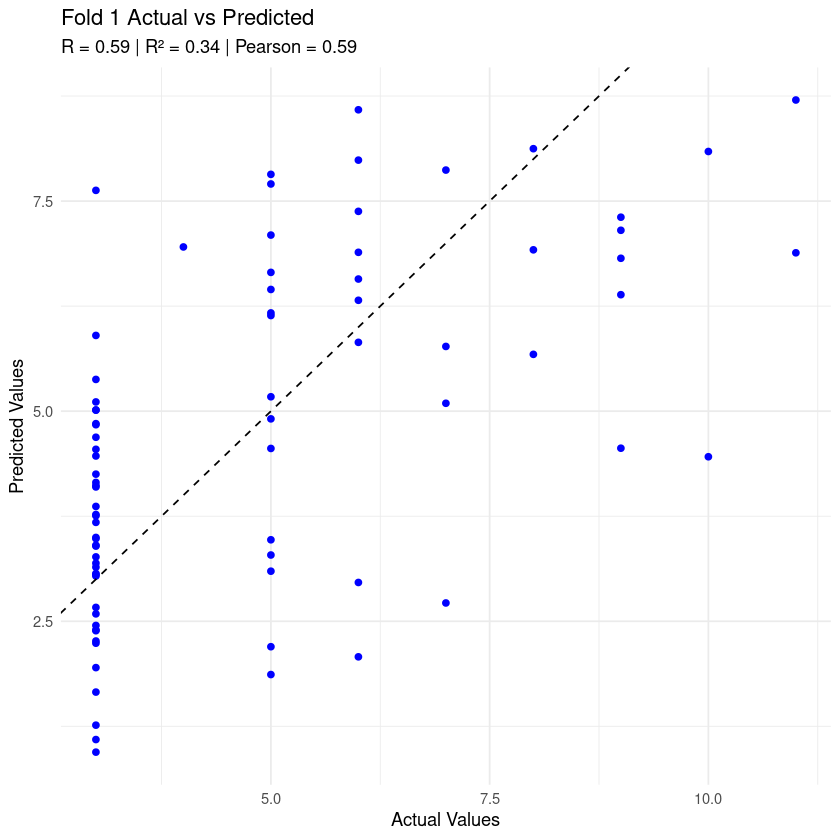

Fold 3 AUC: 0.634146341463415 
[1] 326   2
[1]    326 144965


Warning message:
“Zero sample variances detected, have been offset away from zero”
Warning message in roc.default(testing_set$child_pugh_score, predictions):
“'response' has more than two levels. Consider setting 'levels' explicitly or using 'multiclass.roc' instead”
Setting levels: control = 3, case = 4

Setting direction: controls < cases



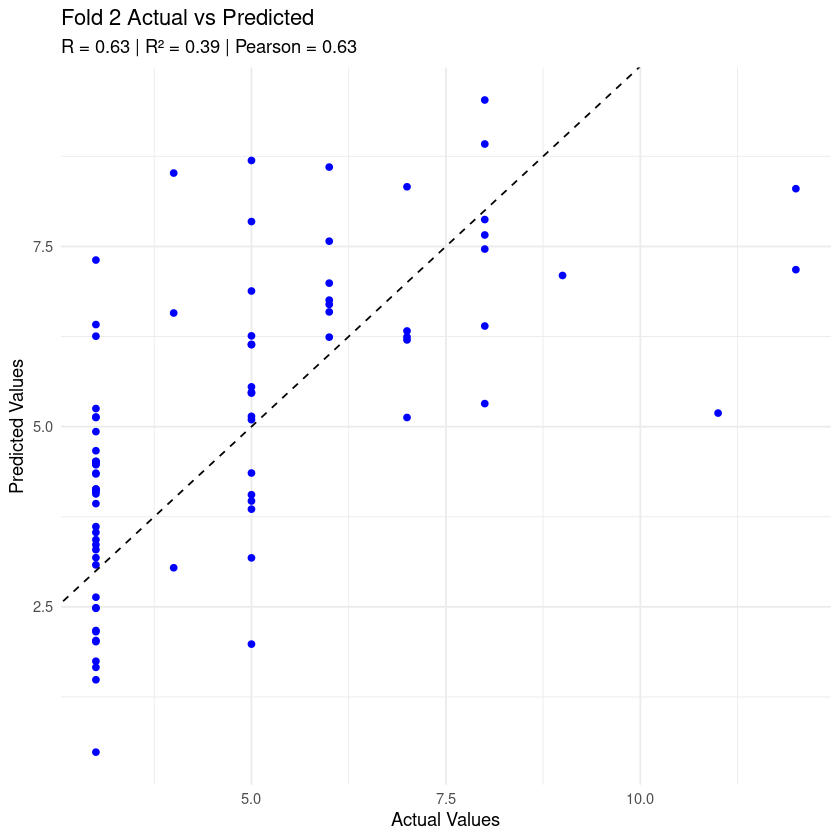

Fold 4 AUC: 0.95 
[1] 327   2
[1]    327 144965


Warning message:
“Zero sample variances detected, have been offset away from zero”
Warning message in roc.default(testing_set$child_pugh_score, predictions):
“'response' has more than two levels. Consider setting 'levels' explicitly or using 'multiclass.roc' instead”
Setting levels: control = 3, case = 4

Setting direction: controls < cases



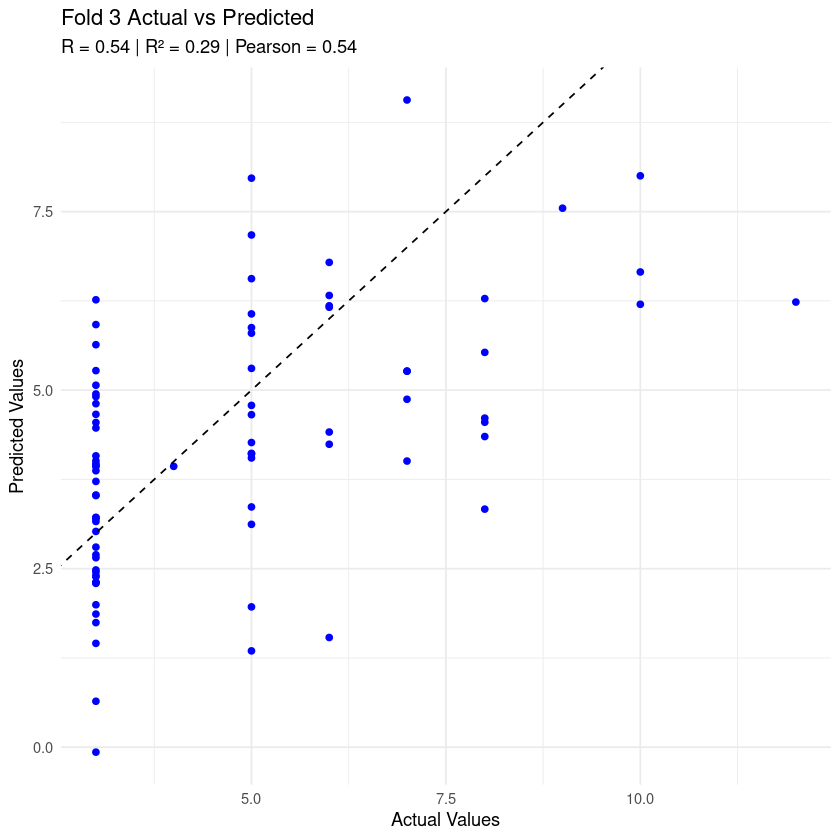

Fold 5 AUC: 0.641025641025641 


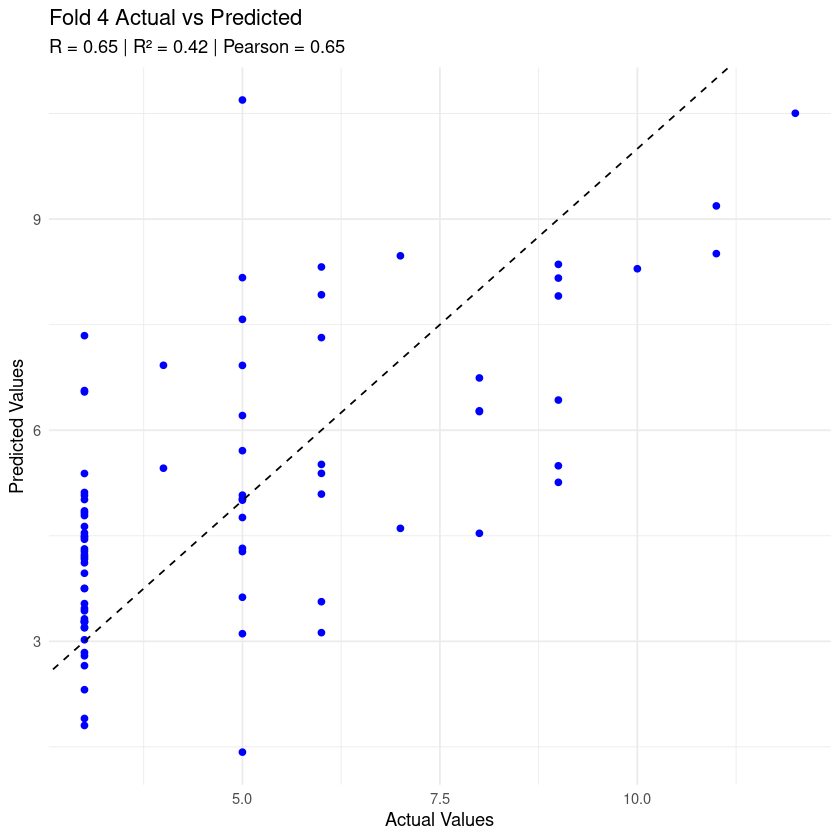

AUC for fold 1 : 0.975609756097561 
AUC for fold 2 : 0.752136752136752 
AUC for fold 3 : 0.634146341463415 
AUC for fold 4 : 0.95 
AUC for fold 5 : 0.641025641025641 


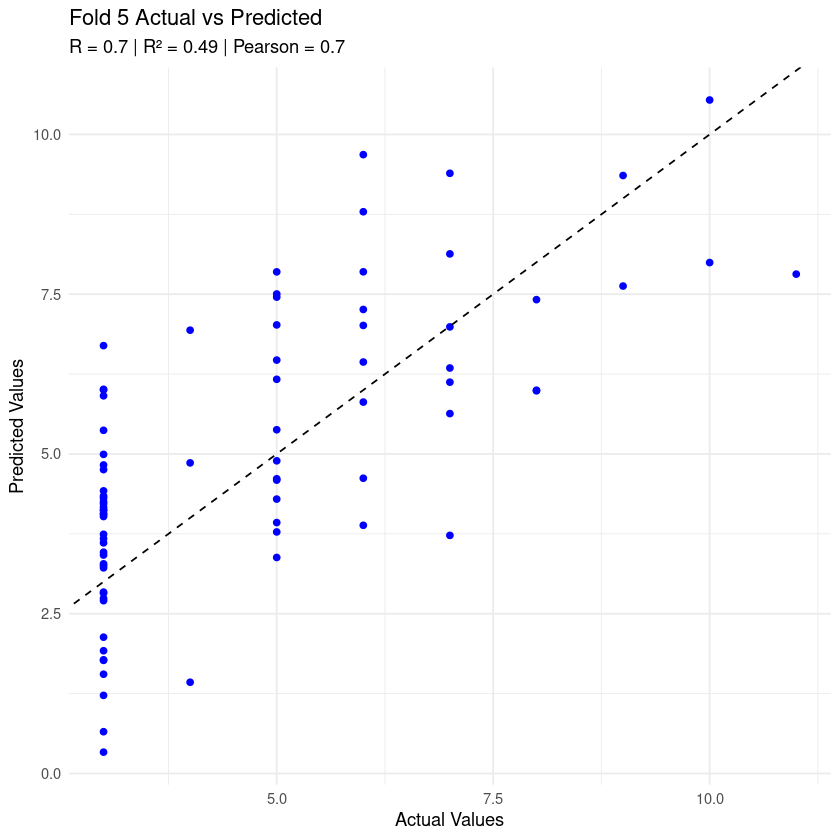

In [14]:
library(caret)
library(limma)
library(pROC)

# Set seed for reproducibility
set.seed(123)

# Number of folds
k <- 5

# Create k-fold cross-validation indices
folds <- createFolds(combined_data_clean$child_pugh_score, k = k, list = TRUE, returnTrain = TRUE)

# Initialize lists to store results
all_predictions <- list()
all_performances <- vector()
all_top_markers <- list()
all_auc <- numeric(k)

# Perform k-fold cross-validation manually
for (i in 1:k) {
     # Use the preloaded training and testing sets
    training_set <- training_sets[[i]]
    testing_set <- testing_sets[[i]]
    # Ensure the column names are correct for column removal
    columns_to_remove <- colnames(filtered_pheno_data)
    columns_to_remove <- c(columns_to_remove, "rowname") # Adjust if needed

    # Remove specified columns from the training data
    methylation_training_data_filtered <- training_set[, !colnames(training_set) %in% columns_to_remove]

    # Create the design matrix
    design_train <- model.matrix(~ child_pugh_score, data = training_set)

    # Remove 'child_pugh_score' column from methylation data
    methylation_data_no_child_pugh <- methylation_training_data_filtered[, !colnames(methylation_training_data_filtered) %in% "child_pugh_score"]

    # Check dimensions
    print(dim(design_train))  # Dimensions of design matrix
    print(dim(methylation_data_no_child_pugh))  # Dimensions of filtered data

    # Fit the linear model
    fit <- lmFit(t(methylation_data_no_child_pugh), design_train)
    fit <- eBayes(fit)

    # Get top 100 significant markers
    top_100_results <- topTable(fit, coef = 2, number = 100)
    top_100_markers <- rownames(top_100_results)

    # Store the top 100 markers for the current fold
    all_top_markers[[i]] <- top_100_markers
    # Export top 100 markers for the current fold to a CSV file
    write.csv(top_100_markers, file = paste0("ChildPugh_top_100_markers_fold_", i, ".csv"), row.names = FALSE)

    # Filter training and testing data to include only the top 100 markers
    training_set_filtered <- training_set[, c("child_pugh_score", top_100_markers)]
    testing_set_filtered <- testing_set[, c("child_pugh_score", top_100_markers)]

    # Fit the linear model using the filtered training data
    model <- lm(child_pugh_score ~ ., data = training_set_filtered)

    # Predict on the filtered testing set
    predictions <- predict(model, newdata = testing_set_filtered)

    # Store the predictions
    all_predictions[[i]] <- data.frame(
    PlasmaAlias = testing_set$plasma_alias,
    Actual = testing_set$child_pugh_score,
    Predicted = predictions
    )

    # Calculate and store the performance metrics for the current fold
    performance <- postResample(predictions, testing_set$child_pugh_score)
    all_performances <- rbind(all_performances, performance)

    # Calculate and store the AUC for the current fold
    roc_curve <- roc(testing_set$child_pugh_score, predictions)
    auc_value <- auc(roc_curve)
    all_auc[i] <- auc_value

    # Print AUC for the current fold
    cat(paste("Fold", i, "AUC:", auc_value, "\n"))
    # Plot the actual vs predicted values
    plot_data <- data.frame(
        Actual = testing_set$child_pugh_score,
        Predicted = predictions
    )
    # Calculate Pearson Correlation Coefficient R and R²
    r_value <- cor(plot_data$Actual, plot_data$Predicted)
    r_squared <- r_value^2
    pearson_corr <- cor(plot_data$Actual, plot_data$Predicted, method = "pearson")

    # Create the plot with y = x line and Pearson correlation
    p <- ggplot(plot_data, aes(x = Actual, y = Predicted)) +
        geom_point(color = "blue") +
        # Add the y = x line
        geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "black") +
        labs(title = paste("Fold", i, "Actual vs Predicted"),
             subtitle = paste("R =", round(r_value, 2), "| R² =", round(r_squared, 2), "| Pearson =", round(pearson_corr, 2)),
             x = "Actual Values",
             y = "Predicted Values") +
        theme_minimal()

    # Display the plot
    print(p)
}

# Print AUC values for each fold
for (i in 1:k) {
  cat(paste("AUC for fold", i, ":", all_auc[i], "\n"))
}


# 100 Markers

In [ ]:
library(caret)
library(limma)
library(pROC)

# Set seed for reproducibility
set.seed(123)

# Number of folds
k <- 5

# Create k-fold cross-validation indices
folds <- createFolds(combined_data_clean$child_pugh_score, k = k, list = TRUE, returnTrain = TRUE)

# Initialize lists to store results
all_predictions <- list()
all_performances <- vector()
all_top_markers <- list()
all_auc <- numeric(k)

# Perform k-fold cross-validation manually
for (i in 1:k) {
     # Use the preloaded training and testing sets
    training_set <- training_sets[[i]]
    testing_set <- testing_sets[[i]]
    # Ensure the column names are correct for column removal
    columns_to_remove <- colnames(filtered_pheno_data)
    columns_to_remove <- c(columns_to_remove, "rowname") # Adjust if needed

    # Remove specified columns from the training data
    methylation_training_data_filtered <- training_set[, !colnames(training_set) %in% columns_to_remove]

    # Create the design matrix
    design_train <- model.matrix(~ child_pugh_score, data = training_set)

    # Remove 'child_pugh_score' column from methylation data
    methylation_data_no_child_pugh <- methylation_training_data_filtered[, !colnames(methylation_training_data_filtered) %in% "child_pugh_score"]

    # Check dimensions
    print(dim(design_train))  # Dimensions of design matrix
    print(dim(methylation_data_no_child_pugh))  # Dimensions of filtered data

    # Fit the linear model
    fit <- lmFit(t(methylation_data_no_child_pugh), design_train)
    fit <- eBayes(fit)

    # Get top 100 significant markers
    top_100_results <- topTable(fit, coef = 2, number = 50)
    top_100_markers <- rownames(top_100_results)

    # Store the top 100 markers for the current fold
    all_top_markers[[i]] <- top_100_markers
    # Export top 100 markers for the current fold to a CSV file
    write.csv(top_100_markers, file = paste0("ChildPugh_top_100_markers_fold_", i, ".csv"), row.names = FALSE)

    # Filter training and testing data to include only the top 100 markers
    training_set_filtered <- training_set[, c("child_pugh_score", top_100_markers)]
    testing_set_filtered <- testing_set[, c("child_pugh_score", top_100_markers)]

    # Fit the linear model using the filtered training data
    model <- lm(child_pugh_score ~ ., data = training_set_filtered)

    # Predict on the filtered testing set
    predictions <- predict(model, newdata = testing_set_filtered)

    # Store the predictions
    all_predictions[[i]] <- data.frame(
    PlasmaAlias = testing_set$plasma_alias,
    Actual = testing_set$child_pugh_score,
    Predicted = predictions
    )

    # Calculate and store the performance metrics for the current fold
    performance <- postResample(predictions, testing_set$child_pugh_score)
    all_performances <- rbind(all_performances, performance)

    # Calculate and store the AUC for the current fold
    roc_curve <- roc(testing_set$child_pugh_score, predictions)
    auc_value <- auc(roc_curve)
    all_auc[i] <- auc_value

    # Print AUC for the current fold
    cat(paste("Fold", i, "AUC:", auc_value, "\n"))
    # Plot the actual vs predicted values
    plot_data <- data.frame(
        Actual = testing_set$child_pugh_score,
        Predicted = predictions
    )
    # Calculate Pearson Correlation Coefficient R and R²
    r_value <- cor(plot_data$Actual, plot_data$Predicted)
    r_squared <- r_value^2
    pearson_corr <- cor(plot_data$Actual, plot_data$Predicted, method = "pearson")

    # Create the plot with y = x line and Pearson correlation
    p <- ggplot(plot_data, aes(x = Actual, y = Predicted)) +
        geom_point(color = "blue") +
        # Add the y = x line
        geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "black") +
        labs(title = paste("Fold", i, "Actual vs Predicted"),
             subtitle = paste("R =", round(r_value, 2), "| R² =", round(r_squared, 2), "| Pearson =", round(pearson_corr, 2)),
             x = "Actual Values",
             y = "Predicted Values") +
        theme_minimal()

    # Display the plot
    print(p)
}

# Print AUC values for each fold
for (i in 1:k) {
  cat(paste("AUC for fold", i, ":", all_auc[i], "\n"))
}


Warning message:
“Zero sample variances detected, have been offset away from zero”
Warning message in roc.default(testing_set$child_pugh_score, predictions):
“'response' has more than two levels. Consider setting 'levels' explicitly or using 'multiclass.roc' instead”
Setting levels: control = 3, case = 4

Setting direction: controls < cases



Fold 1 AUC: 0.975609756097561 


Warning message:
“Zero sample variances detected, have been offset away from zero”
Warning message in roc.default(testing_set$child_pugh_score, predictions):
“'response' has more than two levels. Consider setting 'levels' explicitly or using 'multiclass.roc' instead”
Setting levels: control = 3, case = 4

Setting direction: controls < cases



Fold 2 AUC: 0.632478632478632 


Warning message:
“Zero sample variances detected, have been offset away from zero”
Warning message in roc.default(testing_set$child_pugh_score, predictions):
“'response' has more than two levels. Consider setting 'levels' explicitly or using 'multiclass.roc' instead”
Setting levels: control = 3, case = 4

Setting direction: controls > cases



Fold 3 AUC: 0.585365853658537 


Warning message:
“Zero sample variances detected, have been offset away from zero”
Warning message in roc.default(testing_set$child_pugh_score, predictions):
“'response' has more than two levels. Consider setting 'levels' explicitly or using 'multiclass.roc' instead”
Setting levels: control = 3, case = 4

Setting direction: controls < cases



Fold 4 AUC: 1 


Warning message:
“Zero sample variances detected, have been offset away from zero”
Warning message in roc.default(testing_set$child_pugh_score, predictions):
“'response' has more than two levels. Consider setting 'levels' explicitly or using 'multiclass.roc' instead”
Setting levels: control = 3, case = 4

Setting direction: controls < cases



Fold 5 AUC: 0.752136752136752 
AUC for fold 1 : 0.975609756097561 
AUC for fold 2 : 0.632478632478632 
AUC for fold 3 : 0.585365853658537 
AUC for fold 4 : 1 
AUC for fold 5 : 0.752136752136752 


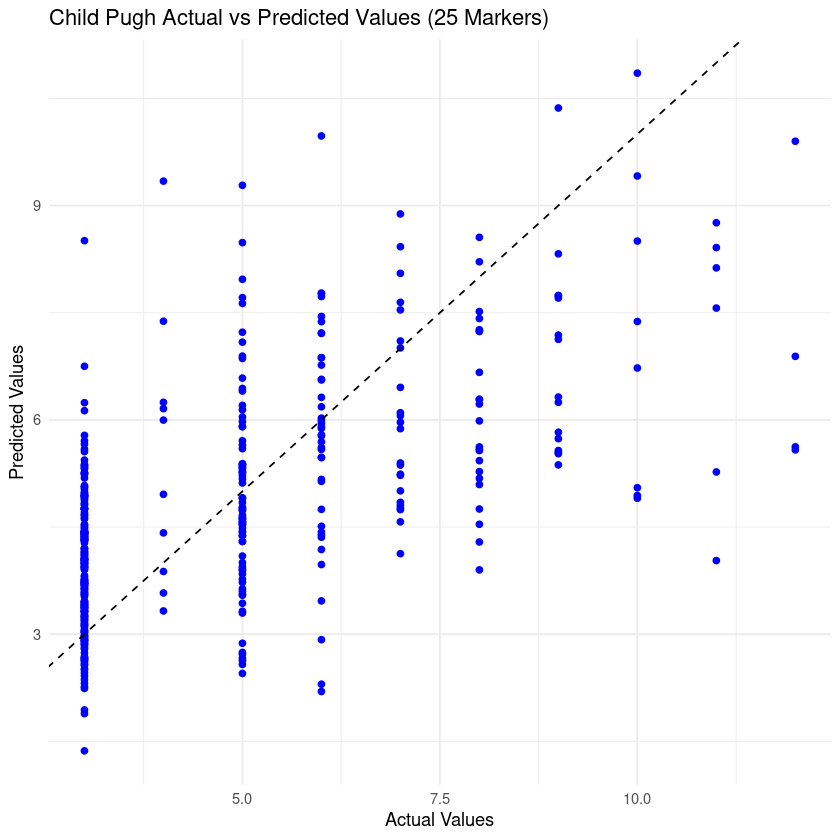

In [19]:
library(caret)
library(limma)
library(pROC)
library(ggplot2)

# Set seed for reproducibility
set.seed(123)

# Number of folds
k <- 5

# Create k-fold cross-validation indices
folds <- createFolds(combined_data_clean$child_pugh_score, k = k, list = TRUE, returnTrain = TRUE)

# Initialize lists to store results
all_predictions <- list()
all_performances <- vector()
all_top_markers <- list()
all_auc <- numeric(k)
aggregated_data <- data.frame()  # Empty dataframe for aggregated results

# Perform k-fold cross-validation manually
for (i in 1:k) {
    # Use the preloaded training and testing sets
    training_set <- training_sets[[i]]
    testing_set <- testing_sets[[i]]
    
    # Ensure the column names are correct for column removal
    columns_to_remove <- colnames(filtered_pheno_data)
    columns_to_remove <- c(columns_to_remove, "rowname") # Adjust if needed

    # Remove specified columns from the training data
    methylation_training_data_filtered <- training_set[, !colnames(training_set) %in% columns_to_remove]

    # Create the design matrix
    design_train <- model.matrix(~ child_pugh_score, data = training_set)

    # Remove 'child_pugh_score' column from methylation data
    methylation_data_no_child_pugh <- methylation_training_data_filtered[, !colnames(methylation_training_data_filtered) %in% "child_pugh_score"]

    # Fit the linear model
    fit <- lmFit(t(methylation_data_no_child_pugh), design_train)
    fit <- eBayes(fit)

    # Get top 100 significant markers
    top_100_results <- topTable(fit, coef = 2, number = 25
                               )
    top_100_markers <- rownames(top_100_results)

    # Store the top 100 markers for the current fold
    all_top_markers[[i]] <- top_100_markers
    # Export top 100 markers for the current fold to a CSV file
    write.csv(top_100_markers, file = paste0("ChildPugh_top_100_markers_fold_", i, ".csv"), row.names = FALSE)

    # Filter training and testing data to include only the top 100 markers
    training_set_filtered <- training_set[, c("child_pugh_score", top_100_markers)]
    testing_set_filtered <- testing_set[, c("child_pugh_score", top_100_markers)]

    # Fit the linear model using the filtered training data
    model <- lm(child_pugh_score ~ ., data = training_set_filtered)

    # Predict on the filtered testing set
    predictions <- predict(model, newdata = testing_set_filtered)

    # Store the predictions
    fold_predictions <- data.frame(
        PlasmaAlias = testing_set$plasma_alias,
        Actual = testing_set$child_pugh_score,
        Predicted = predictions,
        Fold = i  # Track the fold number
    )
    
    all_predictions[[i]] <- fold_predictions
    
    # Append the fold predictions to the aggregated data
    aggregated_data <- rbind(aggregated_data, fold_predictions)

    # Calculate and store the performance metrics for the current fold
    performance <- postResample(predictions, testing_set$child_pugh_score)
    all_performances <- rbind(all_performances, performance)

    # Calculate and store the AUC for the current fold
    roc_curve <- roc(testing_set$child_pugh_score, predictions)
    auc_value <- auc(roc_curve)
    all_auc[i] <- auc_value

    # Print AUC for the current fold
    cat(paste("Fold", i, "AUC:", auc_value, "\n"))
}

p_aggregated_single_color <- ggplot(aggregated_data, aes(x = Actual, y = Predicted)) +
    geom_point(color = "blue") +  # Set a single color for all points
    geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "black") +
    labs(title = "Child Pugh Actual vs Predicted Values (25 Markers)",
         #subtitle = "All points in the same color across 5 folds",
         x = "Actual Values",
         y = "Predicted Values") +
    theme_minimal()

# Display the aggregated plot
print(p_aggregated_single_color)

# Print AUC values for each fold
for (i in 1:k) {
  cat(paste("AUC for fold", i, ":", all_auc[i], "\n"))
}


# Pick up from here

Do the clasification from here -> find out if I can do rounding values e.g. 4.5=5 for the classification or would i have to do the thresholds myself

In [39]:
library(caret)
library(pROC)

# Define classification thresholds
classify <- function(value) {
  if (value < 5) {
    return(1)
  } else if (value >= 5 & value < 7) {
    return(2)
  } else if (value >= 7 & value < 10) {
    return(3)
  } else if (value >= 10 & value < 15) {
    return(4)
  } else {
    return(5)
  }
}

# Number of folds
k <- 5

# Initialize lists to store results
all_conf_matrices <- list()
all_auc <- numeric(k)
all_accuracy <- numeric(k)
all_sensitivity <- numeric(k)
all_specificity <- numeric(k)
all_predictions_vs_actual <- list()  # Store actual vs predicted for each fold

# Initialize vectors to store all predictions and actual values across folds
all_classified_predictions <- factor()  # Empty factor to accumulate predictions
all_classified_actuals <- factor()      # Empty factor to accumulate actual values

# Create k-fold cross-validation indices
folds <- createFolds(combined_data_clean$child_pugh_score, k = k, list = TRUE, returnTrain = TRUE)

# Perform k-fold cross-validation manually
# Perform k-fold cross-validation manually
for (i in 1:k) {
    training_set <- training_sets[[i]]
    testing_set <- testing_sets[[i]]

    # Ensure the column names are correct for column removal
    columns_to_remove <- colnames(filtered_pheno_data)
    columns_to_remove <- c(columns_to_remove, "rowname") # Adjust if needed

    # Remove specified columns from the training data
    methylation_training_data_filtered <- training_set[, !colnames(training_set) %in% columns_to_remove]

    # Create the design matrix
    design_train <- model.matrix(~ child_pugh_score, data = training_set)

    # Remove 'child_pugh_score' column from methylation data
    methylation_data_no_child_pugh <- methylation_training_data_filtered[, !colnames(methylation_training_data_filtered) %in% "child_pugh_score"]

    # Fit the linear model
    fit <- lmFit(t(methylation_data_no_child_pugh), design_train)
    fit <- eBayes(fit)

    # Get top 100 significant markers
    top_100_results <- topTable(fit, coef = 2, number = 100)
    top_100_markers <- rownames(top_100_results)

    # Filter training and testing data to include only the top 100 markers
    training_set_filtered <- training_set[, c("child_pugh_score", top_100_markers)]
    testing_set_filtered <- testing_set[, c("child_pugh_score", top_100_markers)]

    # Fit the linear model using the filtered training data
    model <- lm(child_pugh_score ~ ., data = training_set_filtered)

    # Predict on the filtered testing set
    predictions <- predict(model, newdata = testing_set_filtered)

    # Classify predictions and actual values
    classified_predictions <- sapply(predictions, classify)
    classified_actuals <- sapply(testing_set$child_pugh_score, classify)

    # Ensure they are factors with levels 1, 2, 3, 4
    classified_predictions <- factor(classified_predictions, levels = 1:4)
    classified_actuals <- factor(classified_actuals, levels = 1:4)

    # Check for NA values in classified predictions and actual values
    valid_indices <- !is.na(classified_predictions) & !is.na(classified_actuals)
    classified_predictions <- classified_predictions[valid_indices]
    classified_actuals <- classified_actuals[valid_indices]

    # Store actual, predicted, and rounded predicted values
    all_predictions_vs_actual[[i]] <- data.frame(
      Actual = testing_set$child_pugh_score[valid_indices], 
      Predicted = predictions[valid_indices]
    )

    # Accumulate classified predictions and actuals for overall confusion matrix
    all_classified_predictions <- c(all_classified_predictions, classified_predictions)
    all_classified_actuals <- c(all_classified_actuals, classified_actuals)

    # Create a confusion matrix for this fold
    conf_matrix <- confusionMatrix(classified_predictions, classified_actuals)
    all_conf_matrices[[i]] <- conf_matrix

    # Calculate and store accuracy
    accuracy <- sum(classified_predictions == classified_actuals) / length(classified_actuals)
    all_accuracy[i] <- accuracy

    # Calculate and store AUC
    roc_multiclass <- multiclass.roc(classified_actuals, as.numeric(classified_predictions))
    auc_value <- auc(roc_multiclass)
    all_auc[i] <- auc_value

    # Extract sensitivity and specificity from the confusion matrix
    sensitivity_by_class <- conf_matrix$byClass[,"Sensitivity"]
    overall_sensitivity <- mean(sensitivity_by_class, na.rm = TRUE)
    all_sensitivity[i] <- overall_sensitivity

    specificity_by_class <- conf_matrix$byClass[,"Specificity"]
    overall_specificity <- mean(specificity_by_class, na.rm = TRUE)
    all_specificity[i] <- overall_specificity

    # Print results for the current fold
    cat(paste("Fold", i, "Confusion Matrix:\n"))
    print(conf_matrix)
    cat(paste("Fold", i, "Accuracy:", accuracy, "\n"))
    cat(paste("Fold", i, "AUC:", auc_value, "\n"))
    cat(paste("Fold", i, "Overall Sensitivity:", overall_sensitivity, "\n"))
    cat(paste("Fold", i, "Overall Specificity:", overall_specificity, "\n"))
    
    # Print actual, predicted, and rounded predicted values
    cat(paste("Fold", i, "Actual vs Predicted vs Rounded Predicted values:\n"))
    print(all_predictions_vs_actual[[i]])
}

# Create overall confusion matrix
overall_conf_matrix <- confusionMatrix(all_classified_predictions, all_classified_actuals)

# Print the overall confusion matrix
cat("Overall Confusion Matrix across all folds:\n")
print(overall_conf_matrix)

# Print aggregate results
cat("Aggregate Results Across All Folds:\n")
cat("Average Accuracy:", mean(all_accuracy), "\n")
cat("Average AUC:", mean(all_auc), "\n")
cat("Average Sensitivity:", mean(all_sensitivity), "\n")
cat("Average Specificity:", mean(all_specificity), "\n")


Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 1 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 35  9  2  1
         2  6  9  6  1
         3  1  6  4  2
         4  0  0  0  0

Overall Statistics
                                          
               Accuracy : 0.5854          
                 95% CI : (0.4712, 0.6932)
    No Information Rate : 0.5122          
    P-Value [Acc > NIR] : 0.1120          
                                          
                  Kappa : 0.3143          
                                          
 Mcnemar's Test P-Value : 0.5524          

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.8333   0.3750  0.33333  0.00000
Specificity            0.7000   0.7759  0.87143  1.00000
Pos Pred Value         0.7447   0.4091  0.30769      NaN
Neg Pred Value         0.8000   0.7500  0.88406  0.95122
Prevalence             0.5122   0.2927  0.14634  0.04878
Detection Rate         0.4268   0.1

Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 2 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 34  6  0  0
         2  6 14  6  1
         3  2  4  7  2
         4  0  0  0  0

Overall Statistics
                                          
               Accuracy : 0.6707          
                 95% CI : (0.5581, 0.7706)
    No Information Rate : 0.5122          
    P-Value [Acc > NIR] : 0.002659        
                                          
                  Kappa : 0.473           
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.8095   0.5833  0.53846  0.00000
Specificity            0.8500   0.7759  0.88406  1.00000
Pos Pred Value         0.8500   0.5185  0.46667      NaN
Neg Pred Value         0.8095   0.8182  0.91045  0.96341
Prevalence             0.5122   0.2927  0.15854  0.03659
Detection Rate         0.4146   0.1

Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 3 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 37 13  6  0
         2  5  9  4  3
         3  0  2  2  1
         4  0  0  0  0

Overall Statistics
                                          
               Accuracy : 0.5854          
                 95% CI : (0.4712, 0.6932)
    No Information Rate : 0.5122          
    P-Value [Acc > NIR] : 0.112           
                                          
                  Kappa : 0.2679          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.8810   0.3750  0.16667  0.00000
Specificity            0.5250   0.7931  0.95714  1.00000
Pos Pred Value         0.6607   0.4286  0.40000      NaN
Neg Pred Value         0.8077   0.7541  0.87013  0.95122
Prevalence             0.5122   0.2927  0.14634  0.04878
Detection Rate         0.4512   0.1

Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 4 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 33  8  2  0
         2  8  9  6  0
         3  1  5  4  3
         4  0  1  0  1

Overall Statistics
                                          
               Accuracy : 0.5802          
                 95% CI : (0.4654, 0.6891)
    No Information Rate : 0.5185          
    P-Value [Acc > NIR] : 0.1585          
                                          
                  Kappa : 0.322           
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.7857   0.3913  0.33333  0.25000
Specificity            0.7436   0.7586  0.86957  0.98701
Pos Pred Value         0.7674   0.3913  0.30769  0.50000
Neg Pred Value         0.7632   0.7586  0.88235  0.96203
Prevalence             0.5185   0.2840  0.14815  0.04938
Detection Rate         0.4074   0.1

Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 5 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 36  9  1  0
         2  6  5  6  0
         3  0  9  5  2
         4  0  0  0  1

Overall Statistics
                                          
               Accuracy : 0.5875          
                 95% CI : (0.4718, 0.6965)
    No Information Rate : 0.525           
    P-Value [Acc > NIR] : 0.1568          
                                          
                  Kappa : 0.3199          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.8571   0.2174   0.4167   0.3333
Specificity            0.7368   0.7895   0.8382   1.0000
Pos Pred Value         0.7826   0.2941   0.3125   1.0000
Neg Pred Value         0.8235   0.7143   0.8906   0.9747
Prevalence             0.5250   0.2875   0.1500   0.0375
Detection Rate         0.4500   0.0

# 0.5 cutoffs

In [41]:
library(caret)
library(pROC)

# Define classification thresholds
classify <- function(value) {
  if (value < 4.5) {
    return(1)
  } else if (value >= 4.5 & value < 6.5) {
    return(2)
  } else if (value >= 6.5 & value < 9.5) {
    return(3)
  } else if (value >= 9.5 & value < 15) {
    return(4)
  } else {
    return(5)
  }
}

# Number of folds
k <- 5

# Initialize lists to store results
all_conf_matrices <- list()
all_auc <- numeric(k)
all_accuracy <- numeric(k)
all_sensitivity <- numeric(k)
all_specificity <- numeric(k)

# Create k-fold cross-validation indices
folds <- createFolds(combined_data_clean$child_pugh_score, k = k, list = TRUE, returnTrain = TRUE)

# Perform k-fold cross-validation manually
for (i in 1:k) {
    training_set <- training_sets[[i]]
    testing_set <- testing_sets[[i]]

    # Ensure the column names are correct for column removal
    columns_to_remove <- colnames(filtered_pheno_data)
    columns_to_remove <- c(columns_to_remove, "rowname") # Adjust if needed

    # Remove specified columns from the training data
    methylation_training_data_filtered <- training_set[, !colnames(training_set) %in% columns_to_remove]

    # Create the design matrix
    design_train <- model.matrix(~ child_pugh_score, data = training_set)

    # Remove 'child_pugh_score' column from methylation data
    methylation_data_no_child_pugh <- methylation_training_data_filtered[, !colnames(methylation_training_data_filtered) %in% "child_pugh_score"]

    # Fit the linear model
    fit <- lmFit(t(methylation_data_no_child_pugh), design_train)
    fit <- eBayes(fit)

    # Get top 100 significant markers
    top_100_results <- topTable(fit, coef = 2, number = 100)
    top_100_markers <- rownames(top_100_results)

    # Filter training and testing data to include only the top 100 markers
    training_set_filtered <- training_set[, c("child_pugh_score", top_100_markers)]
    testing_set_filtered <- testing_set[, c("child_pugh_score", top_100_markers)]

    # Fit the linear model using the filtered training data
    model <- lm(child_pugh_score ~ ., data = training_set_filtered)

    # Predict on the filtered testing set
    predictions <- predict(model, newdata = testing_set_filtered)

    # Classify predictions and actual values
    classified_predictions <- sapply(predictions, classify)
    classified_actuals <- sapply(testing_set$child_pugh_score, classify)

    # Ensure they are factors with levels 1, 2, 3, 4
    classified_predictions <- factor(classified_predictions, levels = 1:4)
    classified_actuals <- factor(classified_actuals, levels = 1:4)

    # Check for NA values in classified predictions and actual values
    valid_indices <- !is.na(classified_predictions) & !is.na(classified_actuals)
    classified_predictions <- classified_predictions[valid_indices]
    classified_actuals <- classified_actuals[valid_indices]

    # Store actual, predicted, and rounded predicted values
    all_predictions_vs_actual[[i]] <- data.frame(
      Actual = testing_set$child_pugh_score[valid_indices], 
      Predicted = predictions[valid_indices]
    )

    # Create a confusion matrix for this fold
    conf_matrix <- confusionMatrix(classified_predictions, classified_actuals)
    all_conf_matrices[[i]] <- conf_matrix

    # Calculate and store accuracy
    accuracy <- sum(classified_predictions == classified_actuals) / length(classified_actuals)
    all_accuracy[i] <- accuracy

    # Calculate and store AUC
    roc_multiclass <- multiclass.roc(classified_actuals, as.numeric(classified_predictions))
    auc_value <- auc(roc_multiclass)
    all_auc[i] <- auc_value

    # Extract sensitivity and specificity from the confusion matrix
    sensitivity_by_class <- conf_matrix$byClass[,"Sensitivity"]
    overall_sensitivity <- mean(sensitivity_by_class, na.rm = TRUE)
    all_sensitivity[i] <- overall_sensitivity

    specificity_by_class <- conf_matrix$byClass[,"Specificity"]
    overall_specificity <- mean(specificity_by_class, na.rm = TRUE)
    all_specificity[i] <- overall_specificity

    # Print results for the current fold
    cat(paste("Fold", i, "Confusion Matrix:\n"))
    print(conf_matrix)
    cat(paste("Fold", i, "Accuracy:", accuracy, "\n"))
    cat(paste("Fold", i, "AUC:", auc_value, "\n"))
    cat(paste("Fold", i, "Overall Sensitivity:", overall_sensitivity, "\n"))
    cat(paste("Fold", i, "Overall Specificity:", overall_specificity, "\n"))
    
    # Print actual, predicted, and rounded predicted values
    cat(paste("Fold", i, "Actual vs Predicted values:\n"))
    print(all_predictions_vs_actual[[i]])
}

# Initialize an empty matrix for accumulating confusion matrix counts
overall_conf_matrix <- matrix(0, nrow = 4, ncol = 4)

# Loop over all confusion matrices from each fold and sum the table counts
for (i in 1:k) {
  # Extract confusion matrix for this fold as a table
  fold_conf_matrix <- as.table(all_conf_matrices[[i]]$table)
  
  # Sum the counts into the overall confusion matrix
  overall_conf_matrix <- overall_conf_matrix + fold_conf_matrix
}

# Convert the overall matrix to a table for clearer output
overall_conf_matrix <- as.table(overall_conf_matrix)

# Print the overall confusion matrix
cat("Overall Confusion Matrix across all folds:\n")
print(overall_conf_matrix)

# Optionally, calculate overall accuracy, sensitivity, specificity based on the accumulated matrix
overall_accuracy <- sum(diag(overall_conf_matrix)) / sum(overall_conf_matrix)
cat("Overall Accuracy across all folds:", overall_accuracy, "\n")

# Calculate sensitivity and specificity for each class
overall_sensitivity <- diag(overall_conf_matrix) / rowSums(overall_conf_matrix)
overall_specificity <- diag(overall_conf_matrix) / colSums(overall_conf_matrix)

cat("Overall Sensitivity across all folds:\n")
print(overall_sensitivity)

cat("Overall Specificity across all folds:\n")
print(overall_specificity)

# Print aggregate results
cat("Aggregate Results Across All Folds:\n")
cat("Average Accuracy:", mean(all_accuracy), "\n")
cat("Average AUC:", mean(all_auc), "\n")
cat("Average Sensitivity:", mean(all_sensitivity), "\n")
cat("Average Specificity:", mean(all_specificity), "\n")


Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 1 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 31  7  1  1
         2  9  8  5  0
         3  2  9  6  3
         4  0  0  0  0

Overall Statistics
                                         
               Accuracy : 0.5488         
                 95% CI : (0.4349, 0.659)
    No Information Rate : 0.5122         
    P-Value [Acc > NIR] : 0.2907         
                                         
                  Kappa : 0.2905         
                                         
 Mcnemar's Test P-Value : NA             

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.7381  0.33333  0.50000  0.00000
Specificity            0.7750  0.75862  0.80000  1.00000
Pos Pred Value         0.7750  0.36364  0.30000      NaN
Neg Pred Value         0.7381  0.73333  0.90323  0.95122
Prevalence             0.5122  0.29268  0.14634  0.04878
Detection Rate         0.3780  0.09756  0.07

Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 2 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 29  6  0  0
         2 10  9  6  1
         3  3  9  6  2
         4  0  0  1  0

Overall Statistics
                                         
               Accuracy : 0.5366         
                 95% CI : (0.423, 0.6475)
    No Information Rate : 0.5122         
    P-Value [Acc > NIR] : 0.3706         
                                         
                  Kappa : 0.2865         
                                         
 Mcnemar's Test P-Value : NA             

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.6905   0.3750  0.46154  0.00000
Specificity            0.8500   0.7069  0.79710  0.98734
Pos Pred Value         0.8286   0.3462  0.30000  0.00000
Neg Pred Value         0.7234   0.7321  0.88710  0.96296
Prevalence             0.5122   0.2927  0.15854  0.03659
Detection Rate         0.3537   0.1098  0.07

Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 3 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 32 11  3  0
         2 10  9  7  2
         3  0  4  2  2
         4  0  0  0  0

Overall Statistics
                                          
               Accuracy : 0.5244          
                 95% CI : (0.4111, 0.6359)
    No Information Rate : 0.5122          
    P-Value [Acc > NIR] : 0.4564          
                                          
                  Kappa : 0.2053          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.7619   0.3750  0.16667  0.00000
Specificity            0.6500   0.6724  0.91429  1.00000
Pos Pred Value         0.6957   0.3214  0.25000      NaN
Neg Pred Value         0.7222   0.7222  0.86486  0.95122
Prevalence             0.5122   0.2927  0.14634  0.04878
Detection Rate         0.3902   0.1

Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 4 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 28  7  0  0
         2 10  9  7  0
         3  4  6  5  3
         4  0  1  0  1

Overall Statistics
                                          
               Accuracy : 0.5309          
                 95% CI : (0.4167, 0.6427)
    No Information Rate : 0.5185          
    P-Value [Acc > NIR] : 0.4563          
                                          
                  Kappa : 0.279           
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.6667   0.3913  0.41667  0.25000
Specificity            0.8205   0.7069  0.81159  0.98701
Pos Pred Value         0.8000   0.3462  0.27778  0.50000
Neg Pred Value         0.6957   0.7455  0.88889  0.96203
Prevalence             0.5185   0.2840  0.14815  0.04938
Detection Rate         0.3457   0.1

Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 5 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 32  5  1  0
         2  8  9  5  0
         3  2  8  6  2
         4  0  1  0  1

Overall Statistics
                                         
               Accuracy : 0.6            
                 95% CI : (0.4844, 0.708)
    No Information Rate : 0.525          
    P-Value [Acc > NIR] : 0.1088         
                                         
                  Kappa : 0.3719         
                                         
 Mcnemar's Test P-Value : NA             

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.7619   0.3913   0.5000   0.3333
Specificity            0.8421   0.7719   0.8235   0.9870
Pos Pred Value         0.8421   0.4091   0.3333   0.5000
Neg Pred Value         0.7619   0.7586   0.9032   0.9744
Prevalence             0.5250   0.2875   0.1500   0.0375
Detection Rate         0.4000   0.1125   0.0

# Rounding Method

In [46]:
library(caret)
library(pROC)

# Define classification thresholds
classify <- function(value) {
  if (value < 5) {
    return(1)
  } else if (value >= 5 & value < 7) {
    return(2)
  } else if (value >= 7 & value < 10) {
    return(3)
  } else if (value >= 10 & value < 15) {
    return(4)
  } else {
    return(5)
  }
}

# Number of folds
k <- 5

# Initialize lists to store results
all_conf_matrices <- list()
all_auc <- numeric(k)
all_accuracy <- numeric(k)
all_sensitivity <- numeric(k)
all_specificity <- numeric(k)
all_predictions_vs_actual <- list()  
all_pearson_correlations <- numeric(k)


# Initialize vectors to store all predictions and actual values across folds
all_classified_predictions <- factor()  # Empty factor to accumulate predictions
all_classified_actuals <- factor()      # Empty factor to accumulate actual values

# Create k-fold cross-validation indices
folds <- createFolds(combined_data_clean$child_pugh_score, k = k, list = TRUE, returnTrain = TRUE)

# Perform k-fold cross-validation manually
# Perform k-fold cross-validation manually
# Initialize a vector to store Pearson correlation coefficients
all_pearson_correlations <- numeric(k)

# Perform k-fold cross-validation manually
for (i in 1:k) {
    training_set <- training_sets[[i]]
    testing_set <- testing_sets[[i]]

    # Ensure the column names are correct for column removal
    columns_to_remove <- colnames(filtered_pheno_data)
    columns_to_remove <- c(columns_to_remove, "rowname") # Adjust if needed

    # Remove specified columns from the training data
    methylation_training_data_filtered <- training_set[, !colnames(training_set) %in% columns_to_remove]

    # Create the design matrix
    design_train <- model.matrix(~ child_pugh_score, data = training_set)

    # Remove 'child_pugh_score' column from methylation data
    methylation_data_no_child_pugh <- methylation_training_data_filtered[, !colnames(methylation_training_data_filtered) %in% "child_pugh_score"]

    # Fit the linear model
    fit <- lmFit(t(methylation_data_no_child_pugh), design_train)
    fit <- eBayes(fit)

    # Get top 100 significant markers
    top_100_results <- topTable(fit, coef = 2, number = 100)
    top_100_markers <- rownames(top_100_results)

    # Filter training and testing data to include only the top 100 markers
    training_set_filtered <- training_set[, c("child_pugh_score", top_100_markers)]
    testing_set_filtered <- testing_set[, c("child_pugh_score", top_100_markers)]

    # Fit the linear model using the filtered training data
    model <- lm(child_pugh_score ~ ., data = training_set_filtered)

    # Predict on the filtered testing set
    predictions <- predict(model, newdata = testing_set_filtered)

    # Round the predicted values before classification
    rounded_predictions <- round(predictions)

    # Classify predictions and actual values
    classified_predictions <- sapply(rounded_predictions, classify)
    classified_actuals <- sapply(testing_set$child_pugh_score, classify)

    # Ensure they are factors with levels 1, 2, 3, 4
    classified_predictions <- factor(classified_predictions, levels = 1:4)
    classified_actuals <- factor(classified_actuals, levels = 1:4)

    # Check for NA values in classified predictions and actual values
    valid_indices <- !is.na(classified_predictions) & !is.na(classified_actuals)
    classified_predictions <- classified_predictions[valid_indices]
    classified_actuals <- classified_actuals[valid_indices]

    # Store actual, predicted, and rounded predicted values
    all_predictions_vs_actual[[i]] <- data.frame(
      Actual = testing_set$child_pugh_score[valid_indices], 
      Predicted = predictions[valid_indices],
      Rounded_Predicted = rounded_predictions[valid_indices]
    )

    # Accumulate classified predictions and actuals for overall confusion matrix
    all_classified_predictions <- c(all_classified_predictions, classified_predictions)
    all_classified_actuals <- c(all_classified_actuals, classified_actuals)

    # Create a confusion matrix for this fold
    conf_matrix <- confusionMatrix(classified_predictions, classified_actuals)
    all_conf_matrices[[i]] <- conf_matrix

    # Calculate and store accuracy
    accuracy <- sum(classified_predictions == classified_actuals) / length(classified_actuals)
    all_accuracy[i] <- accuracy

    # Calculate and store AUC
    roc_multiclass <- multiclass.roc(classified_actuals, as.numeric(classified_predictions))
    auc_value <- auc(roc_multiclass)
    all_auc[i] <- auc_value

    # Extract sensitivity and specificity from the confusion matrix
    sensitivity_by_class <- conf_matrix$byClass[,"Sensitivity"]
    overall_sensitivity <- mean(sensitivity_by_class, na.rm = TRUE)
    all_sensitivity[i] <- overall_sensitivity

    specificity_by_class <- conf_matrix$byClass[,"Specificity"]
    overall_specificity <- mean(specificity_by_class, na.rm = TRUE)
    all_specificity[i] <- overall_specificity

    # Calculate Pearson correlation coefficient for this fold
    pearson_correlation <- cor(testing_set$child_pugh_score[valid_indices], predictions[valid_indices], method = "pearson")
    all_pearson_correlations[i] <- pearson_correlation

    # Print results for the current fold
    cat(paste("Fold", i, "Confusion Matrix:\n"))
    print(conf_matrix)
    cat(paste("Fold", i, "Accuracy:", accuracy, "\n"))
    cat(paste("Fold", i, "AUC:", auc_value, "\n"))
    cat(paste("Fold", i, "Overall Sensitivity:", overall_sensitivity, "\n"))
    cat(paste("Fold", i, "Overall Specificity:", overall_specificity, "\n"))
    cat(paste("Fold", i, "Pearson Correlation:", pearson_correlation, "\n"))
    
    # Print actual, predicted, and rounded predicted values
    cat(paste("Fold", i, "Actual vs Predicted vs Rounded Predicted values:\n"))
    print(all_predictions_vs_actual[[i]])
}

# Create overall confusion matrix
overall_conf_matrix <- confusionMatrix(all_classified_predictions, all_classified_actuals)

# Print the overall confusion matrix
cat("Overall Confusion Matrix across all folds:\n")
print(overall_conf_matrix)

# Print aggregate results
cat("Aggregate Results Across All Folds:\n")
cat("Average Accuracy:", mean(all_accuracy), "\n")
cat("Average AUC:", mean(all_auc), "\n")
cat("Average Sensitivity:", mean(all_sensitivity), "\n")
cat("Average Specificity:", mean(all_specificity), "\n")
cat("Average Pearson Correlation:", mean(all_pearson_correlations), "\n")


Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 1 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 31  7  1  1
         2  9  8  5  0
         3  2  9  6  3
         4  0  0  0  0

Overall Statistics
                                         
               Accuracy : 0.5488         
                 95% CI : (0.4349, 0.659)
    No Information Rate : 0.5122         
    P-Value [Acc > NIR] : 0.2907         
                                         
                  Kappa : 0.2905         
                                         
 Mcnemar's Test P-Value : NA             

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.7381  0.33333  0.50000  0.00000
Specificity            0.7750  0.75862  0.80000  1.00000
Pos Pred Value         0.7750  0.36364  0.30000      NaN
Neg Pred Value         0.7381  0.73333  0.90323  0.95122
Prevalence             0.5122  0.29268  0.14634  0.04878
Detection Rate         0.3780  0.09756  0.07

Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 2 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 29  6  0  0
         2 10  9  6  1
         3  3  9  6  2
         4  0  0  1  0

Overall Statistics
                                         
               Accuracy : 0.5366         
                 95% CI : (0.423, 0.6475)
    No Information Rate : 0.5122         
    P-Value [Acc > NIR] : 0.3706         
                                         
                  Kappa : 0.2865         
                                         
 Mcnemar's Test P-Value : NA             

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.6905   0.3750  0.46154  0.00000
Specificity            0.8500   0.7069  0.79710  0.98734
Pos Pred Value         0.8286   0.3462  0.30000  0.00000
Neg Pred Value         0.7234   0.7321  0.88710  0.96296
Prevalence             0.5122   0.2927  0.15854  0.03659
Detection Rate         0.3537   0.1098  0.07

Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 3 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 32 11  3  0
         2 10  9  7  2
         3  0  4  2  2
         4  0  0  0  0

Overall Statistics
                                          
               Accuracy : 0.5244          
                 95% CI : (0.4111, 0.6359)
    No Information Rate : 0.5122          
    P-Value [Acc > NIR] : 0.4564          
                                          
                  Kappa : 0.2053          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.7619   0.3750  0.16667  0.00000
Specificity            0.6500   0.6724  0.91429  1.00000
Pos Pred Value         0.6957   0.3214  0.25000      NaN
Neg Pred Value         0.7222   0.7222  0.86486  0.95122
Prevalence             0.5122   0.2927  0.14634  0.04878
Detection Rate         0.3902   0.1

Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 4 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 28  7  0  0
         2 10  9  7  0
         3  4  6  5  3
         4  0  1  0  1

Overall Statistics
                                          
               Accuracy : 0.5309          
                 95% CI : (0.4167, 0.6427)
    No Information Rate : 0.5185          
    P-Value [Acc > NIR] : 0.4563          
                                          
                  Kappa : 0.279           
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.6667   0.3913  0.41667  0.25000
Specificity            0.8205   0.7069  0.81159  0.98701
Pos Pred Value         0.8000   0.3462  0.27778  0.50000
Neg Pred Value         0.6957   0.7455  0.88889  0.96203
Prevalence             0.5185   0.2840  0.14815  0.04938
Detection Rate         0.3457   0.1

Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 5 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 32  5  1  0
         2  8  9  5  0
         3  2  8  6  2
         4  0  1  0  1

Overall Statistics
                                         
               Accuracy : 0.6            
                 95% CI : (0.4844, 0.708)
    No Information Rate : 0.525          
    P-Value [Acc > NIR] : 0.1088         
                                         
                  Kappa : 0.3719         
                                         
 Mcnemar's Test P-Value : NA             

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.7619   0.3913   0.5000   0.3333
Specificity            0.8421   0.7719   0.8235   0.9870
Pos Pred Value         0.8421   0.4091   0.3333   0.5000
Neg Pred Value         0.7619   0.7586   0.9032   0.9744
Prevalence             0.5250   0.2875   0.1500   0.0375
Detection Rate         0.4000   0.1125   0.0

Warning message:
“Zero sample variances detected, have been offset away from zero”
`geom_smooth()` using formula = 'y ~ x'
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 1 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 31  7  1  1
         2  9  8  5  0
         3  2  9  6  3
         4  0  0  0  0

Overall Statistics
                                         
               Accuracy : 0.5488         
                 95% CI : (0.4349, 0.659)
    No Information Rate : 0.5122         
    P-Value [Acc > NIR] : 0.2907         
                                         
                  Kappa : 0.2905         
                                         
 Mcnemar's Test P-Value : NA             

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.7381  0.33333  0.50000  0.00000
Specificity            0.7750  0.75862  0.80000  1.00000
Pos Pred Value         0.7750  0.36364  0.30000      NaN
Neg Pred Value         0.7381  0.73333  0.90323  0.95122
Prevalence             0.5122  0.29268  0.14634  0.04878
Detection Rate         0.3780  0.09756  0.07

Warning message:
“Zero sample variances detected, have been offset away from zero”
`geom_smooth()` using formula = 'y ~ x'
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 2 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 29  6  0  0
         2 10  9  6  1
         3  3  9  6  2
         4  0  0  1  0

Overall Statistics
                                         
               Accuracy : 0.5366         
                 95% CI : (0.423, 0.6475)
    No Information Rate : 0.5122         
    P-Value [Acc > NIR] : 0.3706         
                                         
                  Kappa : 0.2865         
                                         
 Mcnemar's Test P-Value : NA             

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.6905   0.3750  0.46154  0.00000
Specificity            0.8500   0.7069  0.79710  0.98734
Pos Pred Value         0.8286   0.3462  0.30000  0.00000
Neg Pred Value         0.7234   0.7321  0.88710  0.96296
Prevalence             0.5122   0.2927  0.15854  0.03659
Detection Rate         0.3537   0.1098  0.07

Warning message:
“Zero sample variances detected, have been offset away from zero”


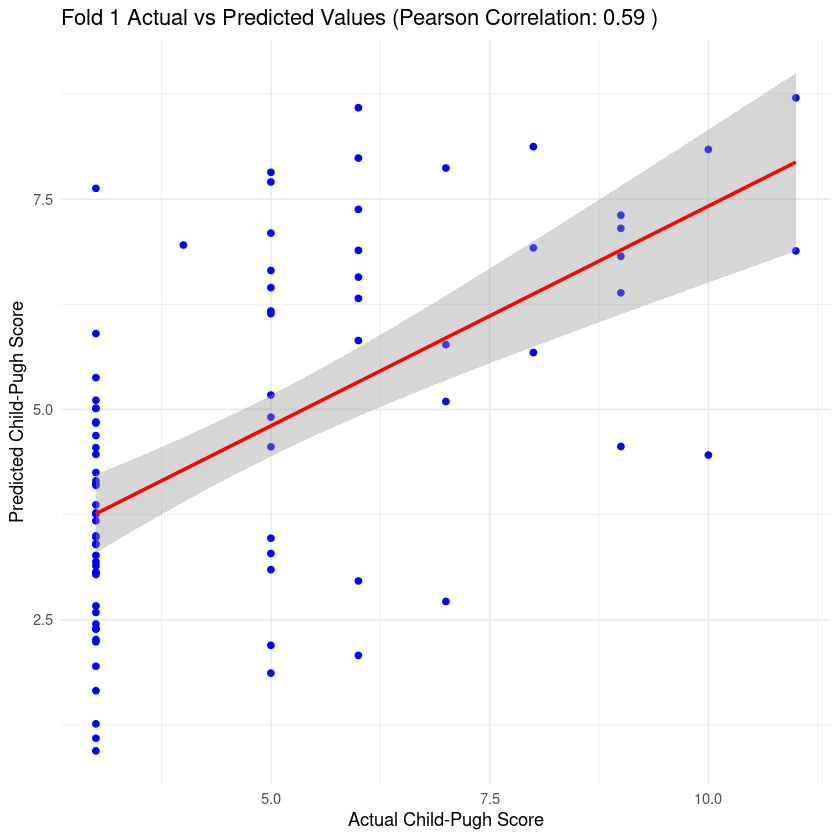

`geom_smooth()` using formula = 'y ~ x'
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 3 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 32 11  3  0
         2 10  9  7  2
         3  0  4  2  2
         4  0  0  0  0

Overall Statistics
                                          
               Accuracy : 0.5244          
                 95% CI : (0.4111, 0.6359)
    No Information Rate : 0.5122          
    P-Value [Acc > NIR] : 0.4564          
                                          
                  Kappa : 0.2053          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.7619   0.3750  0.16667  0.00000
Specificity            0.6500   0.6724  0.91429  1.00000
Pos Pred Value         0.6957   0.3214  0.25000      NaN
Neg Pred Value         0.7222   0.7222  0.86486  0.95122
Prevalence             0.5122   0.2927  0.14634  0.04878
Detection Rate         0.3902   0.1

Warning message:
“Zero sample variances detected, have been offset away from zero”


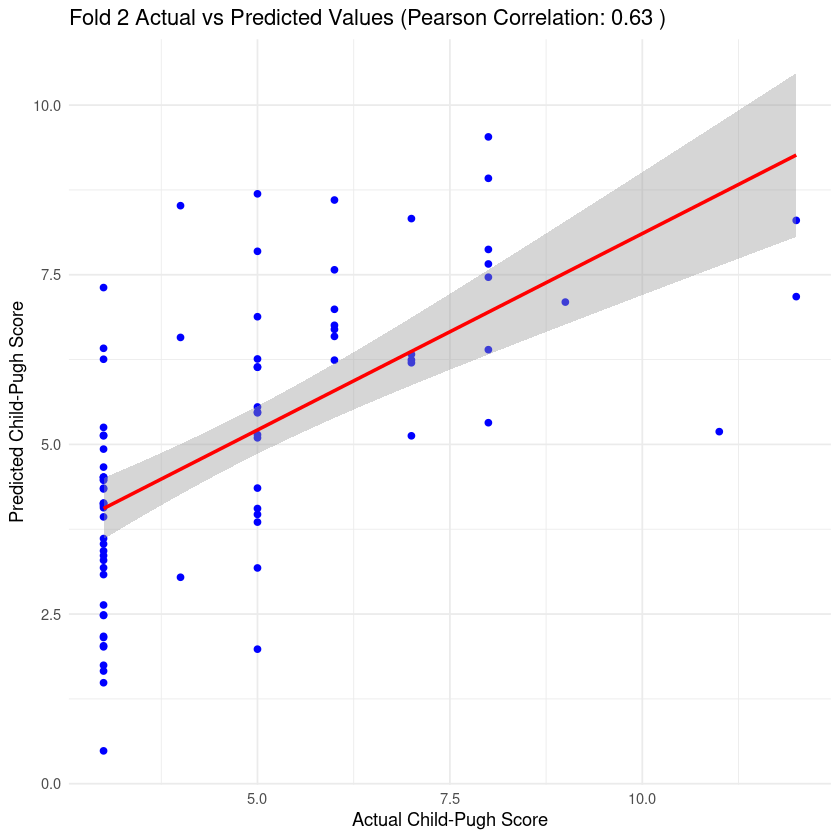

`geom_smooth()` using formula = 'y ~ x'
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 4 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 28  7  0  0
         2 10  9  7  0
         3  4  6  5  3
         4  0  1  0  1

Overall Statistics
                                          
               Accuracy : 0.5309          
                 95% CI : (0.4167, 0.6427)
    No Information Rate : 0.5185          
    P-Value [Acc > NIR] : 0.4563          
                                          
                  Kappa : 0.279           
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.6667   0.3913  0.41667  0.25000
Specificity            0.8205   0.7069  0.81159  0.98701
Pos Pred Value         0.8000   0.3462  0.27778  0.50000
Neg Pred Value         0.6957   0.7455  0.88889  0.96203
Prevalence             0.5185   0.2840  0.14815  0.04938
Detection Rate         0.3457   0.1

Warning message:
“Zero sample variances detected, have been offset away from zero”


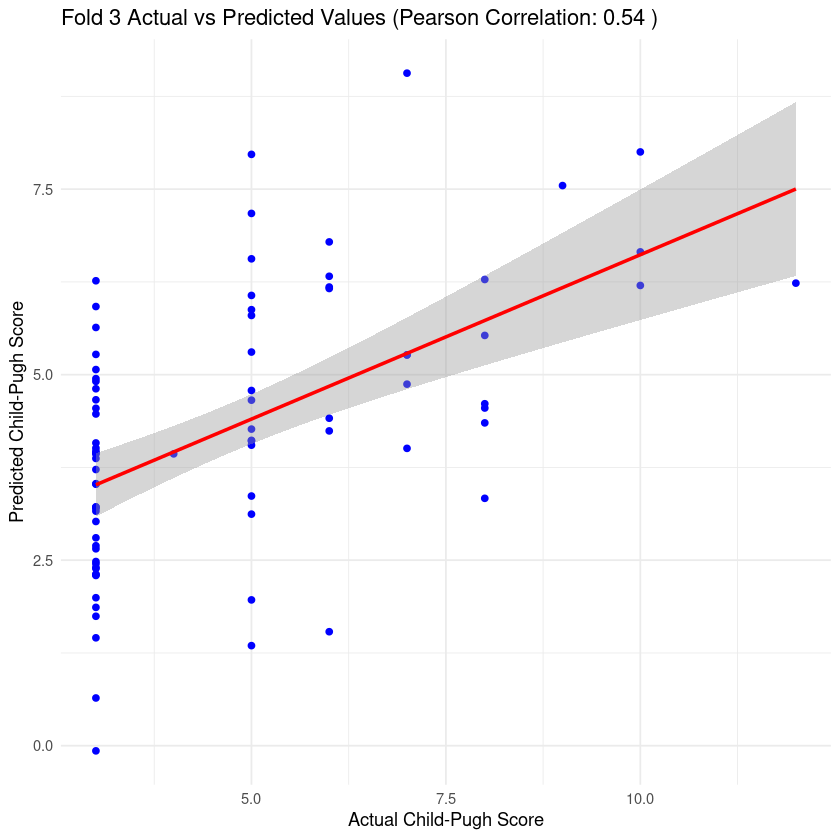

`geom_smooth()` using formula = 'y ~ x'
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



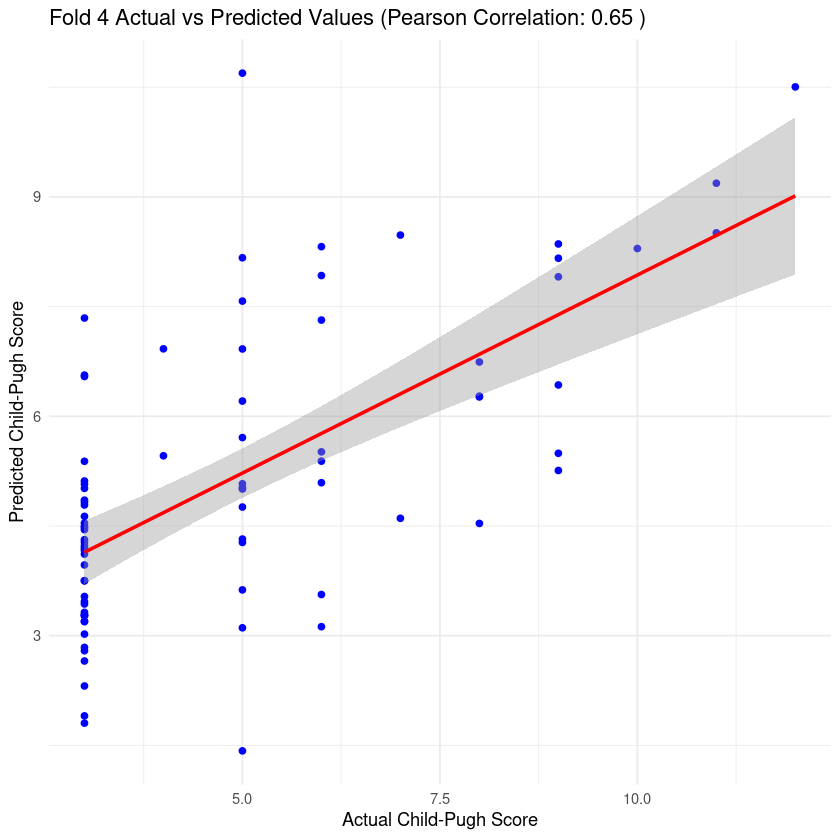

Fold 5 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 32  5  1  0
         2  8  9  5  0
         3  2  8  6  2
         4  0  1  0  1

Overall Statistics
                                         
               Accuracy : 0.6            
                 95% CI : (0.4844, 0.708)
    No Information Rate : 0.525          
    P-Value [Acc > NIR] : 0.1088         
                                         
                  Kappa : 0.3719         
                                         
 Mcnemar's Test P-Value : NA             

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.7619   0.3913   0.5000   0.3333
Specificity            0.8421   0.7719   0.8235   0.9870
Pos Pred Value         0.8421   0.4091   0.3333   0.5000
Neg Pred Value         0.7619   0.7586   0.9032   0.9744
Prevalence             0.5250   0.2875   0.1500   0.0375
Detection Rate         0.4000   0.1125   0.0

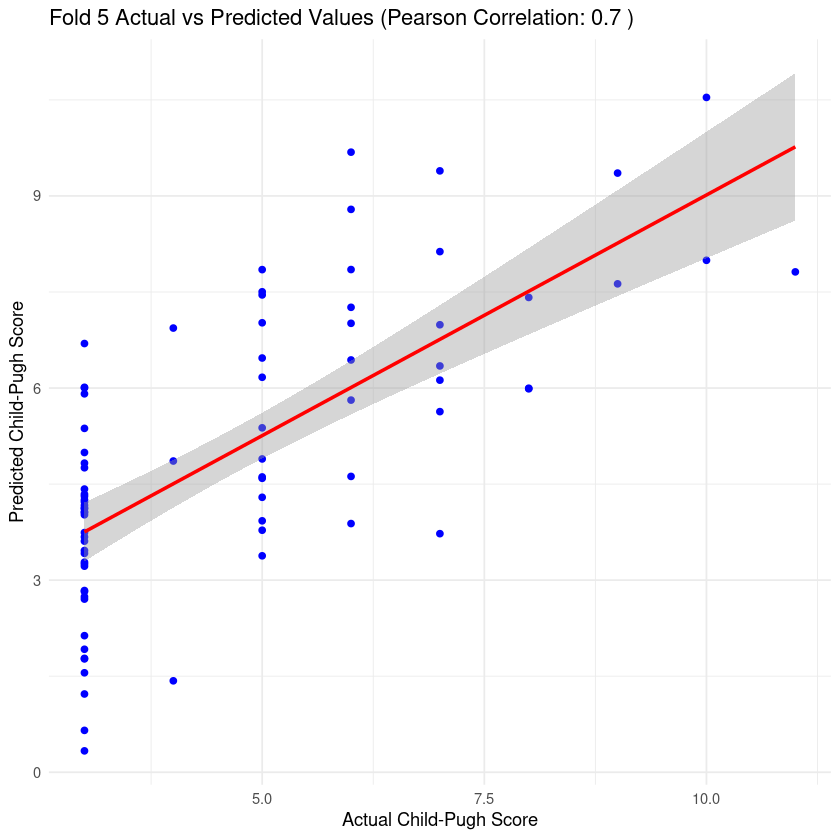

In [45]:
library(caret)
library(pROC)
library(ggplot2)

# Define classification thresholds
classify <- function(value) {
  if (value < 4.5) {
    return(1)
  } else if (value >= 4.5 & value < 6.5) {
    return(2)
  } else if (value >= 6.5 & value < 9.5) {
    return(3)
  } else if (value >= 9.5 & value < 15) {
    return(4)
  } else {
    return(5)
  }
}

# Number of folds
k <- 5

# Initialize lists to store results
all_conf_matrices <- list()
all_auc <- numeric(k)
all_accuracy <- numeric(k)
all_sensitivity <- numeric(k)
all_specificity <- numeric(k)
all_predictions_vs_actual <- vector("list", k)
all_classified_predictions <- vector()
all_classified_actuals <- vector()

# Create k-fold cross-validation indices
folds <- createFolds(combined_data_clean$child_pugh_score, k = k, list = TRUE, returnTrain = TRUE)

for (i in 1:k) {
    training_set <- training_sets[[i]]
    testing_set <- testing_sets[[i]]

    # Ensure the column names are correct for column removal
    columns_to_remove <- colnames(filtered_pheno_data)
    columns_to_remove <- c(columns_to_remove, "rowname") # Adjust if needed

    # Remove specified columns from the training data
    methylation_training_data_filtered <- training_set[, !colnames(training_set) %in% columns_to_remove]

    # Create the design matrix
    design_train <- model.matrix(~ child_pugh_score, data = training_set)

    # Remove 'child_pugh_score' column from methylation data
    methylation_data_no_child_pugh <- methylation_training_data_filtered[, !colnames(methylation_training_data_filtered) %in% "child_pugh_score"]

    # Fit the linear model
    fit <- lmFit(t(methylation_data_no_child_pugh), design_train)
    fit <- eBayes(fit)

    # Get top 100 significant markers
    top_100_results <- topTable(fit, coef = 2, number = 100)
    top_100_markers <- rownames(top_100_results)

    # Filter training and testing data to include only the top 100 markers
    training_set_filtered <- training_set[, c("child_pugh_score", top_100_markers)]
    testing_set_filtered <- testing_set[, c("child_pugh_score", top_100_markers)]

    # Fit the linear model using the filtered training data
    model <- lm(child_pugh_score ~ ., data = training_set_filtered)

    # Predict on the filtered testing set
    predictions <- predict(model, newdata = testing_set_filtered)

    # Classify predictions and actual values
    classified_predictions <- sapply(predictions, classify)
    classified_actuals <- sapply(testing_set$child_pugh_score, classify)

    # Ensure they are factors with levels 1, 2, 3, 4
    classified_predictions <- factor(classified_predictions, levels = 1:4)
    classified_actuals <- factor(classified_actuals, levels = 1:4)

    # Check for NA values in classified predictions and actual values
    valid_indices <- !is.na(classified_predictions) & !is.na(classified_actuals)
    classified_predictions <- classified_predictions[valid_indices]
    classified_actuals <- classified_actuals[valid_indices]

    # Store actual, predicted, and rounded predicted values
    all_predictions_vs_actual[[i]] <- data.frame(
      Actual = testing_set$child_pugh_score[valid_indices], 
      Predicted = predictions[valid_indices]
    )

    # Calculate Pearson correlation
    pearson_correlation <- cor(all_predictions_vs_actual[[i]]$Actual, all_predictions_vs_actual[[i]]$Predicted)

    # Create the plot
    plot <- ggplot(all_predictions_vs_actual[[i]], aes(x = Actual, y = Predicted)) +
      geom_point(color = "blue") +
      geom_smooth(method = "lm", color = "red") +  
      xlab("Actual Child-Pugh Score") +
      ylab("Predicted Child-Pugh Score") +
      ggtitle(paste("Fold", i, "Actual vs Predicted Values (Pearson Correlation:", round(pearson_correlation, 2), ")")) +
      theme_minimal()

    # Print the plot
    print(plot)

    # Accumulate classified predictions and actuals for overall confusion matrix
    all_classified_predictions <- c(all_classified_predictions, classified_predictions)
    all_classified_actuals <- c(all_classified_actuals, classified_actuals)

    # Create a confusion matrix for this fold
    conf_matrix <- confusionMatrix(classified_predictions, classified_actuals)
    all_conf_matrices[[i]] <- conf_matrix

    # Calculate and store accuracy
    accuracy <- sum(classified_predictions == classified_actuals) / length(classified_actuals)
    all_accuracy[i] <- accuracy

    # Calculate and store AUC
    roc_multiclass <- multiclass.roc(classified_actuals, as.numeric(classified_predictions))
    auc_value <- auc(roc_multiclass)
    all_auc[i] <- auc_value

    # Extract sensitivity and specificity from the confusion matrix
    sensitivity_by_class <- conf_matrix$byClass[,"Sensitivity"]
    overall_sensitivity <- mean(sensitivity_by_class, na.rm = TRUE)
    all_sensitivity[i] <- overall_sensitivity

    specificity_by_class <- conf_matrix$byClass[,"Specificity"]
    overall_specificity <- mean(specificity_by_class, na.rm = TRUE)
    all_specificity[i] <- overall_specificity

    # Print results for the current fold
    cat(paste("Fold", i, "Confusion Matrix:\n"))
    print(conf_matrix)
    cat(paste("Fold", i, "Accuracy:", accuracy, "\n"))
    cat(paste("Fold", i, "AUC:", auc_value, "\n"))
    cat(paste("Fold", i, "Overall Sensitivity:", overall_sensitivity, "\n"))
    cat(paste("Fold", i, "Overall Specificity:", overall_specificity, "\n"))
}

# Create overall confusion matrix
overall_conf_matrix <- confusionMatrix(factor(all_classified_predictions, levels = 1:4), 
                                       factor(all_classified_actuals, levels = 1:4))

# Print the overall confusion matrix
cat("Overall Confusion Matrix across all folds:\n")
print(overall_conf_matrix)

# Print aggregate results
cat("Aggregate Results Across All Folds:\n")
cat("Average Accuracy:", mean(all_accuracy), "\n")
cat("Average AUC:", mean(all_auc), "\n")
cat("Average Sensitivity:", mean(all_sensitivity), "\n")
cat("Average Specificity:", mean(all_specificity), "\n")


# Truncating 100 Markers

In [27]:
library(caret)
library(pROC)
library(ggplot2)

# Define classification thresholds
classify <- function(value) {
  if (value < 5) {
    return(1)
  } else if (value >= 5 & value < 7) {
    return(2)
  } else if (value >= 7 & value < 10) {
    return(3)
  } else if (value >= 10 & value < 15) {
    return(4)
  } else {
    return(5)
  }
}

# Number of folds
k <- 5

# Initialize lists to store results
all_conf_matrices <- list()
all_auc <- numeric(k)
all_accuracy <- numeric(k)
all_sensitivity <- numeric(k)
all_specificity <- numeric(k)
all_predictions_vs_actual <- list()  # Store actual vs predicted for each fold
pearson_correlations <- numeric(k)   # Store Pearson correlations for each fold

# Initialize vectors to store all predictions and actual values across folds
all_classified_predictions <- factor()  # Empty factor to accumulate predictions
all_classified_actuals <- factor()      # Empty factor to accumulate actual values

# Create k-fold cross-validation indices
folds <- createFolds(combined_data_clean$child_pugh_score, k = k, list = TRUE, returnTrain = TRUE)

# Perform k-fold cross-validation manually
for (i in 1:k) {
    training_set <- training_sets[[i]]
    testing_set <- testing_sets[[i]]

    # Ensure the column names are correct for column removal
    columns_to_remove <- colnames(filtered_pheno_data)
    columns_to_remove <- c(columns_to_remove, "rowname") # Adjust if needed

    # Remove specified columns from the training data
    methylation_training_data_filtered <- training_set[, !colnames(training_set) %in% columns_to_remove]

    # Create the design matrix
    design_train <- model.matrix(~ child_pugh_score, data = training_set)

    # Remove 'child_pugh_score' column from methylation data
    methylation_data_no_child_pugh <- methylation_training_data_filtered[, !colnames(methylation_training_data_filtered) %in% "child_pugh_score"]

    # Fit the linear model
    fit <- lmFit(t(methylation_data_no_child_pugh), design_train)
    fit <- eBayes(fit)

   # Get top 100 significant markers
    top_100_results <- topTable(fit, coef = 2, number = 100)
    top_100_markers <- rownames(top_100_results)
    
    # Filter training and testing data to include only the top 100 markers
    training_set_filtered <- training_set[, c("child_pugh_score", top_100_markers)]
    testing_set_filtered <- testing_set[, c("child_pugh_score", top_100_markers)]

    # Fit the linear model using the filtered training data
    model <- lm(child_pugh_score ~ ., data = training_set_filtered)

    # Predict on the filtered testing set
    predictions <- predict(model, newdata = testing_set_filtered)

    # Calculate Pearson correlation between actual and predicted values
    pearson_corr <- cor(testing_set$child_pugh_score, predictions)
    pearson_correlations[i] <- pearson_corr

    # Truncate the predicted values before classification
    truncated_predictions <- floor(predictions)

    # Classify predictions and actual values
    classified_predictions <- sapply(truncated_predictions, classify)
    classified_actuals <- sapply(testing_set$child_pugh_score, classify)

    # Ensure they are factors with levels 1, 2, 3, 4
    classified_predictions <- factor(classified_predictions, levels = 1:4)
    classified_actuals <- factor(classified_actuals, levels = 1:4)


    # Check for NA values in classified predictions and actual values
    valid_indices <- !is.na(classified_predictions) & !is.na(classified_actuals)
    classified_predictions <- classified_predictions[valid_indices]
    classified_actuals <- classified_actuals[valid_indices]

    # Store actual, predicted, and rounded predicted values
    all_predictions_vs_actual[[i]] <- data.frame(
      Actual = testing_set$child_pugh_score[valid_indices], 
      Predicted = predictions[valid_indices],
      Truncated_Predicted = truncated_predictions[valid_indices]
    )

    # Accumulate classified predictions and actuals for overall confusion matrix
    all_classified_predictions <- c(all_classified_predictions, classified_predictions)
    all_classified_actuals <- c(all_classified_actuals, classified_actuals)

    # Create a confusion matrix for this fold
    conf_matrix <- confusionMatrix(classified_predictions, classified_actuals)
    all_conf_matrices[[i]] <- conf_matrix

    # Calculate and store accuracy
    accuracy <- sum(classified_predictions == classified_actuals) / length(classified_actuals)
    all_accuracy[i] <- accuracy

    # Calculate and store AUC
    roc_multiclass <- multiclass.roc(classified_actuals, as.numeric(classified_predictions))
    auc_value <- auc(roc_multiclass)
    all_auc[i] <- auc_value

    # Extract sensitivity and specificity from the confusion matrix
    sensitivity_by_class <- conf_matrix$byClass[,"Sensitivity"]
    overall_sensitivity <- mean(sensitivity_by_class, na.rm = TRUE)
    all_sensitivity[i] <- overall_sensitivity

    specificity_by_class <- conf_matrix$byClass[,"Specificity"]
    overall_specificity <- mean(specificity_by_class, na.rm = TRUE)
    all_specificity[i] <- overall_specificity

    # Print results for the current fold
    cat(paste("Fold", i, "Confusion Matrix:\n"))
    print(conf_matrix)
    cat(paste("Fold", i, "Accuracy:", accuracy, "\n"))
    cat(paste("Fold", i, "AUC:", auc_value, "\n"))
    cat(paste("Fold", i, "Overall Sensitivity:", overall_sensitivity, "\n"))
    cat(paste("Fold", i, "Overall Specificity:", overall_specificity, "\n"))
    cat(paste("Fold", i, "Pearson Correlation between Actual vs Predicted:", pearson_corr, "\n"))

    # Print actual, predicted, and rounded predicted values
    cat(paste("Fold", i, "Actual vs Predicted vs Rounded Predicted values:\n"))
    print(all_predictions_vs_actual[[i]])

    # Plot Actual vs Predicted values
    ggplot(data = all_predictions_vs_actual[[i]], aes(x = Actual, y = Predicted)) +
      geom_point(color = "darkred") +
      geom_smooth(method = "lm", color = "lightcoral", se = FALSE) +
      ggtitle(paste("Fold", i, "Actual vs Predicted Values")) +
      xlab("Actual Values") +
      ylab("Predicted Values") +
      theme_minimal() +
      theme(plot.title = element_text(hjust = 0.5))
}

# Create overall confusion matrix
overall_conf_matrix <- confusionMatrix(all_classified_predictions, all_classified_actuals)

# Print the overall confusion matrix
cat("Overall Confusion Matrix across all folds:\n")
print(overall_conf_matrix)

# Print aggregate results
cat("Aggregate Results Across All Folds:\n")
cat("Average Accuracy:", mean(all_accuracy), "\n")
cat("Average AUC:", mean(all_auc), "\n")
cat("Average Sensitivity:", mean(all_sensitivity), "\n")
cat("Average Specificity:", mean(all_specificity), "\n")
cat("Average Pearson Correlation:", mean(pearson_correlations), "\n")


Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 1 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 35  9  2  1
         2  6  9  6  1
         3  1  6  4  2
         4  0  0  0  0

Overall Statistics
                                          
               Accuracy : 0.5854          
                 95% CI : (0.4712, 0.6932)
    No Information Rate : 0.5122          
    P-Value [Acc > NIR] : 0.1120          
                                          
                  Kappa : 0.3143          
                                          
 Mcnemar's Test P-Value : 0.5524          

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.8333   0.3750  0.33333  0.00000
Specificity            0.7000   0.7759  0.87143  1.00000
Pos Pred Value         0.7447   0.4091  0.30769      NaN
Neg Pred Value         0.8000   0.7500  0.88406  0.95122
Prevalence             0.5122   0.2927  0.14634  0.04878
Detection Rate         0.4268   0.1

Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 2 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 34  6  0  0
         2  6 14  6  1
         3  2  4  7  2
         4  0  0  0  0

Overall Statistics
                                          
               Accuracy : 0.6707          
                 95% CI : (0.5581, 0.7706)
    No Information Rate : 0.5122          
    P-Value [Acc > NIR] : 0.002659        
                                          
                  Kappa : 0.473           
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.8095   0.5833  0.53846  0.00000
Specificity            0.8500   0.7759  0.88406  1.00000
Pos Pred Value         0.8500   0.5185  0.46667      NaN
Neg Pred Value         0.8095   0.8182  0.91045  0.96341
Prevalence             0.5122   0.2927  0.15854  0.03659
Detection Rate         0.4146   0.1

Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 3 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 37 13  6  0
         2  5  9  4  3
         3  0  2  2  1
         4  0  0  0  0

Overall Statistics
                                          
               Accuracy : 0.5854          
                 95% CI : (0.4712, 0.6932)
    No Information Rate : 0.5122          
    P-Value [Acc > NIR] : 0.112           
                                          
                  Kappa : 0.2679          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.8810   0.3750  0.16667  0.00000
Specificity            0.5250   0.7931  0.95714  1.00000
Pos Pred Value         0.6607   0.4286  0.40000      NaN
Neg Pred Value         0.8077   0.7541  0.87013  0.95122
Prevalence             0.5122   0.2927  0.14634  0.04878
Detection Rate         0.4512   0.1

Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 4 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 33  8  2  0
         2  8  9  6  0
         3  1  5  4  3
         4  0  1  0  1

Overall Statistics
                                          
               Accuracy : 0.5802          
                 95% CI : (0.4654, 0.6891)
    No Information Rate : 0.5185          
    P-Value [Acc > NIR] : 0.1585          
                                          
                  Kappa : 0.322           
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.7857   0.3913  0.33333  0.25000
Specificity            0.7436   0.7586  0.86957  0.98701
Pos Pred Value         0.7674   0.3913  0.30769  0.50000
Neg Pred Value         0.7632   0.7586  0.88235  0.96203
Prevalence             0.5185   0.2840  0.14815  0.04938
Detection Rate         0.4074   0.1

Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 5 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 36  9  1  0
         2  6  5  6  0
         3  0  9  5  2
         4  0  0  0  1

Overall Statistics
                                          
               Accuracy : 0.5875          
                 95% CI : (0.4718, 0.6965)
    No Information Rate : 0.525           
    P-Value [Acc > NIR] : 0.1568          
                                          
                  Kappa : 0.3199          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.8571   0.2174   0.4167   0.3333
Specificity            0.7368   0.7895   0.8382   1.0000
Pos Pred Value         0.7826   0.2941   0.3125   1.0000
Neg Pred Value         0.8235   0.7143   0.8906   0.9747
Prevalence             0.5250   0.2875   0.1500   0.0375
Detection Rate         0.4500   0.0

# 50 markers

In [29]:
library(caret)
library(pROC)
library(ggplot2)

# Define classification thresholds
classify <- function(value) {
  if (value < 5) {
    return(1)
  } else if (value >= 5 & value < 7) {
    return(2)
  } else if (value >= 7 & value < 10) {
    return(3)
  } else if (value >= 10 & value < 15) {
    return(4)
  } else {
    return(5)
  }
}

# Number of folds
k <- 5

# Initialize lists to store results
all_conf_matrices <- list()
all_auc <- numeric(k)
all_accuracy <- numeric(k)
all_sensitivity <- numeric(k)
all_specificity <- numeric(k)
all_predictions_vs_actual <- list()  # Store actual vs predicted for each fold
pearson_correlations <- numeric(k)   # Store Pearson correlations for each fold

# Initialize vectors to store all predictions and actual values across folds
all_classified_predictions <- factor()  # Empty factor to accumulate predictions
all_classified_actuals <- factor()      # Empty factor to accumulate actual values

# Create k-fold cross-validation indices
folds <- createFolds(combined_data_clean$child_pugh_score, k = k, list = TRUE, returnTrain = TRUE)

# Perform k-fold cross-validation manually
for (i in 1:k) {
    training_set <- training_sets[[i]]
    testing_set <- testing_sets[[i]]

    # Ensure the column names are correct for column removal
    columns_to_remove <- colnames(filtered_pheno_data)
    columns_to_remove <- c(columns_to_remove, "rowname") # Adjust if needed

    # Remove specified columns from the training data
    methylation_training_data_filtered <- training_set[, !colnames(training_set) %in% columns_to_remove]

    # Create the design matrix
    design_train <- model.matrix(~ child_pugh_score, data = training_set)

    # Remove 'child_pugh_score' column from methylation data
    methylation_data_no_child_pugh <- methylation_training_data_filtered[, !colnames(methylation_training_data_filtered) %in% "child_pugh_score"]

    # Fit the linear model
    fit <- lmFit(t(methylation_data_no_child_pugh), design_train)
    fit <- eBayes(fit)

   # Get top 100 significant markers
    top_100_results <- topTable(fit, coef = 2, number = 50)
    top_100_markers <- rownames(top_100_results)
    
    # Filter training and testing data to include only the top 100 markers
    training_set_filtered <- training_set[, c("child_pugh_score", top_100_markers)]
    testing_set_filtered <- testing_set[, c("child_pugh_score", top_100_markers)]

    # Fit the linear model using the filtered training data
    model <- lm(child_pugh_score ~ ., data = training_set_filtered)

    # Predict on the filtered testing set
    predictions <- predict(model, newdata = testing_set_filtered)

    # Calculate Pearson correlation between actual and predicted values
    pearson_corr <- cor(testing_set$child_pugh_score, predictions)
    pearson_correlations[i] <- pearson_corr

    # Round the predicted values before classification
    rounded_predictions <- round(predictions)

    # Classify predictions and actual values
    classified_predictions <- sapply(rounded_predictions, classify)
    classified_actuals <- sapply(testing_set$child_pugh_score, classify)

    # Ensure they are factors with levels 1, 2, 3, 4
    classified_predictions <- factor(classified_predictions, levels = 1:4)
    classified_actuals <- factor(classified_actuals, levels = 1:4)

    # Check for NA values in classified predictions and actual values
    valid_indices <- !is.na(classified_predictions) & !is.na(classified_actuals)
    classified_predictions <- classified_predictions[valid_indices]
    classified_actuals <- classified_actuals[valid_indices]

    # Store actual, predicted, and rounded predicted values
    all_predictions_vs_actual[[i]] <- data.frame(
      Actual = testing_set$child_pugh_score[valid_indices], 
      Predicted = predictions[valid_indices],
      Rounded_Predicted = rounded_predictions[valid_indices]
    )

    # Accumulate classified predictions and actuals for overall confusion matrix
    all_classified_predictions <- c(all_classified_predictions, classified_predictions)
    all_classified_actuals <- c(all_classified_actuals, classified_actuals)

    # Create a confusion matrix for this fold
    conf_matrix <- confusionMatrix(classified_predictions, classified_actuals)
    all_conf_matrices[[i]] <- conf_matrix

    # Calculate and store accuracy
    accuracy <- sum(classified_predictions == classified_actuals) / length(classified_actuals)
    all_accuracy[i] <- accuracy

    # Calculate and store AUC
    roc_multiclass <- multiclass.roc(classified_actuals, as.numeric(classified_predictions))
    auc_value <- auc(roc_multiclass)
    all_auc[i] <- auc_value

    # Extract sensitivity and specificity from the confusion matrix
    sensitivity_by_class <- conf_matrix$byClass[,"Sensitivity"]
    overall_sensitivity <- mean(sensitivity_by_class, na.rm = TRUE)
    all_sensitivity[i] <- overall_sensitivity

    specificity_by_class <- conf_matrix$byClass[,"Specificity"]
    overall_specificity <- mean(specificity_by_class, na.rm = TRUE)
    all_specificity[i] <- overall_specificity

    # Print results for the current fold
    cat(paste("Fold", i, "Confusion Matrix:\n"))
    print(conf_matrix)
    cat(paste("Fold", i, "Accuracy:", accuracy, "\n"))
    cat(paste("Fold", i, "AUC:", auc_value, "\n"))
    cat(paste("Fold", i, "Overall Sensitivity:", overall_sensitivity, "\n"))
    cat(paste("Fold", i, "Overall Specificity:", overall_specificity, "\n"))
    cat(paste("Fold", i, "Pearson Correlation between Actual vs Predicted:", pearson_corr, "\n"))

    # Print actual, predicted, and rounded predicted values
    cat(paste("Fold", i, "Actual vs Predicted vs Rounded Predicted values:\n"))
    print(all_predictions_vs_actual[[i]])

    # Plot Actual vs Predicted values
    ggplot(data = all_predictions_vs_actual[[i]], aes(x = Actual, y = Predicted)) +
      geom_point(color = "darkred") +
      geom_smooth(method = "lm", color = "lightcoral", se = FALSE) +
      ggtitle(paste("Fold", i, "Actual vs Predicted Values")) +
      xlab("Actual Values") +
      ylab("Predicted Values") +
      theme_minimal() +
      theme(plot.title = element_text(hjust = 0.5))
}

# Create overall confusion matrix
overall_conf_matrix <- confusionMatrix(all_classified_predictions, all_classified_actuals)

# Print the overall confusion matrix
cat("Overall Confusion Matrix across all folds:\n")
print(overall_conf_matrix)

# Print aggregate results
cat("Aggregate Results Across All Folds:\n")
cat("Average Accuracy:", mean(all_accuracy), "\n")
cat("Average AUC:", mean(all_auc), "\n")
cat("Average Sensitivity:", mean(all_sensitivity), "\n")
cat("Average Specificity:", mean(all_specificity), "\n")
cat("Average Pearson Correlation:", mean(pearson_correlations), "\n")


Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 1 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 35  7  2  0
         2  7 14  4  1
         3  0  3  6  3
         4  0  0  0  0

Overall Statistics
                                          
               Accuracy : 0.6707          
                 95% CI : (0.5581, 0.7706)
    No Information Rate : 0.5122          
    P-Value [Acc > NIR] : 0.002659        
                                          
                  Kappa : 0.4611          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.8333   0.5833  0.50000  0.00000
Specificity            0.7750   0.7931  0.91429  1.00000
Pos Pred Value         0.7955   0.5385  0.50000      NaN
Neg Pred Value         0.8158   0.8214  0.91429  0.95122
Prevalence             0.5122   0.2927  0.14634  0.04878
Detection Rate         0.4268   0.1

Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 2 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 26  5  0  0
         2 15 12  5  1
         3  1  7  8  2
         4  0  0  0  0

Overall Statistics
                                         
               Accuracy : 0.561          
                 95% CI : (0.447, 0.6704)
    No Information Rate : 0.5122         
    P-Value [Acc > NIR] : 0.2199         
                                         
                  Kappa : 0.3285         
                                         
 Mcnemar's Test P-Value : NA             

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.6190   0.5000  0.61538  0.00000
Specificity            0.8750   0.6379  0.85507  1.00000
Pos Pred Value         0.8387   0.3636  0.44444      NaN
Neg Pred Value         0.6863   0.7551  0.92187  0.96341
Prevalence             0.5122   0.2927  0.15854  0.03659
Detection Rate         0.3171   0.1463  0.09

Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 3 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 34 11  2  0
         2  8 11  9  3
         3  0  2  1  1
         4  0  0  0  0

Overall Statistics
                                         
               Accuracy : 0.561          
                 95% CI : (0.447, 0.6704)
    No Information Rate : 0.5122         
    P-Value [Acc > NIR] : 0.2199         
                                         
                  Kappa : 0.2542         
                                         
 Mcnemar's Test P-Value : NA             

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.8095   0.4583  0.08333  0.00000
Specificity            0.6750   0.6552  0.95714  1.00000
Pos Pred Value         0.7234   0.3548  0.25000      NaN
Neg Pred Value         0.7714   0.7451  0.85897  0.95122
Prevalence             0.5122   0.2927  0.14634  0.04878
Detection Rate         0.4146   0.1341  0.01

Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 4 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 29  7  0  0
         2 12 11  5  0
         3  1  5  7  3
         4  0  0  0  1

Overall Statistics
                                          
               Accuracy : 0.5926          
                 95% CI : (0.4777, 0.7005)
    No Information Rate : 0.5185          
    P-Value [Acc > NIR] : 0.1104          
                                          
                  Kappa : 0.3649          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.6905   0.4783  0.58333  0.25000
Specificity            0.8205   0.7069  0.86957  1.00000
Pos Pred Value         0.8056   0.3929  0.43750  1.00000
Neg Pred Value         0.7111   0.7736  0.92308  0.96250
Prevalence             0.5185   0.2840  0.14815  0.04938
Detection Rate         0.3580   0.1

Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 5 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 32  4  1  0
         2  8 10  6  0
         3  2  8  3  2
         4  0  1  2  1

Overall Statistics
                                          
               Accuracy : 0.575           
                 95% CI : (0.4594, 0.6849)
    No Information Rate : 0.525           
    P-Value [Acc > NIR] : 0.2169          
                                          
                  Kappa : 0.3369          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.7619   0.4348   0.2500   0.3333
Specificity            0.8684   0.7544   0.8235   0.9610
Pos Pred Value         0.8649   0.4167   0.2000   0.2500
Neg Pred Value         0.7674   0.7679   0.8615   0.9737
Prevalence             0.5250   0.2875   0.1500   0.0375
Detection Rate         0.4000   0.1

# 50 markers Truncating

In [42]:
library(caret)
library(pROC)
library(ggplot2)

# Define classification thresholds
classify <- function(value) {
  if (value < 5) {
    return(1)
  } else if (value >= 5 & value < 7) {
    return(2)
  } else if (value >= 7 & value < 10) {
    return(3)
  } else if (value >= 10 & value < 15) {
    return(4)
  } else {
    return(5)
  }
}

# Number of folds
k <- 5

# Initialize lists to store results
all_conf_matrices <- list()
all_auc <- numeric(k)
all_accuracy <- numeric(k)
all_sensitivity <- numeric(k)
all_specificity <- numeric(k)
all_predictions_vs_actual <- list()  # Store actual vs predicted for each fold
pearson_correlations <- numeric(k)   # Store Pearson correlations for each fold

# Initialize vectors to store all predictions and actual values across folds
all_classified_predictions <- factor()  # Empty factor to accumulate predictions
all_classified_actuals <- factor()      # Empty factor to accumulate actual values

# Create k-fold cross-validation indices
folds <- createFolds(combined_data_clean$child_pugh_score, k = k, list = TRUE, returnTrain = TRUE)

# Perform k-fold cross-validation manually
for (i in 1:k) {
    training_set <- training_sets[[i]]
    testing_set <- testing_sets[[i]]

    # Ensure the column names are correct for column removal
    columns_to_remove <- colnames(filtered_pheno_data)
    columns_to_remove <- c(columns_to_remove, "rowname") # Adjust if needed

    # Remove specified columns from the training data
    methylation_training_data_filtered <- training_set[, !colnames(training_set) %in% columns_to_remove]

    # Create the design matrix
    design_train <- model.matrix(~ child_pugh_score, data = training_set)

    # Remove 'child_pugh_score' column from methylation data
    methylation_data_no_child_pugh <- methylation_training_data_filtered[, !colnames(methylation_training_data_filtered) %in% "child_pugh_score"]

    # Fit the linear model
    fit <- lmFit(t(methylation_data_no_child_pugh), design_train)
    fit <- eBayes(fit)

   # Get top 100 significant markers
    top_100_results <- topTable(fit, coef = 2, number = 50)
    top_100_markers <- rownames(top_100_results)
    
    # Filter training and testing data to include only the top 100 markers
    training_set_filtered <- training_set[, c("child_pugh_score", top_100_markers)]
    testing_set_filtered <- testing_set[, c("child_pugh_score", top_100_markers)]

    # Fit the linear model using the filtered training data
    model <- lm(child_pugh_score ~ ., data = training_set_filtered)

    # Predict on the filtered testing set
    predictions <- predict(model, newdata = testing_set_filtered)

    # Calculate Pearson correlation between actual and predicted values
    pearson_corr <- cor(testing_set$child_pugh_score, predictions)
    pearson_correlations[i] <- pearson_corr

    # Truncate the predicted values before classification
    truncated_predictions <- floor(predictions)

    # Classify predictions and actual values
    classified_predictions <- sapply(truncated_predictions, classify)
    classified_actuals <- sapply(testing_set$child_pugh_score, classify)

    # Ensure they are factors with levels 1, 2, 3, 4
    classified_predictions <- factor(classified_predictions, levels = 1:4)
    classified_actuals <- factor(classified_actuals, levels = 1:4)


    # Check for NA values in classified predictions and actual values
    valid_indices <- !is.na(classified_predictions) & !is.na(classified_actuals)
    classified_predictions <- classified_predictions[valid_indices]
    classified_actuals <- classified_actuals[valid_indices]

    # Store actual, predicted, and rounded predicted values
    all_predictions_vs_actual[[i]] <- data.frame(
      Actual = testing_set$child_pugh_score[valid_indices], 
      Predicted = predictions[valid_indices],
      Truncated_Predicted = truncated_predictions[valid_indices]
    )

    # Accumulate classified predictions and actuals for overall confusion matrix
    all_classified_predictions <- c(all_classified_predictions, classified_predictions)
    all_classified_actuals <- c(all_classified_actuals, classified_actuals)

    # Create a confusion matrix for this fold
    conf_matrix <- confusionMatrix(classified_predictions, classified_actuals)
    all_conf_matrices[[i]] <- conf_matrix

    # Calculate and store accuracy
    accuracy <- sum(classified_predictions == classified_actuals) / length(classified_actuals)
    all_accuracy[i] <- accuracy

    # Calculate and store AUC
    roc_multiclass <- multiclass.roc(classified_actuals, as.numeric(classified_predictions))
    auc_value <- auc(roc_multiclass)
    all_auc[i] <- auc_value

    # Extract sensitivity and specificity from the confusion matrix
    sensitivity_by_class <- conf_matrix$byClass[,"Sensitivity"]
    overall_sensitivity <- mean(sensitivity_by_class, na.rm = TRUE)
    all_sensitivity[i] <- overall_sensitivity

    specificity_by_class <- conf_matrix$byClass[,"Specificity"]
    overall_specificity <- mean(specificity_by_class, na.rm = TRUE)
    all_specificity[i] <- overall_specificity

    # Print results for the current fold
    cat(paste("Fold", i, "Confusion Matrix:\n"))
    print(conf_matrix)
    cat(paste("Fold", i, "Accuracy:", accuracy, "\n"))
    cat(paste("Fold", i, "AUC:", auc_value, "\n"))
    cat(paste("Fold", i, "Overall Sensitivity:", overall_sensitivity, "\n"))
    cat(paste("Fold", i, "Overall Specificity:", overall_specificity, "\n"))
    cat(paste("Fold", i, "Pearson Correlation between Actual vs Predicted:", pearson_corr, "\n"))

    # Print actual, predicted, and rounded predicted values
    cat(paste("Fold", i, "Actual vs Predicted vs Rounded Predicted values:\n"))
    print(all_predictions_vs_actual[[i]])

    # Plot Actual vs Predicted values
    ggplot(data = all_predictions_vs_actual[[i]], aes(x = Actual, y = Predicted)) +
      geom_point(color = "darkred") +
      geom_smooth(method = "lm", color = "lightcoral", se = FALSE) +
      ggtitle(paste("Fold", i, "Actual vs Predicted Values")) +
      xlab("Actual Values") +
      ylab("Predicted Values") +
      theme_minimal() +
      theme(plot.title = element_text(hjust = 0.5))
}

# Create overall confusion matrix
overall_conf_matrix <- confusionMatrix(all_classified_predictions, all_classified_actuals)

# Print the overall confusion matrix
cat("Overall Confusion Matrix across all folds:\n")
print(overall_conf_matrix)

# Print aggregate results
cat("Aggregate Results Across All Folds:\n")
cat("Average Accuracy:", mean(all_accuracy), "\n")
cat("Average AUC:", mean(all_auc), "\n")
cat("Average Sensitivity:", mean(all_sensitivity), "\n")
cat("Average Specificity:", mean(all_specificity), "\n")
cat("Average Pearson Correlation:", mean(pearson_correlations), "\n")


Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 1 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 38  9  2  1
         2  4 13  6  0
         3  0  2  4  3
         4  0  0  0  0

Overall Statistics
                                          
               Accuracy : 0.6707          
                 95% CI : (0.5581, 0.7706)
    No Information Rate : 0.5122          
    P-Value [Acc > NIR] : 0.002659        
                                          
                  Kappa : 0.4415          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.9048   0.5417  0.33333  0.00000
Specificity            0.7000   0.8276  0.92857  1.00000
Pos Pred Value         0.7600   0.5652  0.44444      NaN
Neg Pred Value         0.8750   0.8136  0.89041  0.95122
Prevalence             0.5122   0.2927  0.14634  0.04878
Detection Rate         0.4634   0.1

Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 2 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 34  8  1  0
         2  8 11  4  1
         3  0  5  8  2
         4  0  0  0  0

Overall Statistics
                                         
               Accuracy : 0.6463         
                 95% CI : (0.533, 0.7488)
    No Information Rate : 0.5122         
    P-Value [Acc > NIR] : 0.009787       
                                         
                  Kappa : 0.4266         
                                         
 Mcnemar's Test P-Value : NA             

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.8095   0.4583  0.61538  0.00000
Specificity            0.7750   0.7759  0.89855  1.00000
Pos Pred Value         0.7907   0.4583  0.53333      NaN
Neg Pred Value         0.7949   0.7759  0.92537  0.96341
Prevalence             0.5122   0.2927  0.15854  0.03659
Detection Rate         0.4146   0.1341  0.09

Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 3 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 37 15  3  1
         2  5  8  8  2
         3  0  1  1  1
         4  0  0  0  0

Overall Statistics
                                         
               Accuracy : 0.561          
                 95% CI : (0.447, 0.6704)
    No Information Rate : 0.5122         
    P-Value [Acc > NIR] : 0.219893       
                                         
                  Kappa : 0.2199         
                                         
 Mcnemar's Test P-Value : 0.007781       

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.8810  0.33333  0.08333  0.00000
Specificity            0.5250  0.74138  0.97143  1.00000
Pos Pred Value         0.6607  0.34783  0.33333      NaN
Neg Pred Value         0.8077  0.72881  0.86076  0.95122
Prevalence             0.5122  0.29268  0.14634  0.04878
Detection Rate         0.4512  0.09756  0.01

Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 4 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 32 11  2  0
         2 10  9  6  0
         3  0  3  4  3
         4  0  0  0  1

Overall Statistics
                                          
               Accuracy : 0.5679          
                 95% CI : (0.4531, 0.6776)
    No Information Rate : 0.5185          
    P-Value [Acc > NIR] : 0.2185          
                                          
                  Kappa : 0.2863          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.7619   0.3913  0.33333  0.25000
Specificity            0.6667   0.7241  0.91304  1.00000
Pos Pred Value         0.7111   0.3600  0.40000  1.00000
Neg Pred Value         0.7222   0.7500  0.88732  0.96250
Prevalence             0.5185   0.2840  0.14815  0.04938
Detection Rate         0.3951   0.1

Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 5 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 37  5  2  0
         2  3 13  5  0
         3  2  5  5  2
         4  0  0  0  1

Overall Statistics
                                          
               Accuracy : 0.7             
                 95% CI : (0.5872, 0.7974)
    No Information Rate : 0.525           
    P-Value [Acc > NIR] : 0.001086        
                                          
                  Kappa : 0.5074          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.8810   0.5652   0.4167   0.3333
Specificity            0.8158   0.8596   0.8676   1.0000
Pos Pred Value         0.8409   0.6190   0.3571   1.0000
Neg Pred Value         0.8611   0.8305   0.8939   0.9747
Prevalence             0.5250   0.2875   0.1500   0.0375
Detection Rate         0.4625   0.1

# 25 Markers

In [43]:
library(caret)
library(pROC)
library(ggplot2)

# Define classification thresholds
classify <- function(value) {
  if (value < 5) {
    return(1)
  } else if (value >= 5 & value < 7) {
    return(2)
  } else if (value >= 7 & value < 10) {
    return(3)
  } else if (value >= 10 & value < 15) {
    return(4)
  } else {
    return(5)
  }
}

# Number of folds
k <- 5

# Initialize lists to store results
all_conf_matrices <- list()
all_auc <- numeric(k)
all_accuracy <- numeric(k)
all_sensitivity <- numeric(k)
all_specificity <- numeric(k)
all_predictions_vs_actual <- list()  # Store actual vs predicted for each fold
pearson_correlations <- numeric(k)   # Store Pearson correlations for each fold

# Initialize vectors to store all predictions and actual values across folds
all_classified_predictions <- factor()  # Empty factor to accumulate predictions
all_classified_actuals <- factor()      # Empty factor to accumulate actual values

# Create k-fold cross-validation indices
folds <- createFolds(combined_data_clean$child_pugh_score, k = k, list = TRUE, returnTrain = TRUE)

# Perform k-fold cross-validation manually
for (i in 1:k) {
    training_set <- training_sets[[i]]
    testing_set <- testing_sets[[i]]

    # Ensure the column names are correct for column removal
    columns_to_remove <- colnames(filtered_pheno_data)
    columns_to_remove <- c(columns_to_remove, "rowname") # Adjust if needed

    # Remove specified columns from the training data
    methylation_training_data_filtered <- training_set[, !colnames(training_set) %in% columns_to_remove]

    # Create the design matrix
    design_train <- model.matrix(~ child_pugh_score, data = training_set)

    # Remove 'child_pugh_score' column from methylation data
    methylation_data_no_child_pugh <- methylation_training_data_filtered[, !colnames(methylation_training_data_filtered) %in% "child_pugh_score"]

    # Fit the linear model
    fit <- lmFit(t(methylation_data_no_child_pugh), design_train)
    fit <- eBayes(fit)

   # Get top 100 significant markers
    top_100_results <- topTable(fit, coef = 2, number = 25)
    top_100_markers <- rownames(top_100_results)
    
    # Filter training and testing data to include only the top 100 markers
    training_set_filtered <- training_set[, c("child_pugh_score", top_100_markers)]
    testing_set_filtered <- testing_set[, c("child_pugh_score", top_100_markers)]

    # Fit the linear model using the filtered training data
    model <- lm(child_pugh_score ~ ., data = training_set_filtered)

    # Predict on the filtered testing set
    predictions <- predict(model, newdata = testing_set_filtered)

    # Calculate Pearson correlation between actual and predicted values
    pearson_corr <- cor(testing_set$child_pugh_score, predictions)
    pearson_correlations[i] <- pearson_corr

    # Round the predicted values before classification
    rounded_predictions <- round(predictions)

    # Classify predictions and actual values
    classified_predictions <- sapply(rounded_predictions, classify)
    classified_actuals <- sapply(testing_set$child_pugh_score, classify)

    # Ensure they are factors with levels 1, 2, 3, 4
    classified_predictions <- factor(classified_predictions, levels = 1:4)
    classified_actuals <- factor(classified_actuals, levels = 1:4)

    # Check for NA values in classified predictions and actual values
    valid_indices <- !is.na(classified_predictions) & !is.na(classified_actuals)
    classified_predictions <- classified_predictions[valid_indices]
    classified_actuals <- classified_actuals[valid_indices]

    # Store actual, predicted, and rounded predicted values
    all_predictions_vs_actual[[i]] <- data.frame(
      Actual = testing_set$child_pugh_score[valid_indices], 
      Predicted = predictions[valid_indices],
      Rounded_Predicted = rounded_predictions[valid_indices]
    )

    # Accumulate classified predictions and actuals for overall confusion matrix
    all_classified_predictions <- c(all_classified_predictions, classified_predictions)
    all_classified_actuals <- c(all_classified_actuals, classified_actuals)

    # Create a confusion matrix for this fold
    conf_matrix <- confusionMatrix(classified_predictions, classified_actuals)
    all_conf_matrices[[i]] <- conf_matrix

    # Calculate and store accuracy
    accuracy <- sum(classified_predictions == classified_actuals) / length(classified_actuals)
    all_accuracy[i] <- accuracy

    # Calculate and store AUC
    roc_multiclass <- multiclass.roc(classified_actuals, as.numeric(classified_predictions))
    auc_value <- auc(roc_multiclass)
    all_auc[i] <- auc_value

    # Extract sensitivity and specificity from the confusion matrix
    sensitivity_by_class <- conf_matrix$byClass[,"Sensitivity"]
    overall_sensitivity <- mean(sensitivity_by_class, na.rm = TRUE)
    all_sensitivity[i] <- overall_sensitivity

    specificity_by_class <- conf_matrix$byClass[,"Specificity"]
    overall_specificity <- mean(specificity_by_class, na.rm = TRUE)
    all_specificity[i] <- overall_specificity

    # Print results for the current fold
    cat(paste("Fold", i, "Confusion Matrix:\n"))
    print(conf_matrix)
    cat(paste("Fold", i, "Accuracy:", accuracy, "\n"))
    cat(paste("Fold", i, "AUC:", auc_value, "\n"))
    cat(paste("Fold", i, "Overall Sensitivity:", overall_sensitivity, "\n"))
    cat(paste("Fold", i, "Overall Specificity:", overall_specificity, "\n"))
    cat(paste("Fold", i, "Pearson Correlation between Actual vs Predicted:", pearson_corr, "\n"))

    # Print actual, predicted, and rounded predicted values
    cat(paste("Fold", i, "Actual vs Predicted vs Rounded Predicted values:\n"))
    print(all_predictions_vs_actual[[i]])

    # Plot Actual vs Predicted values
    ggplot(data = all_predictions_vs_actual[[i]], aes(x = Actual, y = Predicted)) +
      geom_point(color = "darkred") +
      geom_smooth(method = "lm", color = "lightcoral", se = FALSE) +
      ggtitle(paste("Fold", i, "Actual vs Predicted Values")) +
      xlab("Actual Values") +
      ylab("Predicted Values") +
      theme_minimal() +
      theme(plot.title = element_text(hjust = 0.5))
}

# Create overall confusion matrix
overall_conf_matrix <- confusionMatrix(all_classified_predictions, all_classified_actuals)

# Print the overall confusion matrix
cat("Overall Confusion Matrix across all folds:\n")
print(overall_conf_matrix)

# Print aggregate results
cat("Aggregate Results Across All Folds:\n")
cat("Average Accuracy:", mean(all_accuracy), "\n")
cat("Average AUC:", mean(all_auc), "\n")
cat("Average Sensitivity:", mean(all_sensitivity), "\n")
cat("Average Specificity:", mean(all_specificity), "\n")
cat("Average Pearson Correlation:", mean(pearson_correlations), "\n")


Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 1 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 34  7  0  0
         2  8 13  7  1
         3  0  4  5  3
         4  0  0  0  0

Overall Statistics
                                          
               Accuracy : 0.6341          
                 95% CI : (0.5205, 0.7378)
    No Information Rate : 0.5122          
    P-Value [Acc > NIR] : 0.01746         
                                          
                  Kappa : 0.4089          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.8095   0.5417  0.41667  0.00000
Specificity            0.8250   0.7241  0.90000  1.00000
Pos Pred Value         0.8293   0.4483  0.41667      NaN
Neg Pred Value         0.8049   0.7925  0.90000  0.95122
Prevalence             0.5122   0.2927  0.14634  0.04878
Detection Rate         0.4146   0.1

Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 2 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 29  4  0  1
         2 11 14  8  1
         3  2  6  5  1
         4  0  0  0  0

Overall Statistics
                                          
               Accuracy : 0.5854          
                 95% CI : (0.4712, 0.6932)
    No Information Rate : 0.5122          
    P-Value [Acc > NIR] : 0.1120          
                                          
                  Kappa : 0.3513          
                                          
 Mcnemar's Test P-Value : 0.2004          

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.6905   0.5833  0.38462  0.00000
Specificity            0.8750   0.6552  0.86957  1.00000
Pos Pred Value         0.8529   0.4118  0.35714      NaN
Neg Pred Value         0.7292   0.7917  0.88235  0.96341
Prevalence             0.5122   0.2927  0.15854  0.03659
Detection Rate         0.3537   0.1

Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 3 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 33 12  1  0
         2  9 10 10  3
         3  0  2  1  1
         4  0  0  0  0

Overall Statistics
                                         
               Accuracy : 0.5366         
                 95% CI : (0.423, 0.6475)
    No Information Rate : 0.5122         
    P-Value [Acc > NIR] : 0.3706         
                                         
                  Kappa : 0.2163         
                                         
 Mcnemar's Test P-Value : NA             

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.7857   0.4167  0.08333  0.00000
Specificity            0.6750   0.6207  0.95714  1.00000
Pos Pred Value         0.7174   0.3125  0.25000      NaN
Neg Pred Value         0.7500   0.7200  0.85897  0.95122
Prevalence             0.5122   0.2927  0.14634  0.04878
Detection Rate         0.4024   0.1220  0.01

Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 4 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 28  8  1  0
         2 14 11  5  0
         3  0  4  6  3
         4  0  0  0  1

Overall Statistics
                                          
               Accuracy : 0.5679          
                 95% CI : (0.4531, 0.6776)
    No Information Rate : 0.5185          
    P-Value [Acc > NIR] : 0.2185          
                                          
                  Kappa : 0.318           
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.6667   0.4783  0.50000  0.25000
Specificity            0.7692   0.6724  0.89855  1.00000
Pos Pred Value         0.7568   0.3667  0.46154  1.00000
Neg Pred Value         0.6818   0.7647  0.91176  0.96250
Prevalence             0.5185   0.2840  0.14815  0.04938
Detection Rate         0.3457   0.1

Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 5 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 31  7  1  0
         2  9  9  6  1
         3  2  6  4  1
         4  0  1  1  1

Overall Statistics
                                         
               Accuracy : 0.5625         
                 95% CI : (0.447, 0.6732)
    No Information Rate : 0.525          
    P-Value [Acc > NIR] : 0.2884         
                                         
                  Kappa : 0.3038         
                                         
 Mcnemar's Test P-Value : NA             

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.7381   0.3913   0.3333   0.3333
Specificity            0.7895   0.7193   0.8676   0.9740
Pos Pred Value         0.7949   0.3600   0.3077   0.3333
Neg Pred Value         0.7317   0.7455   0.8806   0.9740
Prevalence             0.5250   0.2875   0.1500   0.0375
Detection Rate         0.3875   0.1125   0.0

In [44]:
library(caret)
library(pROC)
library(ggplot2)

# Define classification thresholds
classify <- function(value) {
  if (value < 5) {
    return(1)
  } else if (value >= 5 & value < 7) {
    return(2)
  } else if (value >= 7 & value < 10) {
    return(3)
  } else if (value >= 10 & value < 15) {
    return(4)
  } else {
    return(5)
  }
}

# Number of folds
k <- 5

# Initialize lists to store results
all_conf_matrices <- list()
all_auc <- numeric(k)
all_accuracy <- numeric(k)
all_sensitivity <- numeric(k)
all_specificity <- numeric(k)
all_predictions_vs_actual <- list()  # Store actual vs predicted for each fold
pearson_correlations <- numeric(k)   # Store Pearson correlations for each fold

# Initialize vectors to store all predictions and actual values across folds
all_classified_predictions <- factor()  # Empty factor to accumulate predictions
all_classified_actuals <- factor()      # Empty factor to accumulate actual values

# Create k-fold cross-validation indices
folds <- createFolds(combined_data_clean$child_pugh_score, k = k, list = TRUE, returnTrain = TRUE)

# Perform k-fold cross-validation manually
for (i in 1:k) {
    training_set <- training_sets[[i]]
    testing_set <- testing_sets[[i]]

    # Ensure the column names are correct for column removal
    columns_to_remove <- colnames(filtered_pheno_data)
    columns_to_remove <- c(columns_to_remove, "rowname") # Adjust if needed

    # Remove specified columns from the training data
    methylation_training_data_filtered <- training_set[, !colnames(training_set) %in% columns_to_remove]

    # Create the design matrix
    design_train <- model.matrix(~ child_pugh_score, data = training_set)

    # Remove 'child_pugh_score' column from methylation data
    methylation_data_no_child_pugh <- methylation_training_data_filtered[, !colnames(methylation_training_data_filtered) %in% "child_pugh_score"]

    # Fit the linear model
    fit <- lmFit(t(methylation_data_no_child_pugh), design_train)
    fit <- eBayes(fit)

   # Get top 100 significant markers
    top_100_results <- topTable(fit, coef = 2, number = 25)
    top_100_markers <- rownames(top_100_results)
    
    # Filter training and testing data to include only the top 100 markers
    training_set_filtered <- training_set[, c("child_pugh_score", top_100_markers)]
    testing_set_filtered <- testing_set[, c("child_pugh_score", top_100_markers)]

    # Fit the linear model using the filtered training data
    model <- lm(child_pugh_score ~ ., data = training_set_filtered)

    # Predict on the filtered testing set
    predictions <- predict(model, newdata = testing_set_filtered)

    # Calculate Pearson correlation between actual and predicted values
    pearson_corr <- cor(testing_set$child_pugh_score, predictions)
    pearson_correlations[i] <- pearson_corr

    # Truncate the predicted values before classification
    truncated_predictions <- floor(predictions)

    # Classify predictions and actual values
    classified_predictions <- sapply(truncated_predictions, classify)
    classified_actuals <- sapply(testing_set$child_pugh_score, classify)

    # Ensure they are factors with levels 1, 2, 3, 4
    classified_predictions <- factor(classified_predictions, levels = 1:4)
    classified_actuals <- factor(classified_actuals, levels = 1:4)


    # Check for NA values in classified predictions and actual values
    valid_indices <- !is.na(classified_predictions) & !is.na(classified_actuals)
    classified_predictions <- classified_predictions[valid_indices]
    classified_actuals <- classified_actuals[valid_indices]

    # Store actual, predicted, and rounded predicted values
    all_predictions_vs_actual[[i]] <- data.frame(
      Actual = testing_set$child_pugh_score[valid_indices], 
      Predicted = predictions[valid_indices],
      Truncated_Predicted = truncated_predictions[valid_indices]
    )

    # Accumulate classified predictions and actuals for overall confusion matrix
    all_classified_predictions <- c(all_classified_predictions, classified_predictions)
    all_classified_actuals <- c(all_classified_actuals, classified_actuals)

    # Create a confusion matrix for this fold
    conf_matrix <- confusionMatrix(classified_predictions, classified_actuals)
    all_conf_matrices[[i]] <- conf_matrix

    # Calculate and store accuracy
    accuracy <- sum(classified_predictions == classified_actuals) / length(classified_actuals)
    all_accuracy[i] <- accuracy

    # Calculate and store AUC
    roc_multiclass <- multiclass.roc(classified_actuals, as.numeric(classified_predictions))
    auc_value <- auc(roc_multiclass)
    all_auc[i] <- auc_value

    # Extract sensitivity and specificity from the confusion matrix
    sensitivity_by_class <- conf_matrix$byClass[,"Sensitivity"]
    overall_sensitivity <- mean(sensitivity_by_class, na.rm = TRUE)
    all_sensitivity[i] <- overall_sensitivity

    specificity_by_class <- conf_matrix$byClass[,"Specificity"]
    overall_specificity <- mean(specificity_by_class, na.rm = TRUE)
    all_specificity[i] <- overall_specificity

    # Print results for the current fold
    cat(paste("Fold", i, "Confusion Matrix:\n"))
    print(conf_matrix)
    cat(paste("Fold", i, "Accuracy:", accuracy, "\n"))
    cat(paste("Fold", i, "AUC:", auc_value, "\n"))
    cat(paste("Fold", i, "Overall Sensitivity:", overall_sensitivity, "\n"))
    cat(paste("Fold", i, "Overall Specificity:", overall_specificity, "\n"))
    cat(paste("Fold", i, "Pearson Correlation between Actual vs Predicted:", pearson_corr, "\n"))

    # Print actual, predicted, and rounded predicted values
    cat(paste("Fold", i, "Actual vs Predicted vs Rounded Predicted values:\n"))
    print(all_predictions_vs_actual[[i]])

    # Plot Actual vs Predicted values
    ggplot(data = all_predictions_vs_actual[[i]], aes(x = Actual, y = Predicted)) +
      geom_point(color = "darkred") +
      geom_smooth(method = "lm", color = "lightcoral", se = FALSE) +
      ggtitle(paste("Fold", i, "Actual vs Predicted Values")) +
      xlab("Actual Values") +
      ylab("Predicted Values") +
      theme_minimal() +
      theme(plot.title = element_text(hjust = 0.5))
}

# Create overall confusion matrix
overall_conf_matrix <- confusionMatrix(all_classified_predictions, all_classified_actuals)

# Print the overall confusion matrix
cat("Overall Confusion Matrix across all folds:\n")
print(overall_conf_matrix)

# Print aggregate results
cat("Aggregate Results Across All Folds:\n")
cat("Average Accuracy:", mean(all_accuracy), "\n")
cat("Average AUC:", mean(all_auc), "\n")
cat("Average Sensitivity:", mean(all_sensitivity), "\n")
cat("Average Specificity:", mean(all_specificity), "\n")
cat("Average Pearson Correlation:", mean(pearson_correlations), "\n")


Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 1 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 38  9  3  1
         2  4 13  4  0
         3  0  2  5  3
         4  0  0  0  0

Overall Statistics
                                          
               Accuracy : 0.6829          
                 95% CI : (0.5708, 0.7813)
    No Information Rate : 0.5122          
    P-Value [Acc > NIR] : 0.001285        
                                          
                  Kappa : 0.4613          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.9048   0.5417  0.41667  0.00000
Specificity            0.6750   0.8621  0.92857  1.00000
Pos Pred Value         0.7451   0.6190  0.50000      NaN
Neg Pred Value         0.8710   0.8197  0.90278  0.95122
Prevalence             0.5122   0.2927  0.14634  0.04878
Detection Rate         0.4634   0.1

Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 2 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 32 11  0  1
         2  9 11  8  2
         3  1  2  5  0
         4  0  0  0  0

Overall Statistics
                                          
               Accuracy : 0.5854          
                 95% CI : (0.4712, 0.6932)
    No Information Rate : 0.5122          
    P-Value [Acc > NIR] : 0.112           
                                          
                  Kappa : 0.3119          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.7619   0.4583  0.38462  0.00000
Specificity            0.7000   0.6724  0.95652  1.00000
Pos Pred Value         0.7273   0.3667  0.62500      NaN
Neg Pred Value         0.7368   0.7500  0.89189  0.96341
Prevalence             0.5122   0.2927  0.15854  0.03659
Detection Rate         0.3902   0.1

Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 3 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 38 17  5  1
         2  4  5  6  2
         3  0  2  1  1
         4  0  0  0  0

Overall Statistics
                                         
               Accuracy : 0.5366         
                 95% CI : (0.423, 0.6475)
    No Information Rate : 0.5122         
    P-Value [Acc > NIR] : 0.370593       
                                         
                  Kappa : 0.1592         
                                         
 Mcnemar's Test P-Value : 0.004084       

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.9048  0.20833  0.08333  0.00000
Specificity            0.4250  0.79310  0.95714  1.00000
Pos Pred Value         0.6230  0.29412  0.25000      NaN
Neg Pred Value         0.8095  0.70769  0.85897  0.95122
Prevalence             0.5122  0.29268  0.14634  0.04878
Detection Rate         0.4634  0.06098  0.01

Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 4 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 35 10  1  0
         2  7 10  5  1
         3  0  3  6  3
         4  0  0  0  0

Overall Statistics
                                          
               Accuracy : 0.6296          
                 95% CI : (0.5151, 0.7344)
    No Information Rate : 0.5185          
    P-Value [Acc > NIR] : 0.02879         
                                          
                  Kappa : 0.3857          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.8333   0.4348  0.50000  0.00000
Specificity            0.7179   0.7759  0.91304  1.00000
Pos Pred Value         0.7609   0.4348  0.50000      NaN
Neg Pred Value         0.8000   0.7759  0.91304  0.95062
Prevalence             0.5185   0.2840  0.14815  0.04938
Detection Rate         0.4321   0.1

Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 5 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 38  9  1  0
         2  2  8  7  1
         3  2  6  3  1
         4  0  0  1  1

Overall Statistics
                                          
               Accuracy : 0.625           
                 95% CI : (0.5096, 0.7308)
    No Information Rate : 0.525           
    P-Value [Acc > NIR] : 0.04591         
                                          
                  Kappa : 0.3717          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.9048   0.3478   0.2500   0.3333
Specificity            0.7368   0.8246   0.8676   0.9870
Pos Pred Value         0.7917   0.4444   0.2500   0.5000
Neg Pred Value         0.8750   0.7581   0.8676   0.9744
Prevalence             0.5250   0.2875   0.1500   0.0375
Detection Rate         0.4750   0.1

# 20 Markers

In [38]:
library(caret)
library(pROC)
library(ggplot2)

# Define classification thresholds
classify <- function(value) {
  if (value < 5) {
    return(1)
  } else if (value >= 5 & value < 7) {
    return(2)
  } else if (value >= 7 & value < 10) {
    return(3)
  } else if (value >= 10 & value < 15) {
    return(4)
  } else {
    return(5)
  }
}

# Number of folds
k <- 5

# Initialize lists to store results
all_conf_matrices <- list()
all_auc <- numeric(k)
all_accuracy <- numeric(k)
all_sensitivity <- numeric(k)
all_specificity <- numeric(k)
all_predictions_vs_actual <- list()  # Store actual vs predicted for each fold
pearson_correlations <- numeric(k)   # Store Pearson correlations for each fold

# Initialize vectors to store all predictions and actual values across folds
all_classified_predictions <- factor()  # Empty factor to accumulate predictions
all_classified_actuals <- factor()      # Empty factor to accumulate actual values

# Create k-fold cross-validation indices
folds <- createFolds(combined_data_clean$child_pugh_score, k = k, list = TRUE, returnTrain = TRUE)

# Perform k-fold cross-validation manually
for (i in 1:k) {
    training_set <- training_sets[[i]]
    testing_set <- testing_sets[[i]]

    # Ensure the column names are correct for column removal
    columns_to_remove <- colnames(filtered_pheno_data)
    columns_to_remove <- c(columns_to_remove, "rowname") # Adjust if needed

    # Remove specified columns from the training data
    methylation_training_data_filtered <- training_set[, !colnames(training_set) %in% columns_to_remove]

    # Create the design matrix
    design_train <- model.matrix(~ child_pugh_score, data = training_set)

    # Remove 'child_pugh_score' column from methylation data
    methylation_data_no_child_pugh <- methylation_training_data_filtered[, !colnames(methylation_training_data_filtered) %in% "child_pugh_score"]

    # Fit the linear model
    fit <- lmFit(t(methylation_data_no_child_pugh), design_train)
    fit <- eBayes(fit)

   # Get top 100 significant markers
    top_100_results <- topTable(fit, coef = 2, number = 20)
    top_100_markers <- rownames(top_100_results)
    
    # Filter training and testing data to include only the top 100 markers
    training_set_filtered <- training_set[, c("child_pugh_score", top_100_markers)]
    testing_set_filtered <- testing_set[, c("child_pugh_score", top_100_markers)]

    # Fit the linear model using the filtered training data
    model <- lm(child_pugh_score ~ ., data = training_set_filtered)

    # Predict on the filtered testing set
    predictions <- predict(model, newdata = testing_set_filtered)

    # Calculate Pearson correlation between actual and predicted values
    pearson_corr <- cor(testing_set$child_pugh_score, predictions)
    pearson_correlations[i] <- pearson_corr

    # Round the predicted values before classification
    rounded_predictions <- round(predictions)

    # Classify predictions and actual values
    classified_predictions <- sapply(rounded_predictions, classify)
    classified_actuals <- sapply(testing_set$child_pugh_score, classify)

    # Ensure they are factors with levels 1, 2, 3, 4
    classified_predictions <- factor(classified_predictions, levels = 1:4)
    classified_actuals <- factor(classified_actuals, levels = 1:4)

    # Check for NA values in classified predictions and actual values
    valid_indices <- !is.na(classified_predictions) & !is.na(classified_actuals)
    classified_predictions <- classified_predictions[valid_indices]
    classified_actuals <- classified_actuals[valid_indices]

    # Store actual, predicted, and rounded predicted values
    all_predictions_vs_actual[[i]] <- data.frame(
      Actual = testing_set$child_pugh_score[valid_indices], 
      Predicted = predictions[valid_indices],
      Rounded_Predicted = rounded_predictions[valid_indices]
    )

    # Accumulate classified predictions and actuals for overall confusion matrix
    all_classified_predictions <- c(all_classified_predictions, classified_predictions)
    all_classified_actuals <- c(all_classified_actuals, classified_actuals)

    # Create a confusion matrix for this fold
    conf_matrix <- confusionMatrix(classified_predictions, classified_actuals)
    all_conf_matrices[[i]] <- conf_matrix

    # Calculate and store accuracy
    accuracy <- sum(classified_predictions == classified_actuals) / length(classified_actuals)
    all_accuracy[i] <- accuracy

    # Calculate and store AUC
    roc_multiclass <- multiclass.roc(classified_actuals, as.numeric(classified_predictions))
    auc_value <- auc(roc_multiclass)
    all_auc[i] <- auc_value

    # Extract sensitivity and specificity from the confusion matrix
    sensitivity_by_class <- conf_matrix$byClass[,"Sensitivity"]
    overall_sensitivity <- mean(sensitivity_by_class, na.rm = TRUE)
    all_sensitivity[i] <- overall_sensitivity

    specificity_by_class <- conf_matrix$byClass[,"Specificity"]
    overall_specificity <- mean(specificity_by_class, na.rm = TRUE)
    all_specificity[i] <- overall_specificity

    # Print results for the current fold
    cat(paste("Fold", i, "Confusion Matrix:\n"))
    print(conf_matrix)
    cat(paste("Fold", i, "Accuracy:", accuracy, "\n"))
    cat(paste("Fold", i, "AUC:", auc_value, "\n"))
    cat(paste("Fold", i, "Overall Sensitivity:", overall_sensitivity, "\n"))
    cat(paste("Fold", i, "Overall Specificity:", overall_specificity, "\n"))
    cat(paste("Fold", i, "Pearson Correlation between Actual vs Predicted:", pearson_corr, "\n"))

    # Print actual, predicted, and rounded predicted values
    cat(paste("Fold", i, "Actual vs Predicted vs Rounded Predicted values:\n"))
    print(all_predictions_vs_actual[[i]])

    # Plot Actual vs Predicted values
    ggplot(data = all_predictions_vs_actual[[i]], aes(x = Actual, y = Predicted)) +
      geom_point(color = "darkred") +
      geom_smooth(method = "lm", color = "lightcoral", se = FALSE) +
      ggtitle(paste("Fold", i, "Actual vs Predicted Values")) +
      xlab("Actual Values") +
      ylab("Predicted Values") +
      theme_minimal() +
      theme(plot.title = element_text(hjust = 0.5))
}

# Create overall confusion matrix
overall_conf_matrix <- confusionMatrix(all_classified_predictions, all_classified_actuals)

# Print the overall confusion matrix
cat("Overall Confusion Matrix across all folds:\n")
print(overall_conf_matrix)

# Print aggregate results
cat("Aggregate Results Across All Folds:\n")
cat("Average Accuracy:", mean(all_accuracy), "\n")
cat("Average AUC:", mean(all_auc), "\n")
cat("Average Sensitivity:", mean(all_sensitivity), "\n")
cat("Average Specificity:", mean(all_specificity), "\n")
cat("Average Pearson Correlation:", mean(pearson_correlations), "\n")


Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 1 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 34  8  1  0
         2  8 13  6  1
         3  0  3  5  3
         4  0  0  0  0

Overall Statistics
                                          
               Accuracy : 0.6341          
                 95% CI : (0.5205, 0.7378)
    No Information Rate : 0.5122          
    P-Value [Acc > NIR] : 0.01746         
                                          
                  Kappa : 0.402           
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.8095   0.5417  0.41667  0.00000
Specificity            0.7750   0.7414  0.91429  1.00000
Pos Pred Value         0.7907   0.4643  0.45455      NaN
Neg Pred Value         0.7949   0.7963  0.90141  0.95122
Prevalence             0.5122   0.2927  0.14634  0.04878
Detection Rate         0.4146   0.1

Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 2 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 28  4  0  1
         2 12 14  8  1
         3  2  6  5  1
         4  0  0  0  0

Overall Statistics
                                          
               Accuracy : 0.5732          
                 95% CI : (0.4591, 0.6818)
    No Information Rate : 0.5122          
    P-Value [Acc > NIR] : 0.1601          
                                          
                  Kappa : 0.335           
                                          
 Mcnemar's Test P-Value : 0.1581          

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.6667   0.5833  0.38462  0.00000
Specificity            0.8750   0.6379  0.86957  1.00000
Pos Pred Value         0.8485   0.4000  0.35714      NaN
Neg Pred Value         0.7143   0.7872  0.88235  0.96341
Prevalence             0.5122   0.2927  0.15854  0.03659
Detection Rate         0.3415   0.1

Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 3 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 33 14  2  0
         2  9  8  9  3
         3  0  2  1  1
         4  0  0  0  0

Overall Statistics
                                          
               Accuracy : 0.5122          
                 95% CI : (0.3992, 0.6242)
    No Information Rate : 0.5122          
    P-Value [Acc > NIR] : 0.5443          
                                          
                  Kappa : 0.1637          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.7857  0.33333  0.08333  0.00000
Specificity            0.6000  0.63793  0.95714  1.00000
Pos Pred Value         0.6735  0.27586  0.25000      NaN
Neg Pred Value         0.7273  0.69811  0.85897  0.95122
Prevalence             0.5122  0.29268  0.14634  0.04878
Detection Rate         0.4024  0.09

Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 4 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 30  7  1  0
         2 12 12  5  1
         3  0  4  6  2
         4  0  0  0  1

Overall Statistics
                                          
               Accuracy : 0.6049          
                 95% CI : (0.4901, 0.7119)
    No Information Rate : 0.5185          
    P-Value [Acc > NIR] : 0.07373         
                                          
                  Kappa : 0.3719          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.7143   0.5217  0.50000  0.25000
Specificity            0.7949   0.6897  0.91304  1.00000
Pos Pred Value         0.7895   0.4000  0.50000  1.00000
Neg Pred Value         0.7209   0.7843  0.91304  0.96250
Prevalence             0.5185   0.2840  0.14815  0.04938
Detection Rate         0.3704   0.1

Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 5 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 29  6  1  0
         2 11  9  6  1
         3  2  7  4  1
         4  0  1  1  1

Overall Statistics
                                          
               Accuracy : 0.5375          
                 95% CI : (0.4224, 0.6497)
    No Information Rate : 0.525           
    P-Value [Acc > NIR] : 0.4562          
                                          
                  Kappa : 0.2763          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.6905   0.3913   0.3333   0.3333
Specificity            0.8158   0.6842   0.8529   0.9740
Pos Pred Value         0.8056   0.3333   0.2857   0.3333
Neg Pred Value         0.7045   0.7358   0.8788   0.9740
Prevalence             0.5250   0.2875   0.1500   0.0375
Detection Rate         0.3625   0.1

# 25 Markers Truncating

In [15]:
library(caret)
library(pROC)
library(ggplot2)

# Define classification thresholds
classify <- function(value) {
  if (value < 5) {
    return(1)
  } else if (value >= 5 & value < 7) {
    return(2)
  } else if (value >= 7 & value < 10) {
    return(3)
  } else if (value >= 10 & value < 15) {
    return(4)
  } else {
    return(5)
  }
}

# Number of folds
k <- 5

# Initialize lists to store results
all_conf_matrices <- list()
all_auc <- numeric(k)
all_accuracy <- numeric(k)
all_sensitivity <- numeric(k)
all_specificity <- numeric(k)
all_predictions_vs_actual <- list()  # Store actual vs predicted for each fold
pearson_correlations <- numeric(k)   # Store Pearson correlations for each fold

# Initialize vectors to store all predictions and actual values across folds
all_classified_predictions <- factor()  # Empty factor to accumulate predictions
all_classified_actuals <- factor()      # Empty factor to accumulate actual values

# Create k-fold cross-validation indices
folds <- createFolds(combined_data_clean$child_pugh_score, k = k, list = TRUE, returnTrain = TRUE)

# Perform k-fold cross-validation manually
for (i in 1:k) {
    training_set <- training_sets[[i]]
    testing_set <- testing_sets[[i]]

    # Ensure the column names are correct for column removal
    columns_to_remove <- colnames(filtered_pheno_data)
    columns_to_remove <- c(columns_to_remove, "rowname") # Adjust if needed

    # Remove specified columns from the training data
    methylation_training_data_filtered <- training_set[, !colnames(training_set) %in% columns_to_remove]

    # Create the design matrix
    design_train <- model.matrix(~ child_pugh_score, data = training_set)

    # Remove 'child_pugh_score' column from methylation data
    methylation_data_no_child_pugh <- methylation_training_data_filtered[, !colnames(methylation_training_data_filtered) %in% "child_pugh_score"]

    # Fit the linear model
    fit <- lmFit(t(methylation_data_no_child_pugh), design_train)
    fit <- eBayes(fit)

   # Get top 100 significant markers
    top_100_results <- topTable(fit, coef = 2, number = 25)
    top_100_markers <- rownames(top_100_results)
    
    # Filter training and testing data to include only the top 100 markers
    training_set_filtered <- training_set[, c("child_pugh_score", top_100_markers)]
    testing_set_filtered <- testing_set[, c("child_pugh_score", top_100_markers)]

    # Fit the linear model using the filtered training data
    model <- lm(child_pugh_score ~ ., data = training_set_filtered)

    # Predict on the filtered testing set
    predictions <- predict(model, newdata = testing_set_filtered)

    # Calculate Pearson correlation between actual and predicted values
    pearson_corr <- cor(testing_set$child_pugh_score, predictions)
    pearson_correlations[i] <- pearson_corr

    # Truncate the predicted values before classification
    truncated_predictions <- floor(predictions)

    # Classify predictions and actual values
    classified_predictions <- sapply(truncated_predictions, classify)
    classified_actuals <- sapply(testing_set$child_pugh_score, classify)

    # Ensure they are factors with levels 1, 2, 3, 4
    classified_predictions <- factor(classified_predictions, levels = 1:4)
    classified_actuals <- factor(classified_actuals, levels = 1:4)


    # Check for NA values in classified predictions and actual values
    valid_indices <- !is.na(classified_predictions) & !is.na(classified_actuals)
    classified_predictions <- classified_predictions[valid_indices]
    classified_actuals <- classified_actuals[valid_indices]

    # Store actual, predicted, and rounded predicted values
    all_predictions_vs_actual[[i]] <- data.frame(
      Actual = testing_set$child_pugh_score[valid_indices], 
      Predicted = predictions[valid_indices],
      Truncated_Predicted = truncated_predictions[valid_indices]
    )

    # Accumulate classified predictions and actuals for overall confusion matrix
    all_classified_predictions <- c(all_classified_predictions, classified_predictions)
    all_classified_actuals <- c(all_classified_actuals, classified_actuals)

    # Create a confusion matrix for this fold
    conf_matrix <- confusionMatrix(classified_predictions, classified_actuals)
    all_conf_matrices[[i]] <- conf_matrix

    # Calculate and store accuracy
    accuracy <- sum(classified_predictions == classified_actuals) / length(classified_actuals)
    all_accuracy[i] <- accuracy

    # Calculate and store AUC
    roc_multiclass <- multiclass.roc(classified_actuals, as.numeric(classified_predictions))
    auc_value <- auc(roc_multiclass)
    all_auc[i] <- auc_value

    # Extract sensitivity and specificity from the confusion matrix
    sensitivity_by_class <- conf_matrix$byClass[,"Sensitivity"]
    overall_sensitivity <- mean(sensitivity_by_class, na.rm = TRUE)
    all_sensitivity[i] <- overall_sensitivity

    specificity_by_class <- conf_matrix$byClass[,"Specificity"]
    overall_specificity <- mean(specificity_by_class, na.rm = TRUE)
    all_specificity[i] <- overall_specificity

    # Print results for the current fold
    cat(paste("Fold", i, "Confusion Matrix:\n"))
    print(conf_matrix)
    cat(paste("Fold", i, "Accuracy:", accuracy, "\n"))
    cat(paste("Fold", i, "AUC:", auc_value, "\n"))
    cat(paste("Fold", i, "Overall Sensitivity:", overall_sensitivity, "\n"))
    cat(paste("Fold", i, "Overall Specificity:", overall_specificity, "\n"))
    cat(paste("Fold", i, "Pearson Correlation between Actual vs Predicted:", pearson_corr, "\n"))

    # Print actual, predicted, and rounded predicted values
    cat(paste("Fold", i, "Actual vs Predicted vs Rounded Predicted values:\n"))
    print(all_predictions_vs_actual[[i]])

    # Plot Actual vs Predicted values
    ggplot(data = all_predictions_vs_actual[[i]], aes(x = Actual, y = Predicted)) +
      geom_point(color = "darkred") +
      geom_smooth(method = "lm", color = "lightcoral", se = FALSE) +
      ggtitle(paste("Fold", i, "Actual vs Predicted Values")) +
      xlab("Actual Values") +
      ylab("Predicted Values") +
      theme_minimal() +
      theme(plot.title = element_text(hjust = 0.5))
}

# Create overall confusion matrix
overall_conf_matrix <- confusionMatrix(all_classified_predictions, all_classified_actuals)

# Print the overall confusion matrix
cat("Overall Confusion Matrix across all folds:\n")
print(overall_conf_matrix)

# Print aggregate results
cat("Aggregate Results Across All Folds:\n")
cat("Average Accuracy:", mean(all_accuracy), "\n")
cat("Average AUC:", mean(all_auc), "\n")
cat("Average Sensitivity:", mean(all_sensitivity), "\n")
cat("Average Specificity:", mean(all_specificity), "\n")
cat("Average Pearson Correlation:", mean(pearson_correlations), "\n")


Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 1 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 38  9  3  1
         2  4 13  4  0
         3  0  2  5  3
         4  0  0  0  0

Overall Statistics
                                          
               Accuracy : 0.6829          
                 95% CI : (0.5708, 0.7813)
    No Information Rate : 0.5122          
    P-Value [Acc > NIR] : 0.001285        
                                          
                  Kappa : 0.4613          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.9048   0.5417  0.41667  0.00000
Specificity            0.6750   0.8621  0.92857  1.00000
Pos Pred Value         0.7451   0.6190  0.50000      NaN
Neg Pred Value         0.8710   0.8197  0.90278  0.95122
Prevalence             0.5122   0.2927  0.14634  0.04878
Detection Rate         0.4634   0.1

Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 2 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 32 11  0  1
         2  9 11  8  2
         3  1  2  5  0
         4  0  0  0  0

Overall Statistics
                                          
               Accuracy : 0.5854          
                 95% CI : (0.4712, 0.6932)
    No Information Rate : 0.5122          
    P-Value [Acc > NIR] : 0.112           
                                          
                  Kappa : 0.3119          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.7619   0.4583  0.38462  0.00000
Specificity            0.7000   0.6724  0.95652  1.00000
Pos Pred Value         0.7273   0.3667  0.62500      NaN
Neg Pred Value         0.7368   0.7500  0.89189  0.96341
Prevalence             0.5122   0.2927  0.15854  0.03659
Detection Rate         0.3902   0.1

Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 3 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 38 17  5  1
         2  4  5  6  2
         3  0  2  1  1
         4  0  0  0  0

Overall Statistics
                                         
               Accuracy : 0.5366         
                 95% CI : (0.423, 0.6475)
    No Information Rate : 0.5122         
    P-Value [Acc > NIR] : 0.370593       
                                         
                  Kappa : 0.1592         
                                         
 Mcnemar's Test P-Value : 0.004084       

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.9048  0.20833  0.08333  0.00000
Specificity            0.4250  0.79310  0.95714  1.00000
Pos Pred Value         0.6230  0.29412  0.25000      NaN
Neg Pred Value         0.8095  0.70769  0.85897  0.95122
Prevalence             0.5122  0.29268  0.14634  0.04878
Detection Rate         0.4634  0.06098  0.01

Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 4 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 35 10  1  0
         2  7 10  5  1
         3  0  3  6  3
         4  0  0  0  0

Overall Statistics
                                          
               Accuracy : 0.6296          
                 95% CI : (0.5151, 0.7344)
    No Information Rate : 0.5185          
    P-Value [Acc > NIR] : 0.02879         
                                          
                  Kappa : 0.3857          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.8333   0.4348  0.50000  0.00000
Specificity            0.7179   0.7759  0.91304  1.00000
Pos Pred Value         0.7609   0.4348  0.50000      NaN
Neg Pred Value         0.8000   0.7759  0.91304  0.95062
Prevalence             0.5185   0.2840  0.14815  0.04938
Detection Rate         0.4321   0.1

Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 5 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 38  9  1  0
         2  2  8  7  1
         3  2  6  3  1
         4  0  0  1  1

Overall Statistics
                                          
               Accuracy : 0.625           
                 95% CI : (0.5096, 0.7308)
    No Information Rate : 0.525           
    P-Value [Acc > NIR] : 0.04591         
                                          
                  Kappa : 0.3717          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.9048   0.3478   0.2500   0.3333
Specificity            0.7368   0.8246   0.8676   0.9870
Pos Pred Value         0.7917   0.4444   0.2500   0.5000
Neg Pred Value         0.8750   0.7581   0.8676   0.9744
Prevalence             0.5250   0.2875   0.1500   0.0375
Detection Rate         0.4750   0.1

# 15 Markers

In [36]:
library(caret)
library(pROC)
library(ggplot2)

# Define classification thresholds
classify <- function(value) {
  if (value < 5) {
    return(1)
  } else if (value >= 5 & value < 7) {
    return(2)
  } else if (value >= 7 & value < 10) {
    return(3)
  } else if (value >= 10 & value < 15) {
    return(4)
  } else {
    return(5)
  }
}

# Number of folds
k <- 5

# Initialize lists to store results
all_conf_matrices <- list()
all_auc <- numeric(k)
all_accuracy <- numeric(k)
all_sensitivity <- numeric(k)
all_specificity <- numeric(k)
all_predictions_vs_actual <- list()  # Store actual vs predicted for each fold
pearson_correlations <- numeric(k)   # Store Pearson correlations for each fold

# Initialize vectors to store all predictions and actual values across folds
all_classified_predictions <- factor()  # Empty factor to accumulate predictions
all_classified_actuals <- factor()      # Empty factor to accumulate actual values

# Create k-fold cross-validation indices
folds <- createFolds(combined_data_clean$child_pugh_score, k = k, list = TRUE, returnTrain = TRUE)

# Perform k-fold cross-validation manually
for (i in 1:k) {
    training_set <- training_sets[[i]]
    testing_set <- testing_sets[[i]]

    # Ensure the column names are correct for column removal
    columns_to_remove <- colnames(filtered_pheno_data)
    columns_to_remove <- c(columns_to_remove, "rowname") # Adjust if needed

    # Remove specified columns from the training data
    methylation_training_data_filtered <- training_set[, !colnames(training_set) %in% columns_to_remove]

    # Create the design matrix
    design_train <- model.matrix(~ child_pugh_score, data = training_set)

    # Remove 'child_pugh_score' column from methylation data
    methylation_data_no_child_pugh <- methylation_training_data_filtered[, !colnames(methylation_training_data_filtered) %in% "child_pugh_score"]

    # Fit the linear model
    fit <- lmFit(t(methylation_data_no_child_pugh), design_train)
    fit <- eBayes(fit)

   # Get top 100 significant markers
    top_100_results <- topTable(fit, coef = 2, number = 15)
    top_100_markers <- rownames(top_100_results)
    
    # Filter training and testing data to include only the top 100 markers
    training_set_filtered <- training_set[, c("child_pugh_score", top_100_markers)]
    testing_set_filtered <- testing_set[, c("child_pugh_score", top_100_markers)]

    # Fit the linear model using the filtered training data
    model <- lm(child_pugh_score ~ ., data = training_set_filtered)

    # Predict on the filtered testing set
    predictions <- predict(model, newdata = testing_set_filtered)

    # Calculate Pearson correlation between actual and predicted values
    pearson_corr <- cor(testing_set$child_pugh_score, predictions)
    pearson_correlations[i] <- pearson_corr

    # Round the predicted values before classification
    rounded_predictions <- round(predictions)

    # Classify predictions and actual values
    classified_predictions <- sapply(rounded_predictions, classify)
    classified_actuals <- sapply(testing_set$child_pugh_score, classify)

    # Ensure they are factors with levels 1, 2, 3, 4
    classified_predictions <- factor(classified_predictions, levels = 1:4)
    classified_actuals <- factor(classified_actuals, levels = 1:4)

    # Check for NA values in classified predictions and actual values
    valid_indices <- !is.na(classified_predictions) & !is.na(classified_actuals)
    classified_predictions <- classified_predictions[valid_indices]
    classified_actuals <- classified_actuals[valid_indices]

    # Store actual, predicted, and rounded predicted values
    all_predictions_vs_actual[[i]] <- data.frame(
      Actual = testing_set$child_pugh_score[valid_indices], 
      Predicted = predictions[valid_indices],
      Rounded_Predicted = rounded_predictions[valid_indices]
    )

    # Accumulate classified predictions and actuals for overall confusion matrix
    all_classified_predictions <- c(all_classified_predictions, classified_predictions)
    all_classified_actuals <- c(all_classified_actuals, classified_actuals)

    # Create a confusion matrix for this fold
    conf_matrix <- confusionMatrix(classified_predictions, classified_actuals)
    all_conf_matrices[[i]] <- conf_matrix

    # Calculate and store accuracy
    accuracy <- sum(classified_predictions == classified_actuals) / length(classified_actuals)
    all_accuracy[i] <- accuracy

    # Calculate and store AUC
    roc_multiclass <- multiclass.roc(classified_actuals, as.numeric(classified_predictions))
    auc_value <- auc(roc_multiclass)
    all_auc[i] <- auc_value

    # Extract sensitivity and specificity from the confusion matrix
    sensitivity_by_class <- conf_matrix$byClass[,"Sensitivity"]
    overall_sensitivity <- mean(sensitivity_by_class, na.rm = TRUE)
    all_sensitivity[i] <- overall_sensitivity

    specificity_by_class <- conf_matrix$byClass[,"Specificity"]
    overall_specificity <- mean(specificity_by_class, na.rm = TRUE)
    all_specificity[i] <- overall_specificity

    # Print results for the current fold
    cat(paste("Fold", i, "Confusion Matrix:\n"))
    print(conf_matrix)
    cat(paste("Fold", i, "Accuracy:", accuracy, "\n"))
    cat(paste("Fold", i, "AUC:", auc_value, "\n"))
    cat(paste("Fold", i, "Overall Sensitivity:", overall_sensitivity, "\n"))
    cat(paste("Fold", i, "Overall Specificity:", overall_specificity, "\n"))
    cat(paste("Fold", i, "Pearson Correlation between Actual vs Predicted:", pearson_corr, "\n"))

    # Print actual, predicted, and rounded predicted values
    cat(paste("Fold", i, "Actual vs Predicted vs Rounded Predicted values:\n"))
    print(all_predictions_vs_actual[[i]])

    # Plot Actual vs Predicted values
    ggplot(data = all_predictions_vs_actual[[i]], aes(x = Actual, y = Predicted)) +
      geom_point(color = "darkred") +
      geom_smooth(method = "lm", color = "lightcoral", se = FALSE) +
      ggtitle(paste("Fold", i, "Actual vs Predicted Values")) +
      xlab("Actual Values") +
      ylab("Predicted Values") +
      theme_minimal() +
      theme(plot.title = element_text(hjust = 0.5))
}

# Create overall confusion matrix
overall_conf_matrix <- confusionMatrix(all_classified_predictions, all_classified_actuals)

# Print the overall confusion matrix
cat("Overall Confusion Matrix across all folds:\n")
print(overall_conf_matrix)

# Print aggregate results
cat("Aggregate Results Across All Folds:\n")
cat("Average Accuracy:", mean(all_accuracy), "\n")
cat("Average AUC:", mean(all_auc), "\n")
cat("Average Sensitivity:", mean(all_sensitivity), "\n")
cat("Average Specificity:", mean(all_specificity), "\n")
cat("Average Pearson Correlation:", mean(pearson_correlations), "\n")


Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 1 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 34  8  2  0
         2  8 13  5  1
         3  0  3  5  3
         4  0  0  0  0

Overall Statistics
                                          
               Accuracy : 0.6341          
                 95% CI : (0.5205, 0.7378)
    No Information Rate : 0.5122          
    P-Value [Acc > NIR] : 0.01746         
                                          
                  Kappa : 0.3994          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.8095   0.5417  0.41667  0.00000
Specificity            0.7500   0.7586  0.91429  1.00000
Pos Pred Value         0.7727   0.4815  0.45455      NaN
Neg Pred Value         0.7895   0.8000  0.90141  0.95122
Prevalence             0.5122   0.2927  0.14634  0.04878
Detection Rate         0.4146   0.1

Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 2 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 28  6  0  1
         2 12 13  8  2
         3  2  5  5  0
         4  0  0  0  0

Overall Statistics
                                         
               Accuracy : 0.561          
                 95% CI : (0.447, 0.6704)
    No Information Rate : 0.5122         
    P-Value [Acc > NIR] : 0.2199         
                                         
                  Kappa : 0.3067         
                                         
 Mcnemar's Test P-Value : NA             

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.6667   0.5417  0.38462  0.00000
Specificity            0.8250   0.6207  0.89855  1.00000
Pos Pred Value         0.8000   0.3714  0.41667      NaN
Neg Pred Value         0.7021   0.7660  0.88571  0.96341
Prevalence             0.5122   0.2927  0.15854  0.03659
Detection Rate         0.3415   0.1585  0.06

Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 3 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 35 10  3  0
         2  7 13  8  3
         3  0  1  1  1
         4  0  0  0  0

Overall Statistics
                                          
               Accuracy : 0.5976          
                 95% CI : (0.4834, 0.7044)
    No Information Rate : 0.5122          
    P-Value [Acc > NIR] : 0.07514         
                                          
                  Kappa : 0.3111          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.8333   0.5417  0.08333  0.00000
Specificity            0.6750   0.6897  0.97143  1.00000
Pos Pred Value         0.7292   0.4194  0.33333      NaN
Neg Pred Value         0.7941   0.7843  0.86076  0.95122
Prevalence             0.5122   0.2927  0.14634  0.04878
Detection Rate         0.4268   0.1

Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 4 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 30  8  0  0
         2 12 12  6  0
         3  0  3  6  3
         4  0  0  0  1

Overall Statistics
                                          
               Accuracy : 0.6049          
                 95% CI : (0.4901, 0.7119)
    No Information Rate : 0.5185          
    P-Value [Acc > NIR] : 0.07373         
                                          
                  Kappa : 0.3719          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.7143   0.5217  0.50000  0.25000
Specificity            0.7949   0.6897  0.91304  1.00000
Pos Pred Value         0.7895   0.4000  0.50000  1.00000
Neg Pred Value         0.7209   0.7843  0.91304  0.96250
Prevalence             0.5185   0.2840  0.14815  0.04938
Detection Rate         0.3704   0.1

Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 5 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 29  5  0  0
         2 11 12  6  1
         3  1  5  5  1
         4  1  1  1  1

Overall Statistics
                                          
               Accuracy : 0.5875          
                 95% CI : (0.4718, 0.6965)
    No Information Rate : 0.525           
    P-Value [Acc > NIR] : 0.1568          
                                          
                  Kappa : 0.3602          
                                          
 Mcnemar's Test P-Value : 0.6306          

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.6905   0.5217   0.4167   0.3333
Specificity            0.8684   0.6842   0.8971   0.9610
Pos Pred Value         0.8529   0.4000   0.4167   0.2500
Neg Pred Value         0.7174   0.7800   0.8971   0.9737
Prevalence             0.5250   0.2875   0.1500   0.0375
Detection Rate         0.3625   0.1

# 15 Markers Truncated

In [13]:
library(caret)
library(pROC)
library(ggplot2)

# Define classification thresholds
classify <- function(value) {
  if (value < 5) {
    return(1)
  } else if (value >= 5 & value < 7) {
    return(2)
  } else if (value >= 7 & value < 10) {
    return(3)
  } else if (value >= 10 & value < 15) {
    return(4)
  } else {
    return(5)
  }
}

# Number of folds
k <- 5

# Initialize lists to store results
all_conf_matrices <- list()
all_auc <- numeric(k)
all_accuracy <- numeric(k)
all_sensitivity <- numeric(k)
all_specificity <- numeric(k)
all_predictions_vs_actual <- list()  # Store actual vs predicted for each fold
pearson_correlations <- numeric(k)   # Store Pearson correlations for each fold

# Initialize vectors to store all predictions and actual values across folds
all_classified_predictions <- factor()  # Empty factor to accumulate predictions
all_classified_actuals <- factor()      # Empty factor to accumulate actual values

# Create k-fold cross-validation indices
folds <- createFolds(combined_data_clean$child_pugh_score, k = k, list = TRUE, returnTrain = TRUE)

# Perform k-fold cross-validation manually
for (i in 1:k) {
    training_set <- training_sets[[i]]
    testing_set <- testing_sets[[i]]

    # Ensure the column names are correct for column removal
    columns_to_remove <- colnames(filtered_pheno_data)
    columns_to_remove <- c(columns_to_remove, "rowname") # Adjust if needed

    # Remove specified columns from the training data
    methylation_training_data_filtered <- training_set[, !colnames(training_set) %in% columns_to_remove]

    # Create the design matrix
    design_train <- model.matrix(~ child_pugh_score, data = training_set)

    # Remove 'child_pugh_score' column from methylation data
    methylation_data_no_child_pugh <- methylation_training_data_filtered[, !colnames(methylation_training_data_filtered) %in% "child_pugh_score"]

    # Fit the linear model
    fit <- lmFit(t(methylation_data_no_child_pugh), design_train)
    fit <- eBayes(fit)

   # Get top 100 significant markers
    top_100_results <- topTable(fit, coef = 2, number = 15)
    top_100_markers <- rownames(top_100_results)
    
    # Filter training and testing data to include only the top 100 markers
    training_set_filtered <- training_set[, c("child_pugh_score", top_100_markers)]
    testing_set_filtered <- testing_set[, c("child_pugh_score", top_100_markers)]

    # Fit the linear model using the filtered training data
    model <- lm(child_pugh_score ~ ., data = training_set_filtered)

    # Predict on the filtered testing set
    predictions <- predict(model, newdata = testing_set_filtered)

    # Calculate Pearson correlation between actual and predicted values
    pearson_corr <- cor(testing_set$child_pugh_score, predictions)
    pearson_correlations[i] <- pearson_corr

    # Truncate the predicted values before classification
    truncated_predictions <- floor(predictions)

    # Classify predictions and actual values
    classified_predictions <- sapply(truncated_predictions, classify)
    classified_actuals <- sapply(testing_set$child_pugh_score, classify)

    # Ensure they are factors with levels 1, 2, 3, 4
    classified_predictions <- factor(classified_predictions, levels = 1:4)
    classified_actuals <- factor(classified_actuals, levels = 1:4)


    # Check for NA values in classified predictions and actual values
    valid_indices <- !is.na(classified_predictions) & !is.na(classified_actuals)
    classified_predictions <- classified_predictions[valid_indices]
    classified_actuals <- classified_actuals[valid_indices]

    # Store actual, predicted, and rounded predicted values
    all_predictions_vs_actual[[i]] <- data.frame(
      Actual = testing_set$child_pugh_score[valid_indices], 
      Predicted = predictions[valid_indices],
      Truncated_Predicted = truncated_predictions[valid_indices]
    )

    # Accumulate classified predictions and actuals for overall confusion matrix
    all_classified_predictions <- c(all_classified_predictions, classified_predictions)
    all_classified_actuals <- c(all_classified_actuals, classified_actuals)

    # Create a confusion matrix for this fold
    conf_matrix <- confusionMatrix(classified_predictions, classified_actuals)
    all_conf_matrices[[i]] <- conf_matrix

    # Calculate and store accuracy
    accuracy <- sum(classified_predictions == classified_actuals) / length(classified_actuals)
    all_accuracy[i] <- accuracy

    # Calculate and store AUC
    roc_multiclass <- multiclass.roc(classified_actuals, as.numeric(classified_predictions))
    auc_value <- auc(roc_multiclass)
    all_auc[i] <- auc_value

    # Extract sensitivity and specificity from the confusion matrix
    sensitivity_by_class <- conf_matrix$byClass[,"Sensitivity"]
    overall_sensitivity <- mean(sensitivity_by_class, na.rm = TRUE)
    all_sensitivity[i] <- overall_sensitivity

    specificity_by_class <- conf_matrix$byClass[,"Specificity"]
    overall_specificity <- mean(specificity_by_class, na.rm = TRUE)
    all_specificity[i] <- overall_specificity

    # Print results for the current fold
    cat(paste("Fold", i, "Confusion Matrix:\n"))
    print(conf_matrix)
    cat(paste("Fold", i, "Accuracy:", accuracy, "\n"))
    cat(paste("Fold", i, "AUC:", auc_value, "\n"))
    cat(paste("Fold", i, "Overall Sensitivity:", overall_sensitivity, "\n"))
    cat(paste("Fold", i, "Overall Specificity:", overall_specificity, "\n"))
    cat(paste("Fold", i, "Pearson Correlation between Actual vs Predicted:", pearson_corr, "\n"))

    # Print actual, predicted, and rounded predicted values
    cat(paste("Fold", i, "Actual vs Predicted vs Rounded Predicted values:\n"))
    print(all_predictions_vs_actual[[i]])

    # Plot Actual vs Predicted values
    ggplot(data = all_predictions_vs_actual[[i]], aes(x = Actual, y = Predicted)) +
      geom_point(color = "darkred") +
      geom_smooth(method = "lm", color = "lightcoral", se = FALSE) +
      ggtitle(paste("Fold", i, "Actual vs Predicted Values")) +
      xlab("Actual Values") +
      ylab("Predicted Values") +
      theme_minimal() +
      theme(plot.title = element_text(hjust = 0.5))
}

# Create overall confusion matrix
overall_conf_matrix <- confusionMatrix(all_classified_predictions, all_classified_actuals)

# Print the overall confusion matrix
cat("Overall Confusion Matrix across all folds:\n")
print(overall_conf_matrix)

# Print aggregate results
cat("Aggregate Results Across All Folds:\n")
cat("Average Accuracy:", mean(all_accuracy), "\n")
cat("Average AUC:", mean(all_auc), "\n")
cat("Average Sensitivity:", mean(all_sensitivity), "\n")
cat("Average Specificity:", mean(all_specificity), "\n")
cat("Average Pearson Correlation:", mean(pearson_correlations), "\n")


Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 1 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 38 10  3  1
         2  4 13  4  0
         3  0  1  5  3
         4  0  0  0  0

Overall Statistics
                                          
               Accuracy : 0.6829          
                 95% CI : (0.5708, 0.7813)
    No Information Rate : 0.5122          
    P-Value [Acc > NIR] : 0.001285        
                                          
                  Kappa : 0.4572          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.9048   0.5417  0.41667  0.00000
Specificity            0.6500   0.8621  0.94286  1.00000
Pos Pred Value         0.7308   0.6190  0.55556      NaN
Neg Pred Value         0.8667   0.8197  0.90411  0.95122
Prevalence             0.5122   0.2927  0.14634  0.04878
Detection Rate         0.4634   0.1

Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 2 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 33 10  1  1
         2  8 12  7  2
         3  1  2  5  0
         4  0  0  0  0

Overall Statistics
                                          
               Accuracy : 0.6098          
                 95% CI : (0.4957, 0.7156)
    No Information Rate : 0.5122          
    P-Value [Acc > NIR] : 0.0483          
                                          
                  Kappa : 0.3495          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.7857   0.5000  0.38462  0.00000
Specificity            0.7000   0.7069  0.95652  1.00000
Pos Pred Value         0.7333   0.4138  0.62500      NaN
Neg Pred Value         0.7568   0.7736  0.89189  0.96341
Prevalence             0.5122   0.2927  0.15854  0.03659
Detection Rate         0.4024   0.1

Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 3 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 38 18  5  0
         2  4  5  6  4
         3  0  1  1  0
         4  0  0  0  0

Overall Statistics
                                         
               Accuracy : 0.5366         
                 95% CI : (0.423, 0.6475)
    No Information Rate : 0.5122         
    P-Value [Acc > NIR] : 0.3706         
                                         
                  Kappa : 0.1537         
                                         
 Mcnemar's Test P-Value : NA             

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.9048  0.20833  0.08333  0.00000
Specificity            0.4250  0.75862  0.98571  1.00000
Pos Pred Value         0.6230  0.26316  0.50000      NaN
Neg Pred Value         0.8095  0.69841  0.86250  0.95122
Prevalence             0.5122  0.29268  0.14634  0.04878
Detection Rate         0.4634  0.06098  0.01

Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 4 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 35 10  2  0
         2  7 10  5  1
         3  0  3  5  3
         4  0  0  0  0

Overall Statistics
                                          
               Accuracy : 0.6173          
                 95% CI : (0.5026, 0.7231)
    No Information Rate : 0.5185          
    P-Value [Acc > NIR] : 0.04712         
                                          
                  Kappa : 0.3604          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.8333   0.4348  0.41667  0.00000
Specificity            0.6923   0.7759  0.91304  1.00000
Pos Pred Value         0.7447   0.4348  0.45455      NaN
Neg Pred Value         0.7941   0.7759  0.90000  0.95062
Prevalence             0.5185   0.2840  0.14815  0.04938
Detection Rate         0.4321   0.1

Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 5 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 37  8  1  1
         2  3 10  7  0
         3  2  4  3  1
         4  0  1  1  1

Overall Statistics
                                          
               Accuracy : 0.6375          
                 95% CI : (0.5224, 0.7421)
    No Information Rate : 0.525           
    P-Value [Acc > NIR] : 0.02785         
                                          
                  Kappa : 0.3954          
                                          
 Mcnemar's Test P-Value : 0.49066         

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.8810   0.4348   0.2500   0.3333
Specificity            0.7368   0.8246   0.8971   0.9740
Pos Pred Value         0.7872   0.5000   0.3000   0.3333
Neg Pred Value         0.8485   0.7833   0.8714   0.9740
Prevalence             0.5250   0.2875   0.1500   0.0375
Detection Rate         0.4625   0.1

# 10 Markers

# 10 Markers No Rounding, No Truncating, 0.5 Cutoffs

In [24]:
library(caret)
library(pROC)
library(ggplot2)

# Define classification thresholds
classify <- function(value) {
  if (value < 4.5) {
    return(1)
  } else if (value >= 4.5 & value < 6.5) {
    return(2)
  } else if (value >= 6.5 & value < 9.5) {
    return(3)
  } else if (value >= 9.5 & value < 15) {
    return(4)
  } else {
    return(5)
  }
}

# Number of folds
k <- 5

# Initialize lists to store results
all_conf_matrices <- list()
all_auc <- numeric(k)
all_accuracy <- numeric(k)
all_sensitivity <- numeric(k)
all_specificity <- numeric(k)
all_predictions_vs_actual <- list()  # Store actual vs predicted for each fold
pearson_correlations <- numeric(k)   # Store Pearson correlations for each fold

# Initialize vectors to store all predictions and actual values across folds
all_classified_predictions <- factor()  # Empty factor to accumulate predictions
all_classified_actuals <- factor()      # Empty factor to accumulate actual values

# Create k-fold cross-validation indices
folds <- createFolds(combined_data_clean$child_pugh_score, k = k, list = TRUE, returnTrain = TRUE)

# Perform k-fold cross-validation manually
for (i in 1:k) {
    training_set <- training_sets[[i]]
    testing_set <- testing_sets[[i]]

    # Ensure the column names are correct for column removal
    columns_to_remove <- colnames(filtered_pheno_data)
    columns_to_remove <- c(columns_to_remove, "rowname") # Adjust if needed

    # Remove specified columns from the training data
    methylation_training_data_filtered <- training_set[, !colnames(training_set) %in% columns_to_remove]

    # Create the design matrix
    design_train <- model.matrix(~ child_pugh_score, data = training_set)

    # Remove 'child_pugh_score' column from methylation data
    methylation_data_no_child_pugh <- methylation_training_data_filtered[, !colnames(methylation_training_data_filtered) %in% "child_pugh_score"]

    # Fit the linear model
    fit <- lmFit(t(methylation_data_no_child_pugh), design_train)
    fit <- eBayes(fit)

   # Get top 100 significant markers
    top_100_results <- topTable(fit, coef = 2, number = 10)
    top_100_markers <- rownames(top_100_results)
    
    # Filter training and testing data to include only the top 100 markers
    training_set_filtered <- training_set[, c("child_pugh_score", top_100_markers)]
    testing_set_filtered <- testing_set[, c("child_pugh_score", top_100_markers)]

    # Fit the linear model using the filtered training data
    model <- lm(child_pugh_score ~ ., data = training_set_filtered)

    # Predict on the filtered testing set
    predictions <- predict(model, newdata = testing_set_filtered)

    # Calculate Pearson correlation between actual and predicted values
    pearson_corr <- cor(testing_set$child_pugh_score, predictions)
    pearson_correlations[i] <- pearson_corr

    # Round the predicted values before classification
    rounded_predictions <- round(predictions)

    # Classify predictions and actual values
    classified_predictions <- sapply(predictions, classify)
    classified_actuals <- sapply(testing_set$child_pugh_score, classify)

    # Ensure they are factors with levels 1, 2, 3, 4
    classified_predictions <- factor(classified_predictions, levels = 1:4)
    classified_actuals <- factor(classified_actuals, levels = 1:4)

    # Check for NA values in classified predictions and actual values
    valid_indices <- !is.na(classified_predictions) & !is.na(classified_actuals)
    classified_predictions <- classified_predictions[valid_indices]
    classified_actuals <- classified_actuals[valid_indices]

    # Store actual, predicted, and rounded predicted values
    all_predictions_vs_actual[[i]] <- data.frame(
      Actual = testing_set$child_pugh_score[valid_indices], 
      Predicted = predictions[valid_indices],
      Rounded_Predicted = rounded_predictions[valid_indices]
    )

    # Accumulate classified predictions and actuals for overall confusion matrix
    all_classified_predictions <- c(all_classified_predictions, classified_predictions)
    all_classified_actuals <- c(all_classified_actuals, classified_actuals)

    # Create a confusion matrix for this fold
    conf_matrix <- confusionMatrix(classified_predictions, classified_actuals)
    all_conf_matrices[[i]] <- conf_matrix

    # Calculate and store accuracy
    accuracy <- sum(classified_predictions == classified_actuals) / length(classified_actuals)
    all_accuracy[i] <- accuracy

    # Calculate and store AUC
    roc_multiclass <- multiclass.roc(classified_actuals, as.numeric(classified_predictions))
    auc_value <- auc(roc_multiclass)
    all_auc[i] <- auc_value

    # Extract sensitivity and specificity from the confusion matrix
    sensitivity_by_class <- conf_matrix$byClass[,"Sensitivity"]
    overall_sensitivity <- mean(sensitivity_by_class, na.rm = TRUE)
    all_sensitivity[i] <- overall_sensitivity

    specificity_by_class <- conf_matrix$byClass[,"Specificity"]
    overall_specificity <- mean(specificity_by_class, na.rm = TRUE)
    all_specificity[i] <- overall_specificity

    # Print results for the current fold
    cat(paste("Fold", i, "Confusion Matrix:\n"))
    print(conf_matrix)
    cat(paste("Fold", i, "Accuracy:", accuracy, "\n"))
    cat(paste("Fold", i, "AUC:", auc_value, "\n"))
    cat(paste("Fold", i, "Overall Sensitivity:", overall_sensitivity, "\n"))
    cat(paste("Fold", i, "Overall Specificity:", overall_specificity, "\n"))
    cat(paste("Fold", i, "Pearson Correlation between Actual vs Predicted:", pearson_corr, "\n"))

    # Print actual, predicted, and rounded predicted values
    cat(paste("Fold", i, "Actual vs Predicted vs Rounded Predicted values:\n"))
    print(all_predictions_vs_actual[[i]])

    # Plot Actual vs Predicted values
    ggplot(data = all_predictions_vs_actual[[i]], aes(x = Actual, y = Predicted)) +
      geom_point(color = "darkred") +
      geom_smooth(method = "lm", color = "lightcoral", se = FALSE) +
      ggtitle(paste("Fold", i, "Actual vs Predicted Values")) +
      xlab("Actual Values") +
      ylab("Predicted Values") +
      theme_minimal() +
      theme(plot.title = element_text(hjust = 0.5))
}

# Create overall confusion matrix
overall_conf_matrix <- confusionMatrix(all_classified_predictions, all_classified_actuals)

# Print the overall confusion matrix
cat("Overall Confusion Matrix across all folds:\n")
print(overall_conf_matrix)

# Print aggregate results
cat("Aggregate Results Across All Folds:\n")
cat("Average Accuracy:", mean(all_accuracy), "\n")
cat("Average AUC:", mean(all_auc), "\n")
cat("Average Sensitivity:", mean(all_sensitivity), "\n")
cat("Average Specificity:", mean(all_specificity), "\n")
cat("Average Pearson Correlation:", mean(pearson_correlations), "\n")




Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 1 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 36 10  2  0
         2  4 13  7  2
         3  2  1  3  1
         4  0  0  0  1

Overall Statistics
                                         
               Accuracy : 0.6463         
                 95% CI : (0.533, 0.7488)
    No Information Rate : 0.5122         
    P-Value [Acc > NIR] : 0.009787       
                                         
                  Kappa : 0.4049         
                                         
 Mcnemar's Test P-Value : NA             

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.8571   0.5417  0.25000  0.25000
Specificity            0.7000   0.7759  0.94286  1.00000
Pos Pred Value         0.7500   0.5000  0.42857  1.00000
Neg Pred Value         0.8235   0.8036  0.88000  0.96296
Prevalence             0.5122   0.2927  0.14634  0.04878
Detection Rate         0.4390   0.1585  0.03

Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 2 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 28  6  0  1
         2 12 13  8  1
         3  2  5  5  1
         4  0  0  0  0

Overall Statistics
                                         
               Accuracy : 0.561          
                 95% CI : (0.447, 0.6704)
    No Information Rate : 0.5122         
    P-Value [Acc > NIR] : 0.2199         
                                         
                  Kappa : 0.3085         
                                         
 Mcnemar's Test P-Value : 0.2615         

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.6667   0.5417  0.38462  0.00000
Specificity            0.8250   0.6379  0.88406  1.00000
Pos Pred Value         0.8000   0.3824  0.38462      NaN
Neg Pred Value         0.7021   0.7708  0.88406  0.96341
Prevalence             0.5122   0.2927  0.15854  0.03659
Detection Rate         0.3415   0.1585  0.06

Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 3 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 35 12  2  0
         2  7 11  9  3
         3  0  1  1  1
         4  0  0  0  0

Overall Statistics
                                          
               Accuracy : 0.5732          
                 95% CI : (0.4591, 0.6818)
    No Information Rate : 0.5122          
    P-Value [Acc > NIR] : 0.1601          
                                          
                  Kappa : 0.266           
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.8333   0.4583  0.08333  0.00000
Specificity            0.6500   0.6724  0.97143  1.00000
Pos Pred Value         0.7143   0.3667  0.33333      NaN
Neg Pred Value         0.7879   0.7500  0.86076  0.95122
Prevalence             0.5122   0.2927  0.14634  0.04878
Detection Rate         0.4268   0.1

Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 4 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 31  8  1  0
         2 10 12  5  0
         3  1  3  6  3
         4  0  0  0  1

Overall Statistics
                                          
               Accuracy : 0.6173          
                 95% CI : (0.5026, 0.7231)
    No Information Rate : 0.5185          
    P-Value [Acc > NIR] : 0.04712         
                                          
                  Kappa : 0.3876          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.7381   0.5217  0.50000  0.25000
Specificity            0.7692   0.7414  0.89855  1.00000
Pos Pred Value         0.7750   0.4444  0.46154  1.00000
Neg Pred Value         0.7317   0.7963  0.91176  0.96250
Prevalence             0.5185   0.2840  0.14815  0.04938
Detection Rate         0.3827   0.1

Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 5 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 27  5  0  0
         2 13 12  7  1
         3  1  5  4  1
         4  1  1  1  1

Overall Statistics
                                          
               Accuracy : 0.55            
                 95% CI : (0.4347, 0.6615)
    No Information Rate : 0.525           
    P-Value [Acc > NIR] : 0.3692          
                                          
                  Kappa : 0.3065          
                                          
 Mcnemar's Test P-Value : 0.4358          

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.6429   0.5217   0.3333   0.3333
Specificity            0.8684   0.6316   0.8971   0.9610
Pos Pred Value         0.8438   0.3636   0.3636   0.2500
Neg Pred Value         0.6875   0.7660   0.8841   0.9737
Prevalence             0.5250   0.2875   0.1500   0.0375
Detection Rate         0.3375   0.1

# 10 Markers Rounding

In [33]:
library(caret)
library(pROC)
library(ggplot2)

# Define classification thresholds
classify <- function(value) {
  if (value < 5) {
    return(1)
  } else if (value >= 5 & value < 7) {
    return(2)
  } else if (value >= 7 & value < 10) {
    return(3)
  } else if (value >= 10 & value < 15) {
    return(4)
  } else {
    return(5)
  }
}

# Number of folds
k <- 5

# Initialize lists to store results
all_conf_matrices <- list()
all_auc <- numeric(k)
all_accuracy <- numeric(k)
all_sensitivity <- numeric(k)
all_specificity <- numeric(k)
all_predictions_vs_actual <- list()  # Store actual vs predicted for each fold
pearson_correlations <- numeric(k)   # Store Pearson correlations for each fold

# Initialize vectors to store all predictions and actual values across folds
all_classified_predictions <- factor()  # Empty factor to accumulate predictions
all_classified_actuals <- factor()      # Empty factor to accumulate actual values

# Create k-fold cross-validation indices
folds <- createFolds(combined_data_clean$child_pugh_score, k = k, list = TRUE, returnTrain = TRUE)

# Perform k-fold cross-validation manually
for (i in 1:k) {
    training_set <- training_sets[[i]]
    testing_set <- testing_sets[[i]]

    # Ensure the column names are correct for column removal
    columns_to_remove <- colnames(filtered_pheno_data)
    columns_to_remove <- c(columns_to_remove, "rowname") # Adjust if needed

    # Remove specified columns from the training data
    methylation_training_data_filtered <- training_set[, !colnames(training_set) %in% columns_to_remove]

    # Create the design matrix
    design_train <- model.matrix(~ child_pugh_score, data = training_set)

    # Remove 'child_pugh_score' column from methylation data
    methylation_data_no_child_pugh <- methylation_training_data_filtered[, !colnames(methylation_training_data_filtered) %in% "child_pugh_score"]

    # Fit the linear model
    fit <- lmFit(t(methylation_data_no_child_pugh), design_train)
    fit <- eBayes(fit)

   # Get top 100 significant markers
    top_100_results <- topTable(fit, coef = 2, number = 10)
    top_100_markers <- rownames(top_100_results)
    
    # Filter training and testing data to include only the top 100 markers
    training_set_filtered <- training_set[, c("child_pugh_score", top_100_markers)]
    testing_set_filtered <- testing_set[, c("child_pugh_score", top_100_markers)]

    # Fit the linear model using the filtered training data
    model <- lm(child_pugh_score ~ ., data = training_set_filtered)

    # Predict on the filtered testing set
    predictions <- predict(model, newdata = testing_set_filtered)

    # Calculate Pearson correlation between actual and predicted values
    pearson_corr <- cor(testing_set$child_pugh_score, predictions)
    pearson_correlations[i] <- pearson_corr

    # Round the predicted values before classification
    rounded_predictions <- round(predictions)

    # Classify predictions and actual values
    classified_predictions <- sapply(rounded_predictions, classify)
    classified_actuals <- sapply(testing_set$child_pugh_score, classify)

    # Ensure they are factors with levels 1, 2, 3, 4
    classified_predictions <- factor(classified_predictions, levels = 1:4)
    classified_actuals <- factor(classified_actuals, levels = 1:4)

    # Check for NA values in classified predictions and actual values
    valid_indices <- !is.na(classified_predictions) & !is.na(classified_actuals)
    classified_predictions <- classified_predictions[valid_indices]
    classified_actuals <- classified_actuals[valid_indices]

    # Store actual, predicted, and rounded predicted values
    all_predictions_vs_actual[[i]] <- data.frame(
      Actual = testing_set$child_pugh_score[valid_indices], 
      Predicted = predictions[valid_indices],
      Rounded_Predicted = rounded_predictions[valid_indices]
    )

    # Accumulate classified predictions and actuals for overall confusion matrix
    all_classified_predictions <- c(all_classified_predictions, classified_predictions)
    all_classified_actuals <- c(all_classified_actuals, classified_actuals)

    # Create a confusion matrix for this fold
    conf_matrix <- confusionMatrix(classified_predictions, classified_actuals)
    all_conf_matrices[[i]] <- conf_matrix

    # Calculate and store accuracy
    accuracy <- sum(classified_predictions == classified_actuals) / length(classified_actuals)
    all_accuracy[i] <- accuracy

    # Calculate and store AUC
    roc_multiclass <- multiclass.roc(classified_actuals, as.numeric(classified_predictions))
    auc_value <- auc(roc_multiclass)
    all_auc[i] <- auc_value

    # Extract sensitivity and specificity from the confusion matrix
    sensitivity_by_class <- conf_matrix$byClass[,"Sensitivity"]
    overall_sensitivity <- mean(sensitivity_by_class, na.rm = TRUE)
    all_sensitivity[i] <- overall_sensitivity

    specificity_by_class <- conf_matrix$byClass[,"Specificity"]
    overall_specificity <- mean(specificity_by_class, na.rm = TRUE)
    all_specificity[i] <- overall_specificity

    # Print results for the current fold
    cat(paste("Fold", i, "Confusion Matrix:\n"))
    print(conf_matrix)
    cat(paste("Fold", i, "Accuracy:", accuracy, "\n"))
    cat(paste("Fold", i, "AUC:", auc_value, "\n"))
    cat(paste("Fold", i, "Overall Sensitivity:", overall_sensitivity, "\n"))
    cat(paste("Fold", i, "Overall Specificity:", overall_specificity, "\n"))
    cat(paste("Fold", i, "Pearson Correlation between Actual vs Predicted:", pearson_corr, "\n"))

    # Print actual, predicted, and rounded predicted values
    cat(paste("Fold", i, "Actual vs Predicted vs Rounded Predicted values:\n"))
    print(all_predictions_vs_actual[[i]])

    # Plot Actual vs Predicted values
    ggplot(data = all_predictions_vs_actual[[i]], aes(x = Actual, y = Predicted)) +
      geom_point(color = "darkred") +
      geom_smooth(method = "lm", color = "lightcoral", se = FALSE) +
      ggtitle(paste("Fold", i, "Actual vs Predicted Values")) +
      xlab("Actual Values") +
      ylab("Predicted Values") +
      theme_minimal() +
      theme(plot.title = element_text(hjust = 0.5))
}

# Create overall confusion matrix
overall_conf_matrix <- confusionMatrix(all_classified_predictions, all_classified_actuals)

# Print the overall confusion matrix
cat("Overall Confusion Matrix across all folds:\n")
print(overall_conf_matrix)

# Print aggregate results
cat("Aggregate Results Across All Folds:\n")
cat("Average Accuracy:", mean(all_accuracy), "\n")
cat("Average AUC:", mean(all_auc), "\n")
cat("Average Sensitivity:", mean(all_sensitivity), "\n")
cat("Average Specificity:", mean(all_specificity), "\n")
cat("Average Pearson Correlation:", mean(pearson_correlations), "\n")


Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 1 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 36 10  2  0
         2  4 13  7  2
         3  2  1  3  1
         4  0  0  0  1

Overall Statistics
                                         
               Accuracy : 0.6463         
                 95% CI : (0.533, 0.7488)
    No Information Rate : 0.5122         
    P-Value [Acc > NIR] : 0.009787       
                                         
                  Kappa : 0.4049         
                                         
 Mcnemar's Test P-Value : NA             

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.8571   0.5417  0.25000  0.25000
Specificity            0.7000   0.7759  0.94286  1.00000
Pos Pred Value         0.7500   0.5000  0.42857  1.00000
Neg Pred Value         0.8235   0.8036  0.88000  0.96296
Prevalence             0.5122   0.2927  0.14634  0.04878
Detection Rate         0.4390   0.1585  0.03

Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 2 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 28  6  0  1
         2 12 13  8  1
         3  2  5  5  1
         4  0  0  0  0

Overall Statistics
                                         
               Accuracy : 0.561          
                 95% CI : (0.447, 0.6704)
    No Information Rate : 0.5122         
    P-Value [Acc > NIR] : 0.2199         
                                         
                  Kappa : 0.3085         
                                         
 Mcnemar's Test P-Value : 0.2615         

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.6667   0.5417  0.38462  0.00000
Specificity            0.8250   0.6379  0.88406  1.00000
Pos Pred Value         0.8000   0.3824  0.38462      NaN
Neg Pred Value         0.7021   0.7708  0.88406  0.96341
Prevalence             0.5122   0.2927  0.15854  0.03659
Detection Rate         0.3415   0.1585  0.06

Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 3 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 35 12  2  0
         2  7 11  9  3
         3  0  1  1  1
         4  0  0  0  0

Overall Statistics
                                          
               Accuracy : 0.5732          
                 95% CI : (0.4591, 0.6818)
    No Information Rate : 0.5122          
    P-Value [Acc > NIR] : 0.1601          
                                          
                  Kappa : 0.266           
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.8333   0.4583  0.08333  0.00000
Specificity            0.6500   0.6724  0.97143  1.00000
Pos Pred Value         0.7143   0.3667  0.33333      NaN
Neg Pred Value         0.7879   0.7500  0.86076  0.95122
Prevalence             0.5122   0.2927  0.14634  0.04878
Detection Rate         0.4268   0.1

Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 4 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 31  8  1  0
         2 10 12  5  0
         3  1  3  6  3
         4  0  0  0  1

Overall Statistics
                                          
               Accuracy : 0.6173          
                 95% CI : (0.5026, 0.7231)
    No Information Rate : 0.5185          
    P-Value [Acc > NIR] : 0.04712         
                                          
                  Kappa : 0.3876          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.7381   0.5217  0.50000  0.25000
Specificity            0.7692   0.7414  0.89855  1.00000
Pos Pred Value         0.7750   0.4444  0.46154  1.00000
Neg Pred Value         0.7317   0.7963  0.91176  0.96250
Prevalence             0.5185   0.2840  0.14815  0.04938
Detection Rate         0.3827   0.1

Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 5 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 27  5  0  0
         2 13 12  7  1
         3  1  5  4  1
         4  1  1  1  1

Overall Statistics
                                          
               Accuracy : 0.55            
                 95% CI : (0.4347, 0.6615)
    No Information Rate : 0.525           
    P-Value [Acc > NIR] : 0.3692          
                                          
                  Kappa : 0.3065          
                                          
 Mcnemar's Test P-Value : 0.4358          

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.6429   0.5217   0.3333   0.3333
Specificity            0.8684   0.6316   0.8971   0.9610
Pos Pred Value         0.8438   0.3636   0.3636   0.2500
Neg Pred Value         0.6875   0.7660   0.8841   0.9737
Prevalence             0.5250   0.2875   0.1500   0.0375
Detection Rate         0.3375   0.1

# 10 Markers Truncating

In [17]:
library(caret)
library(pROC)
library(ggplot2)

# Define classification thresholds
classify <- function(value) {
  if (value < 5) {
    return(1)
  } else if (value >= 5 & value < 7) {
    return(2)
  } else if (value >= 7 & value < 10) {
    return(3)
  } else if (value >= 10 & value < 15) {
    return(4)
  } else {
    return(5)
  }
}

# Number of folds
k <- 5

# Initialize lists to store results
all_conf_matrices <- list()
all_auc <- numeric(k)
all_accuracy <- numeric(k)
all_sensitivity <- numeric(k)
all_specificity <- numeric(k)
all_predictions_vs_actual <- list()  # Store actual vs predicted for each fold
pearson_correlations <- numeric(k)   # Store Pearson correlations for each fold

# Initialize vectors to store all predictions and actual values across folds
all_classified_predictions <- factor()  # Empty factor to accumulate predictions
all_classified_actuals <- factor()      # Empty factor to accumulate actual values

# Create k-fold cross-validation indices
folds <- createFolds(combined_data_clean$child_pugh_score, k = k, list = TRUE, returnTrain = TRUE)

# Perform k-fold cross-validation manually
for (i in 1:k) {
    training_set <- training_sets[[i]]
    testing_set <- testing_sets[[i]]

    # Ensure the column names are correct for column removal
    columns_to_remove <- colnames(filtered_pheno_data)
    columns_to_remove <- c(columns_to_remove, "rowname") # Adjust if needed

    # Remove specified columns from the training data
    methylation_training_data_filtered <- training_set[, !colnames(training_set) %in% columns_to_remove]

    # Create the design matrix
    design_train <- model.matrix(~ child_pugh_score, data = training_set)

    # Remove 'child_pugh_score' column from methylation data
    methylation_data_no_child_pugh <- methylation_training_data_filtered[, !colnames(methylation_training_data_filtered) %in% "child_pugh_score"]

    # Fit the linear model
    fit <- lmFit(t(methylation_data_no_child_pugh), design_train)
    fit <- eBayes(fit)

   # Get top 100 significant markers
    top_100_results <- topTable(fit, coef = 2, number = 10)
    top_100_markers <- rownames(top_100_results)
    
    # Filter training and testing data to include only the top 100 markers
    training_set_filtered <- training_set[, c("child_pugh_score", top_100_markers)]
    testing_set_filtered <- testing_set[, c("child_pugh_score", top_100_markers)]

    # Fit the linear model using the filtered training data
    model <- lm(child_pugh_score ~ ., data = training_set_filtered)

    # Predict on the filtered testing set
    predictions <- predict(model, newdata = testing_set_filtered)

    # Calculate Pearson correlation between actual and predicted values
    pearson_corr <- cor(testing_set$child_pugh_score, predictions)
    pearson_correlations[i] <- pearson_corr

    # Truncate the predicted values before classification
    truncated_predictions <- floor(predictions)

    # Classify predictions and actual values
    classified_predictions <- sapply(truncated_predictions, classify)
    classified_actuals <- sapply(testing_set$child_pugh_score, classify)

    # Ensure they are factors with levels 1, 2, 3, 4
    classified_predictions <- factor(classified_predictions, levels = 1:4)
    classified_actuals <- factor(classified_actuals, levels = 1:4)


    # Check for NA values in classified predictions and actual values
    valid_indices <- !is.na(classified_predictions) & !is.na(classified_actuals)
    classified_predictions <- classified_predictions[valid_indices]
    classified_actuals <- classified_actuals[valid_indices]

    # Store actual, predicted, and rounded predicted values
    all_predictions_vs_actual[[i]] <- data.frame(
      Actual = testing_set$child_pugh_score[valid_indices], 
      Predicted = predictions[valid_indices],
      Truncated_Predicted = truncated_predictions[valid_indices]
    )

    # Accumulate classified predictions and actuals for overall confusion matrix
    all_classified_predictions <- c(all_classified_predictions, classified_predictions)
    all_classified_actuals <- c(all_classified_actuals, classified_actuals)

    # Create a confusion matrix for this fold
    conf_matrix <- confusionMatrix(classified_predictions, classified_actuals)
    all_conf_matrices[[i]] <- conf_matrix

    # Calculate and store accuracy
    accuracy <- sum(classified_predictions == classified_actuals) / length(classified_actuals)
    all_accuracy[i] <- accuracy

    # Calculate and store AUC
    roc_multiclass <- multiclass.roc(classified_actuals, as.numeric(classified_predictions))
    auc_value <- auc(roc_multiclass)
    all_auc[i] <- auc_value

    # Extract sensitivity and specificity from the confusion matrix
    sensitivity_by_class <- conf_matrix$byClass[,"Sensitivity"]
    overall_sensitivity <- mean(sensitivity_by_class, na.rm = TRUE)
    all_sensitivity[i] <- overall_sensitivity

    specificity_by_class <- conf_matrix$byClass[,"Specificity"]
    overall_specificity <- mean(specificity_by_class, na.rm = TRUE)
    all_specificity[i] <- overall_specificity

    # Print results for the current fold
    cat(paste("Fold", i, "Confusion Matrix:\n"))
    print(conf_matrix)
    cat(paste("Fold", i, "Accuracy:", accuracy, "\n"))
    cat(paste("Fold", i, "AUC:", auc_value, "\n"))
    cat(paste("Fold", i, "Overall Sensitivity:", overall_sensitivity, "\n"))
    cat(paste("Fold", i, "Overall Specificity:", overall_specificity, "\n"))
    cat(paste("Fold", i, "Pearson Correlation between Actual vs Predicted:", pearson_corr, "\n"))

    # Print actual, predicted, and rounded predicted values
    cat(paste("Fold", i, "Actual vs Predicted vs Rounded Predicted values:\n"))
    print(all_predictions_vs_actual[[i]])

    # Plot Actual vs Predicted values
    ggplot(data = all_predictions_vs_actual[[i]], aes(x = Actual, y = Predicted)) +
      geom_point(color = "darkred") +
      geom_smooth(method = "lm", color = "lightcoral", se = FALSE) +
      ggtitle(paste("Fold", i, "Actual vs Predicted Values")) +
      xlab("Actual Values") +
      ylab("Predicted Values") +
      theme_minimal() +
      theme(plot.title = element_text(hjust = 0.5))
}

# Create overall confusion matrix
overall_conf_matrix <- confusionMatrix(all_classified_predictions, all_classified_actuals)

# Print the overall confusion matrix
cat("Overall Confusion Matrix across all folds:\n")
print(overall_conf_matrix)

# Print aggregate results
cat("Aggregate Results Across All Folds:\n")
cat("Average Accuracy:", mean(all_accuracy), "\n")
cat("Average AUC:", mean(all_auc), "\n")
cat("Average Sensitivity:", mean(all_sensitivity), "\n")
cat("Average Specificity:", mean(all_specificity), "\n")
cat("Average Pearson Correlation:", mean(pearson_correlations), "\n")


Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 1 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 39 15  3  1
         2  3  9  6  1
         3  0  0  3  2
         4  0  0  0  0

Overall Statistics
                                          
               Accuracy : 0.622           
                 95% CI : (0.5081, 0.7268)
    No Information Rate : 0.5122          
    P-Value [Acc > NIR] : 0.029708        
                                          
                  Kappa : 0.3261          
                                          
 Mcnemar's Test P-Value : 0.001835        

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.9286   0.3750  0.25000  0.00000
Specificity            0.5250   0.8276  0.97143  1.00000
Pos Pred Value         0.6724   0.4737  0.60000      NaN
Neg Pred Value         0.8750   0.7619  0.88312  0.95122
Prevalence             0.5122   0.2927  0.14634  0.04878
Detection Rate         0.4756   0.1

Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 2 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 36 11  1  1
         2  4 11  7  2
         3  2  2  5  0
         4  0  0  0  0

Overall Statistics
                                          
               Accuracy : 0.6341          
                 95% CI : (0.5205, 0.7378)
    No Information Rate : 0.5122          
    P-Value [Acc > NIR] : 0.01746         
                                          
                  Kappa : 0.3808          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.8571   0.4583  0.38462  0.00000
Specificity            0.6750   0.7759  0.94203  1.00000
Pos Pred Value         0.7347   0.4583  0.55556      NaN
Neg Pred Value         0.8182   0.7759  0.89041  0.96341
Prevalence             0.5122   0.2927  0.15854  0.03659
Detection Rate         0.4390   0.1

Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 3 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 38 17  5  1
         2  4  6  6  3
         3  0  1  1  0
         4  0  0  0  0

Overall Statistics
                                         
               Accuracy : 0.5488         
                 95% CI : (0.4349, 0.659)
    No Information Rate : 0.5122         
    P-Value [Acc > NIR] : 0.2907         
                                         
                  Kappa : 0.176          
                                         
 Mcnemar's Test P-Value : NA             

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.9048  0.25000  0.08333  0.00000
Specificity            0.4250  0.77586  0.98571  1.00000
Pos Pred Value         0.6230  0.31579  0.50000      NaN
Neg Pred Value         0.8095  0.71429  0.86250  0.95122
Prevalence             0.5122  0.29268  0.14634  0.04878
Detection Rate         0.4634  0.07317  0.01

Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 4 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 36 11  1  0
         2  6  9  6  0
         3  0  3  5  4
         4  0  0  0  0

Overall Statistics
                                          
               Accuracy : 0.6173          
                 95% CI : (0.5026, 0.7231)
    No Information Rate : 0.5185          
    P-Value [Acc > NIR] : 0.04712         
                                          
                  Kappa : 0.3591          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.8571   0.3913  0.41667  0.00000
Specificity            0.6923   0.7931  0.89855  1.00000
Pos Pred Value         0.7500   0.4286  0.41667      NaN
Neg Pred Value         0.8182   0.7667  0.89855  0.95062
Prevalence             0.5185   0.2840  0.14815  0.04938
Detection Rate         0.4444   0.1

Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 5 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 37  8  1  1
         2  3 11  7  0
         3  2  3  3  1
         4  0  1  1  1

Overall Statistics
                                          
               Accuracy : 0.65            
                 95% CI : (0.5352, 0.7533)
    No Information Rate : 0.525           
    P-Value [Acc > NIR] : 0.01611         
                                          
                  Kappa : 0.4145          
                                          
 Mcnemar's Test P-Value : 0.40051         

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.8810   0.4783   0.2500   0.3333
Specificity            0.7368   0.8246   0.9118   0.9740
Pos Pred Value         0.7872   0.5238   0.3333   0.3333
Neg Pred Value         0.8485   0.7966   0.8732   0.9740
Prevalence             0.5250   0.2875   0.1500   0.0375
Detection Rate         0.4625   0.1

# 75 Markers

In [12]:
library(caret)
library(pROC)

# Define classification thresholds
classify <- function(value) {
  if (value < 5) {
    return(1)
  } else if (value >= 5 & value < 7) {
    return(2)
  } else if (value >= 7 & value < 10) {
    return(3)
  } else if (value >= 10 & value < 15) {
    return(4)
  } else {
    return(5)
  }
}

# Number of folds
k <- 5

# Initialize lists to store results
all_conf_matrices <- list()
all_auc <- numeric(k)
all_accuracy <- numeric(k)
all_sensitivity <- numeric(k)
all_specificity <- numeric(k)
all_pearson_correlations <- numeric(k)  # Store Pearson correlation coefficients
all_predictions_vs_actual <- list()  # Store actual vs predicted for each fold

# Initialize vectors to store all predictions and actual values across folds
all_classified_predictions <- factor()  # Empty factor to accumulate predictions
all_classified_actuals <- factor()      # Empty factor to accumulate actual values

# Create k-fold cross-validation indices
folds <- createFolds(combined_data_clean$child_pugh_score, k = k, list = TRUE, returnTrain = TRUE)

# Perform k-fold cross-validation manually
for (i in 1:k) {
    training_set <- training_sets[[i]]
    testing_set <- testing_sets[[i]]

    # Ensure the column names are correct for column removal
    columns_to_remove <- colnames(filtered_pheno_data)
    columns_to_remove <- c(columns_to_remove, "rowname") # Adjust if needed

    # Remove specified columns from the training data
    methylation_training_data_filtered <- training_set[, !colnames(training_set) %in% columns_to_remove]

    # Create the design matrix
    design_train <- model.matrix(~ child_pugh_score, data = training_set)

    # Remove 'child_pugh_score' column from methylation data
    methylation_data_no_child_pugh <- methylation_training_data_filtered[, !colnames(methylation_training_data_filtered) %in% "child_pugh_score"]

    # Fit the linear model
    fit <- lmFit(t(methylation_data_no_child_pugh), design_train)
    fit <- eBayes(fit)

    # Get top 100 significant markers
    top_100_results <- topTable(fit, coef = 2, number = 75)
    top_100_markers <- rownames(top_100_results)

    # Filter training and testing data to include only the top 100 markers
    training_set_filtered <- training_set[, c("child_pugh_score", top_100_markers)]
    testing_set_filtered <- testing_set[, c("child_pugh_score", top_100_markers)]

    # Fit the linear model using the filtered training data
    model <- lm(child_pugh_score ~ ., data = training_set_filtered)

    # Predict on the filtered testing set
    predictions <- predict(model, newdata = testing_set_filtered)

    # Calculate Pearson's correlation coefficient between actual and predicted values
    pearson_correlation <- cor(testing_set$child_pugh_score, predictions, method = "pearson")
    all_pearson_correlations[i] <- pearson_correlation
    cat(paste("Fold", i, "Pearson Correlation Coefficient:", pearson_correlation, "\n"))

    # Round the predicted values before classification
    rounded_predictions <- round(predictions)

    # Classify predictions and actual values
    classified_predictions <- sapply(rounded_predictions, classify)
    classified_actuals <- sapply(testing_set$child_pugh_score, classify)

    # Ensure they are factors with levels 1, 2, 3, 4
    classified_predictions <- factor(classified_predictions, levels = 1:4)
    classified_actuals <- factor(classified_actuals, levels = 1:4)

    # Check for NA values in classified predictions and actual values
    valid_indices <- !is.na(classified_predictions) & !is.na(classified_actuals)
    classified_predictions <- classified_predictions[valid_indices]
    classified_actuals <- classified_actuals[valid_indices]

    # Store actual, predicted, and rounded predicted values
    all_predictions_vs_actual[[i]] <- data.frame(
      Actual = testing_set$child_pugh_score[valid_indices], 
      Predicted = predictions[valid_indices],
      Rounded_Predicted = rounded_predictions[valid_indices]
    )

    # Accumulate classified predictions and actuals for overall confusion matrix
    all_classified_predictions <- c(all_classified_predictions, classified_predictions)
    all_classified_actuals <- c(all_classified_actuals, classified_actuals)

    # Create a confusion matrix for this fold
    conf_matrix <- confusionMatrix(classified_predictions, classified_actuals)
    all_conf_matrices[[i]] <- conf_matrix

    # Calculate and store accuracy
    accuracy <- sum(classified_predictions == classified_actuals) / length(classified_actuals)
    all_accuracy[i] <- accuracy

    # Calculate and store AUC
    roc_multiclass <- multiclass.roc(classified_actuals, as.numeric(classified_predictions))
    auc_value <- auc(roc_multiclass)
    all_auc[i] <- auc_value

    # Extract sensitivity and specificity from the confusion matrix
    sensitivity_by_class <- conf_matrix$byClass[,"Sensitivity"]
    overall_sensitivity <- mean(sensitivity_by_class, na.rm = TRUE)
    all_sensitivity[i] <- overall_sensitivity

    specificity_by_class <- conf_matrix$byClass[,"Specificity"]
    overall_specificity <- mean(specificity_by_class, na.rm = TRUE)
    all_specificity[i] <- overall_specificity

    # Print results for the current fold
    cat(paste("Fold", i, "Confusion Matrix:\n"))
    print(conf_matrix)
    cat(paste("Fold", i, "Accuracy:", accuracy, "\n"))
    cat(paste("Fold", i, "AUC:", auc_value, "\n"))
    cat(paste("Fold", i, "Overall Sensitivity:", overall_sensitivity, "\n"))
    cat(paste("Fold", i, "Overall Specificity:", overall_specificity, "\n"))
    
    # Print actual, predicted, and rounded predicted values
    cat(paste("Fold", i, "Actual vs Predicted vs Rounded Predicted values:\n"))
    print(all_predictions_vs_actual[[i]])
}

# Create overall confusion matrix
overall_conf_matrix <- confusionMatrix(all_classified_predictions, all_classified_actuals)

# Print the overall confusion matrix
cat("Overall Confusion Matrix across all folds:\n")
print(overall_conf_matrix)

# Print aggregate results
cat("Aggregate Results Across All Folds:\n")
cat("Average Accuracy:", mean(all_accuracy), "\n")
cat("Average AUC:", mean(all_auc), "\n")
cat("Average Sensitivity:", mean(all_sensitivity), "\n")
cat("Average Specificity:", mean(all_specificity), "\n")
cat("Average Pearson Correlation Coefficient Across All Folds:", mean(all_pearson_correlations), "\n")


Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:IRanges’:

    cov, var


The following objects are masked from ‘package:S4Vectors’:

    cov, var


The following object is masked from ‘package:BiocGenerics’:

    var


The following objects are masked from ‘package:stats’:

    cov, smooth, var


Warning message:
“Zero sample variances detected, have been offset away from zero”


Fold 1 Pearson Correlation Coefficient: 0.624765936064906 


Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 1 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 34  6  2  1
         2  7 10  4  0
         3  1  8  6  3
         4  0  0  0  0

Overall Statistics
                                          
               Accuracy : 0.6098          
                 95% CI : (0.4957, 0.7156)
    No Information Rate : 0.5122          
    P-Value [Acc > NIR] : 0.0483          
                                          
                  Kappa : 0.3749          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.8095   0.4167  0.50000  0.00000
Specificity            0.7750   0.8103  0.82857  1.00000
Pos Pred Value         0.7907   0.4762  0.33333      NaN
Neg Pred Value         0.7949   0.7705  0.90625  0.95122
Prevalence             0.5122   0.2927  0.14634  0.04878
Detection Rate         0.4146   0.1

Warning message:
“Zero sample variances detected, have been offset away from zero”


Fold 2 Pearson Correlation Coefficient: 0.660304912619265 


Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 2 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 29  4  1  0
         2 12 11  2  1
         3  1  9 10  2
         4  0  0  0  0

Overall Statistics
                                          
               Accuracy : 0.6098          
                 95% CI : (0.4957, 0.7156)
    No Information Rate : 0.5122          
    P-Value [Acc > NIR] : 0.0483          
                                          
                  Kappa : 0.4017          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.6905   0.4583   0.7692  0.00000
Specificity            0.8750   0.7414   0.8261  1.00000
Pos Pred Value         0.8529   0.4231   0.4545      NaN
Neg Pred Value         0.7292   0.7679   0.9500  0.96341
Prevalence             0.5122   0.2927   0.1585  0.03659
Detection Rate         0.3537   0.1

Warning message:
“Zero sample variances detected, have been offset away from zero”


Fold 3 Pearson Correlation Coefficient: 0.535289434230383 


Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 3 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 31 10  2  0
         2 11 11  9  3
         3  0  3  1  1
         4  0  0  0  0

Overall Statistics
                                          
               Accuracy : 0.5244          
                 95% CI : (0.4111, 0.6359)
    No Information Rate : 0.5122          
    P-Value [Acc > NIR] : 0.4564          
                                          
                  Kappa : 0.2088          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.7381   0.4583  0.08333  0.00000
Specificity            0.7000   0.6034  0.94286  1.00000
Pos Pred Value         0.7209   0.3235  0.20000      NaN
Neg Pred Value         0.7179   0.7292  0.85714  0.95122
Prevalence             0.5122   0.2927  0.14634  0.04878
Detection Rate         0.3780   0.1

Warning message:
“Zero sample variances detected, have been offset away from zero”


Fold 4 Pearson Correlation Coefficient: 0.690801464129187 


Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 4 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 29  5  1  0
         2 11 12  5  0
         3  2  6  6  3
         4  0  0  0  1

Overall Statistics
                                          
               Accuracy : 0.5926          
                 95% CI : (0.4777, 0.7005)
    No Information Rate : 0.5185          
    P-Value [Acc > NIR] : 0.1104          
                                          
                  Kappa : 0.3694          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.6905   0.5217  0.50000  0.25000
Specificity            0.8462   0.7241  0.84058  1.00000
Pos Pred Value         0.8286   0.4286  0.35294  1.00000
Neg Pred Value         0.7174   0.7925  0.90625  0.96250
Prevalence             0.5185   0.2840  0.14815  0.04938
Detection Rate         0.3580   0.1

Warning message:
“Zero sample variances detected, have been offset away from zero”


Fold 5 Pearson Correlation Coefficient: 0.699580675664661 


Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 5 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 33  7  0  0
         2  7  7  6  0
         3  2  8  5  2
         4  0  1  1  1

Overall Statistics
                                          
               Accuracy : 0.575           
                 95% CI : (0.4594, 0.6849)
    No Information Rate : 0.525           
    P-Value [Acc > NIR] : 0.2169          
                                          
                  Kappa : 0.3279          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.7857   0.3043   0.4167   0.3333
Specificity            0.8158   0.7719   0.8235   0.9740
Pos Pred Value         0.8250   0.3500   0.2941   0.3333
Neg Pred Value         0.7750   0.7333   0.8889   0.9740
Prevalence             0.5250   0.2875   0.1500   0.0375
Detection Rate         0.4125   0.0

# 75 Markers Truncating

In [19]:
library(caret)
library(pROC)
library(ggplot2)

# Define classification thresholds
classify <- function(value) {
  if (value < 5) {
    return(1)
  } else if (value >= 5 & value < 7) {
    return(2)
  } else if (value >= 7 & value < 10) {
    return(3)
  } else if (value >= 10 & value < 15) {
    return(4)
  } else {
    return(5)
  }
}

# Number of folds
k <- 5

# Initialize lists to store results
all_conf_matrices <- list()
all_auc <- numeric(k)
all_accuracy <- numeric(k)
all_sensitivity <- numeric(k)
all_specificity <- numeric(k)
all_predictions_vs_actual <- list()  # Store actual vs predicted for each fold
pearson_correlations <- numeric(k)   # Store Pearson correlations for each fold

# Initialize vectors to store all predictions and actual values across folds
all_classified_predictions <- factor()  # Empty factor to accumulate predictions
all_classified_actuals <- factor()      # Empty factor to accumulate actual values

# Create k-fold cross-validation indices
folds <- createFolds(combined_data_clean$child_pugh_score, k = k, list = TRUE, returnTrain = TRUE)

# Perform k-fold cross-validation manually
for (i in 1:k) {
    training_set <- training_sets[[i]]
    testing_set <- testing_sets[[i]]

    # Ensure the column names are correct for column removal
    columns_to_remove <- colnames(filtered_pheno_data)
    columns_to_remove <- c(columns_to_remove, "rowname") # Adjust if needed

    # Remove specified columns from the training data
    methylation_training_data_filtered <- training_set[, !colnames(training_set) %in% columns_to_remove]

    # Create the design matrix
    design_train <- model.matrix(~ child_pugh_score, data = training_set)

    # Remove 'child_pugh_score' column from methylation data
    methylation_data_no_child_pugh <- methylation_training_data_filtered[, !colnames(methylation_training_data_filtered) %in% "child_pugh_score"]

    # Fit the linear model
    fit <- lmFit(t(methylation_data_no_child_pugh), design_train)
    fit <- eBayes(fit)

   # Get top 100 significant markers
    top_100_results <- topTable(fit, coef = 2, number = 75)
    top_100_markers <- rownames(top_100_results)
    
    # Filter training and testing data to include only the top 100 markers
    training_set_filtered <- training_set[, c("child_pugh_score", top_100_markers)]
    testing_set_filtered <- testing_set[, c("child_pugh_score", top_100_markers)]

    # Fit the linear model using the filtered training data
    model <- lm(child_pugh_score ~ ., data = training_set_filtered)

    # Predict on the filtered testing set
    predictions <- predict(model, newdata = testing_set_filtered)

    # Calculate Pearson correlation between actual and predicted values
    pearson_corr <- cor(testing_set$child_pugh_score, predictions)
    pearson_correlations[i] <- pearson_corr

    # Truncate the predicted values before classification
    truncated_predictions <- floor(predictions)

    # Classify predictions and actual values
    classified_predictions <- sapply(truncated_predictions, classify)
    classified_actuals <- sapply(testing_set$child_pugh_score, classify)

    # Ensure they are factors with levels 1, 2, 3, 4
    classified_predictions <- factor(classified_predictions, levels = 1:4)
    classified_actuals <- factor(classified_actuals, levels = 1:4)


    # Check for NA values in classified predictions and actual values
    valid_indices <- !is.na(classified_predictions) & !is.na(classified_actuals)
    classified_predictions <- classified_predictions[valid_indices]
    classified_actuals <- classified_actuals[valid_indices]

    # Store actual, predicted, and rounded predicted values
    all_predictions_vs_actual[[i]] <- data.frame(
      Actual = testing_set$child_pugh_score[valid_indices], 
      Predicted = predictions[valid_indices],
      Truncated_Predicted = truncated_predictions[valid_indices]
    )

    # Accumulate classified predictions and actuals for overall confusion matrix
    all_classified_predictions <- c(all_classified_predictions, classified_predictions)
    all_classified_actuals <- c(all_classified_actuals, classified_actuals)

    # Create a confusion matrix for this fold
    conf_matrix <- confusionMatrix(classified_predictions, classified_actuals)
    all_conf_matrices[[i]] <- conf_matrix

    # Calculate and store accuracy
    accuracy <- sum(classified_predictions == classified_actuals) / length(classified_actuals)
    all_accuracy[i] <- accuracy

    # Calculate and store AUC
    roc_multiclass <- multiclass.roc(classified_actuals, as.numeric(classified_predictions))
    auc_value <- auc(roc_multiclass)
    all_auc[i] <- auc_value

    # Extract sensitivity and specificity from the confusion matrix
    sensitivity_by_class <- conf_matrix$byClass[,"Sensitivity"]
    overall_sensitivity <- mean(sensitivity_by_class, na.rm = TRUE)
    all_sensitivity[i] <- overall_sensitivity

    specificity_by_class <- conf_matrix$byClass[,"Specificity"]
    overall_specificity <- mean(specificity_by_class, na.rm = TRUE)
    all_specificity[i] <- overall_specificity

    # Print results for the current fold
    cat(paste("Fold", i, "Confusion Matrix:\n"))
    print(conf_matrix)
    cat(paste("Fold", i, "Accuracy:", accuracy, "\n"))
    cat(paste("Fold", i, "AUC:", auc_value, "\n"))
    cat(paste("Fold", i, "Overall Sensitivity:", overall_sensitivity, "\n"))
    cat(paste("Fold", i, "Overall Specificity:", overall_specificity, "\n"))
    cat(paste("Fold", i, "Pearson Correlation between Actual vs Predicted:", pearson_corr, "\n"))

    # Print actual, predicted, and rounded predicted values
    cat(paste("Fold", i, "Actual vs Predicted vs Rounded Predicted values:\n"))
    print(all_predictions_vs_actual[[i]])

    # Plot Actual vs Predicted values
    ggplot(data = all_predictions_vs_actual[[i]], aes(x = Actual, y = Predicted)) +
      geom_point(color = "darkred") +
      geom_smooth(method = "lm", color = "lightcoral", se = FALSE) +
      ggtitle(paste("Fold", i, "Actual vs Predicted Values")) +
      xlab("Actual Values") +
      ylab("Predicted Values") +
      theme_minimal() +
      theme(plot.title = element_text(hjust = 0.5))
}

# Create overall confusion matrix
overall_conf_matrix <- confusionMatrix(all_classified_predictions, all_classified_actuals)

# Print the overall confusion matrix
cat("Overall Confusion Matrix across all folds:\n")
print(overall_conf_matrix)

# Print aggregate results
cat("Aggregate Results Across All Folds:\n")
cat("Average Accuracy:", mean(all_accuracy), "\n")
cat("Average AUC:", mean(all_auc), "\n")
cat("Average Sensitivity:", mean(all_sensitivity), "\n")
cat("Average Specificity:", mean(all_specificity), "\n")
cat("Average Pearson Correlation:", mean(pearson_correlations), "\n")


Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 1 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 38 10  3  1
         2  4  8  5  0
         3  0  6  4  3
         4  0  0  0  0

Overall Statistics
                                          
               Accuracy : 0.6098          
                 95% CI : (0.4957, 0.7156)
    No Information Rate : 0.5122          
    P-Value [Acc > NIR] : 0.0483          
                                          
                  Kappa : 0.34            
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.9048  0.33333  0.33333  0.00000
Specificity            0.6500  0.84483  0.87143  1.00000
Pos Pred Value         0.7308  0.47059  0.30769      NaN
Neg Pred Value         0.8667  0.75385  0.88406  0.95122
Prevalence             0.5122  0.29268  0.14634  0.04878
Detection Rate         0.4634  0.09

Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 2 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 35  8  1  0
         2  6 10  4  1
         3  1  6  8  2
         4  0  0  0  0

Overall Statistics
                                         
               Accuracy : 0.6463         
                 95% CI : (0.533, 0.7488)
    No Information Rate : 0.5122         
    P-Value [Acc > NIR] : 0.009787       
                                         
                  Kappa : 0.4271         
                                         
 Mcnemar's Test P-Value : NA             

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.8333   0.4167  0.61538  0.00000
Specificity            0.7750   0.8103  0.86957  1.00000
Pos Pred Value         0.7955   0.4762  0.47059      NaN
Neg Pred Value         0.8158   0.7705  0.92308  0.96341
Prevalence             0.5122   0.2927  0.15854  0.03659
Detection Rate         0.4268   0.1220  0.09

Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 3 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 38 11  4  0
         2  4 12  7  3
         3  0  1  1  1
         4  0  0  0  0

Overall Statistics
                                          
               Accuracy : 0.622           
                 95% CI : (0.5081, 0.7268)
    No Information Rate : 0.5122          
    P-Value [Acc > NIR] : 0.02971         
                                          
                  Kappa : 0.3377          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.9048   0.5000  0.08333  0.00000
Specificity            0.6250   0.7586  0.97143  1.00000
Pos Pred Value         0.7170   0.4615  0.33333      NaN
Neg Pred Value         0.8621   0.7857  0.86076  0.95122
Prevalence             0.5122   0.2927  0.14634  0.04878
Detection Rate         0.4634   0.1

Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 4 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 34  9  2  0
         2  8 10  6  0
         3  0  4  4  3
         4  0  0  0  1

Overall Statistics
                                          
               Accuracy : 0.6049          
                 95% CI : (0.4901, 0.7119)
    No Information Rate : 0.5185          
    P-Value [Acc > NIR] : 0.07373         
                                          
                  Kappa : 0.3492          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.8095   0.4348  0.33333  0.25000
Specificity            0.7179   0.7586  0.89855  1.00000
Pos Pred Value         0.7556   0.4167  0.36364  1.00000
Neg Pred Value         0.7778   0.7719  0.88571  0.96250
Prevalence             0.5185   0.2840  0.14815  0.04938
Detection Rate         0.4198   0.1

Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 5 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 36  9  1  0
         2  5  7  5  1
         3  1  7  6  1
         4  0  0  0  1

Overall Statistics
                                          
               Accuracy : 0.625           
                 95% CI : (0.5096, 0.7308)
    No Information Rate : 0.525           
    P-Value [Acc > NIR] : 0.04591         
                                          
                  Kappa : 0.38            
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.8571   0.3043   0.5000   0.3333
Specificity            0.7368   0.8070   0.8676   1.0000
Pos Pred Value         0.7826   0.3889   0.4000   1.0000
Neg Pred Value         0.8235   0.7419   0.9077   0.9747
Prevalence             0.5250   0.2875   0.1500   0.0375
Detection Rate         0.4500   0.0

# XG Boost

In [37]:
library(caret)
library(pROC)
library(ggplot2)
library(xgboost)

# Define classification thresholds
classify <- function(value) {
  if (value < 5) {
    return(1)
  } else if (value >= 5 & value < 7) {
    return(2)
  } else if (value >= 7 & value < 10) {
    return(3)
  } else if (value >= 10 & value < 15) {
    return(4)
  } else {
    return(5)
  }
}

# Number of folds
k <- 5

# Initialize lists to store results
all_conf_matrices <- list()
all_auc <- numeric(k)
all_accuracy <- numeric(k)
all_sensitivity <- numeric(k)
all_specificity <- numeric(k)
all_predictions_vs_actual <- list()  # Store actual vs predicted for each fold
pearson_correlations <- numeric(k)   # Store Pearson correlations for each fold

# Initialize vectors to store all predictions and actual values across folds
all_classified_predictions <- factor()  # Empty factor to accumulate predictions
all_classified_actuals <- factor()      # Empty factor to accumulate actual values

# Create k-fold cross-validation indices
folds <- createFolds(combined_data_clean$child_pugh_score, k = k, list = TRUE, returnTrain = TRUE)

# Perform k-fold cross-validation manually
for (i in 1:k) {
    training_set <- training_sets[[i]]
    testing_set <- testing_sets[[i]]

    # Ensure the column names are correct for column removal
    columns_to_remove <- colnames(filtered_pheno_data)
    columns_to_remove <- c(columns_to_remove, "rowname") # Adjust if needed

    # Remove specified columns from the training data
    methylation_training_data_filtered <- training_set[, !colnames(training_set) %in% columns_to_remove]

    # Create the design matrix
    design_train <- model.matrix(~ child_pugh_score, data = training_set)

    # Remove 'child_pugh_score' column from methylation data
    methylation_data_no_child_pugh <- methylation_training_data_filtered[, !colnames(methylation_training_data_filtered) %in% "child_pugh_score"]

    # Fit the XGBoost model
    dtrain <- xgb.DMatrix(data = as.matrix(training_set_filtered[, -1]), label = training_set_filtered$child_pugh_score)
    dtest <- xgb.DMatrix(data = as.matrix(testing_set_filtered[, -1]), label = testing_set_filtered$child_pugh_score)

    # Set XGBoost parameters (you may need to tune these based on your data)
    params <- list(
      objective = "multi:softmax",  # Multi-class classification
      num_class = 4,                # 4 classes for Child-Pugh score
      eval_metric = "mlogloss",
      max_depth = 6,
      eta = 0.3
    )

    xgb_model <- xgboost(params = params, data = dtrain, nrounds = 100, verbose = 0)

    # Predict on the filtered testing set
    predictions <- predict(xgb_model, dtest)

    # Calculate Pearson correlation between actual and predicted values
    pearson_corr <- cor(testing_set$child_pugh_score, predictions)
    pearson_correlations[i] <- pearson_corr

    # Round the predicted values before classification
    rounded_predictions <- round(predictions)

    # Classify predictions and actual values
    classified_predictions <- sapply(rounded_predictions, classify)
    classified_actuals <- sapply(testing_set$child_pugh_score, classify)

    # Ensure they are factors with levels 1, 2, 3, 4
    classified_predictions <- factor(classified_predictions, levels = 1:4)
    classified_actuals <- factor(classified_actuals, levels = 1:4)

    # Check for NA values in classified predictions and actual values
    valid_indices <- !is.na(classified_predictions) & !is.na(classified_actuals)
    classified_predictions <- classified_predictions[valid_indices]
    classified_actuals <- classified_actuals[valid_indices]

    # Store actual, predicted, and rounded predicted values
    all_predictions_vs_actual[[i]] <- data.frame(
      Actual = testing_set$child_pugh_score[valid_indices], 
      Predicted = predictions[valid_indices],
      Rounded_Predicted = rounded_predictions[valid_indices]
    )

    # Accumulate classified predictions and actuals for overall confusion matrix
    all_classified_predictions <- c(all_classified_predictions, classified_predictions)
    all_classified_actuals <- c(all_classified_actuals, classified_actuals)

    # Create a confusion matrix for this fold
    conf_matrix <- confusionMatrix(classified_predictions, classified_actuals)
    all_conf_matrices[[i]] <- conf_matrix

    # Calculate and store accuracy
    accuracy <- sum(classified_predictions == classified_actuals) / length(classified_actuals)
    all_accuracy[i] <- accuracy

    # Calculate and store AUC
    roc_multiclass <- multiclass.roc(classified_actuals, as.numeric(classified_predictions))
    auc_value <- auc(roc_multiclass)
    all_auc[i] <- auc_value

    # Extract sensitivity and specificity from the confusion matrix
    sensitivity_by_class <- conf_matrix$byClass[,"Sensitivity"]
    overall_sensitivity <- mean(sensitivity_by_class, na.rm = TRUE)
    all_sensitivity[i] <- overall_sensitivity

    specificity_by_class <- conf_matrix$byClass[,"Specificity"]
    overall_specificity <- mean(specificity_by_class, na.rm = TRUE)
    all_specificity[i] <- overall_specificity

    # Print results for the current fold
    cat(paste("Fold", i, "Confusion Matrix:\n"))
    print(conf_matrix)
    cat(paste("Fold", i, "Accuracy:", accuracy, "\n"))
    cat(paste("Fold", i, "AUC:", auc_value, "\n"))
    cat(paste("Fold", i, "Overall Sensitivity:", overall_sensitivity, "\n"))
    cat(paste("Fold", i, "Overall Specificity:", overall_specificity, "\n"))
    cat(paste("Fold", i, "Pearson Correlation between Actual vs Predicted:", pearson_corr, "\n"))

    # Print actual, predicted, and rounded predicted values
    cat(paste("Fold", i, "Actual vs Predicted vs Rounded Predicted values:\n"))
    print(all_predictions_vs_actual[[i]])

    # Plot Actual vs Predicted values
    ggplot(data = all_predictions_vs_actual[[i]], aes(x = Actual, y = Predicted)) +
      geom_point(color = "darkred") +
      geom_smooth(method = "lm", color = "lightcoral", se = FALSE) +
      ggtitle(paste("Fold", i, "Actual vs Predicted Values")) +
      xlab("Actual Values") +
      ylab("Predicted Values") +
      theme_minimal() +
      theme(plot.title = element_text(hjust = 0.5))
}

# Create overall confusion matrix
overall_conf_matrix <- confusionMatrix(all_classified_predictions, all_classified_actuals)

# Print the overall confusion matrix
cat("Overall Confusion Matrix across all folds:\n")
print(overall_conf_matrix)

# Print aggregate results
cat("Aggregate Results Across All Folds:\n")
cat("Average Accuracy:", mean(all_accuracy), "\n")
cat("Average AUC:", mean(all_auc), "\n")
cat("Average Sensitivity:", mean(all_sensitivity), "\n")
cat("Average Specificity:", mean(all_specificity), "\n")
cat("Average Pearson Correlation:", mean(pearson_correlations), "\n")



Attaching package: ‘xgboost’


The following object is masked from ‘package:dplyr’:

    slice


The following object is masked from ‘package:XVector’:

    slice


The following object is masked from ‘package:IRanges’:

    slice




ERROR: Error in xgb.iter.update(bst$handle, dtrain, iteration - 1, obj): [20:11:43] src/objective/multiclass_obj.cu:123: SoftmaxMultiClassObj: label must be in [0, num_class).
Stack trace:
  [bt] (0) /u/home/c/ctang04/R/x86_64-pc-linux-gnu-library-RH7/4.3.0/gcc10.2.0_intel2022.1.1/xgboost/libs/xgboost.so(+0x6b926) [0x2b193c976926]
  [bt] (1) /u/home/c/ctang04/R/x86_64-pc-linux-gnu-library-RH7/4.3.0/gcc10.2.0_intel2022.1.1/xgboost/libs/xgboost.so(+0xcfaef) [0x2b193c9daaef]
  [bt] (2) /u/home/c/ctang04/R/x86_64-pc-linux-gnu-library-RH7/4.3.0/gcc10.2.0_intel2022.1.1/xgboost/libs/xgboost.so(+0x236d71) [0x2b193cb41d71]
  [bt] (3) /u/home/c/ctang04/R/x86_64-pc-linux-gnu-library-RH7/4.3.0/gcc10.2.0_intel2022.1.1/xgboost/libs/xgboost.so(XGBoosterUpdateOneIter+0x5f) [0x2b193cb9f15f]
  [bt] (4) /u/home/c/ctang04/R/x86_64-pc-linux-gnu-library-RH7/4.3.0/gcc10.2.0_intel2022.1.1/xgboost/libs/xgboost.so(XGBoosterUpdateOneIter_R+0x3d) [0x2b193c97018d]
  [bt] (5) /u/local/apps/R/4.3.0/gcc10.2.0_intel2022.1.1/lib64/R/lib/libR.so(+0x11794e) [0x2b15db3b694e]
  [bt] (6) /u/loc


# 0.5 Cutoffs

In [17]:
library(caret)
library(pROC)

# Define classification thresholds
classify <- function(value) {
  if (value < 4.5) {
    return(1)
  } else if (value >= 4.5 & value < 6.5) {
    return(2)
  } else if (value >= 6.5 & value < 10.5) {
    return(3)
  } else if (value >= 10.5 & value < 15.5) {
    return(4)
  } else {
    return(5)
  }
}

# Number of folds
k <- 5

# Initialize lists to store results
all_conf_matrices <- list()
all_auc <- numeric(k)
all_accuracy <- numeric(k)
all_sensitivity <- numeric(k)
all_specificity <- numeric(k)
all_predictions_vs_actual <- list()  # Store actual vs predicted for each fold

# Initialize vectors to store all predictions and actual values across folds
all_classified_predictions <- factor()  # Empty factor to accumulate predictions
all_classified_actuals <- factor()      # Empty factor to accumulate actual values

# Create k-fold cross-validation indices
folds <- createFolds(combined_data_clean$child_pugh_score, k = k, list = TRUE, returnTrain = TRUE)

# Perform k-fold cross-validation manually
for (i in 1:k) {
    training_set <- training_sets[[i]]
    testing_set <- testing_sets[[i]]

    # Ensure the column names are correct for column removal
    columns_to_remove <- colnames(filtered_pheno_data)
    columns_to_remove <- c(columns_to_remove, "rowname") # Adjust if needed

    # Remove specified columns from the training data
    methylation_training_data_filtered <- training_set[, !colnames(training_set) %in% columns_to_remove]

    # Create the design matrix
    design_train <- model.matrix(~ child_pugh_score, data = training_set)

    # Remove 'child_pugh_score' column from methylation data
    methylation_data_no_child_pugh <- methylation_training_data_filtered[, !colnames(methylation_training_data_filtered) %in% "child_pugh_score"]

    # Fit the linear model
    fit <- lmFit(t(methylation_data_no_child_pugh), design_train)
    fit <- eBayes(fit)

    # Get top 100 significant markers
    top_100_results <- topTable(fit, coef = 2, number = 100)
    top_100_markers <- rownames(top_100_results)

    # Filter training and testing data to include only the top 100 markers
    training_set_filtered <- training_set[, c("child_pugh_score", top_100_markers)]
    testing_set_filtered <- testing_set[, c("child_pugh_score", top_100_markers)]

    # Fit the linear model using the filtered training data
    model <- lm(child_pugh_score ~ ., data = training_set_filtered)

    # Predict on the filtered testing set
    predictions <- predict(model, newdata = testing_set_filtered)

    # Classify predictions and actual values
    classified_predictions <- sapply(predictions, classify)
    classified_actuals <- sapply(testing_set$child_pugh_score, classify)

    # Ensure they are factors with levels 1, 2, 3, 4
    classified_predictions <- factor(classified_predictions, levels = 1:4)
    classified_actuals <- factor(classified_actuals, levels = 1:4)

    # Check for NA values in classified predictions and actual values
    valid_indices <- !is.na(classified_predictions) & !is.na(classified_actuals)
    classified_predictions <- classified_predictions[valid_indices]
    classified_actuals <- classified_actuals[valid_indices]

    # Store actual vs predicted values
    all_predictions_vs_actual[[i]] <- data.frame(
      Actual = testing_set$child_pugh_score[valid_indices], 
      Predicted = predictions[valid_indices]
    )

    # Accumulate classified predictions and actuals for overall confusion matrix
    all_classified_predictions <- c(all_classified_predictions, classified_predictions)
    all_classified_actuals <- c(all_classified_actuals, classified_actuals)

    # Create a confusion matrix for this fold
    conf_matrix <- confusionMatrix(classified_predictions, classified_actuals)
    all_conf_matrices[[i]] <- conf_matrix

    # Calculate and store accuracy
    accuracy <- sum(classified_predictions == classified_actuals) / length(classified_actuals)
    all_accuracy[i] <- accuracy

    # Calculate and store AUC
    roc_multiclass <- multiclass.roc(classified_actuals, as.numeric(classified_predictions))
    auc_value <- auc(roc_multiclass)
    all_auc[i] <- auc_value

    # Extract sensitivity and specificity from the confusion matrix
    sensitivity_by_class <- conf_matrix$byClass[,"Sensitivity"]
    overall_sensitivity <- mean(sensitivity_by_class, na.rm = TRUE)
    all_sensitivity[i] <- overall_sensitivity

    specificity_by_class <- conf_matrix$byClass[,"Specificity"]
    overall_specificity <- mean(specificity_by_class, na.rm = TRUE)
    all_specificity[i] <- overall_specificity

    # Print results for the current fold
    cat(paste("Fold", i, "Confusion Matrix:\n"))
    print(conf_matrix)
    cat(paste("Fold", i, "Accuracy:", accuracy, "\n"))
    cat(paste("Fold", i, "AUC:", auc_value, "\n"))
    cat(paste("Fold", i, "Overall Sensitivity:", overall_sensitivity, "\n"))
    cat(paste("Fold", i, "Overall Specificity:", overall_specificity, "\n"))
    
    # Print actual vs predicted values
    cat(paste("Fold", i, "Actual vs Predicted values:\n"))
    print(all_predictions_vs_actual[[i]])
}

# Create overall confusion matrix
overall_conf_matrix <- confusionMatrix(all_classified_predictions, all_classified_actuals)

# Print the overall confusion matrix
cat("Overall Confusion Matrix across all folds:\n")
print(overall_conf_matrix)

# Print aggregate results
cat("Aggregate Results Across All Folds:\n")
cat("Average Accuracy:", mean(all_accuracy), "\n")
cat("Average AUC:", mean(all_auc), "\n")
cat("Average Sensitivity:", mean(all_sensitivity), "\n")
cat("Average Specificity:", mean(all_specificity), "\n")

Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 1 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 31  7  2  0
         2  9  8  5  0
         3  2  9  7  2
         4  0  0  0  0

Overall Statistics
                                         
               Accuracy : 0.561          
                 95% CI : (0.447, 0.6704)
    No Information Rate : 0.5122         
    P-Value [Acc > NIR] : 0.2199         
                                         
                  Kappa : 0.3031         
                                         
 Mcnemar's Test P-Value : NA             

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.7381  0.33333  0.50000  0.00000
Specificity            0.7750  0.75862  0.80882  1.00000
Pos Pred Value         0.7750  0.36364  0.35000      NaN
Neg Pred Value         0.7381  0.73333  0.88710  0.97561
Prevalence             0.5122  0.29268  0.17073  0.02439
Detection Rate         0.3780  0.09756  0.08

Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 2 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 29  6  0  0
         2 10  9  6  1
         3  3  9  7  2
         4  0  0  0  0

Overall Statistics
                                         
               Accuracy : 0.5488         
                 95% CI : (0.4349, 0.659)
    No Information Rate : 0.5122         
    P-Value [Acc > NIR] : 0.2907         
                                         
                  Kappa : 0.3036         
                                         
 Mcnemar's Test P-Value : NA             

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.6905   0.3750  0.53846  0.00000
Specificity            0.8500   0.7069  0.79710  1.00000
Pos Pred Value         0.8286   0.3462  0.33333      NaN
Neg Pred Value         0.7234   0.7321  0.90164  0.96341
Prevalence             0.5122   0.2927  0.15854  0.03659
Detection Rate         0.3537   0.1098  0.08

Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 3 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 32 11  3  0
         2 10  9  8  1
         3  0  4  4  0
         4  0  0  0  0

Overall Statistics
                                         
               Accuracy : 0.5488         
                 95% CI : (0.4349, 0.659)
    No Information Rate : 0.5122         
    P-Value [Acc > NIR] : 0.2907         
                                         
                  Kappa : 0.2415         
                                         
 Mcnemar's Test P-Value : NA             

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.7619   0.3750  0.26667   0.0000
Specificity            0.6500   0.6724  0.94030   1.0000
Pos Pred Value         0.6957   0.3214  0.50000      NaN
Neg Pred Value         0.7222   0.7222  0.85135   0.9878
Prevalence             0.5122   0.2927  0.18293   0.0122
Detection Rate         0.3902   0.1098  0.04

Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 4 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 28  7  0  0
         2 10  9  7  0
         3  4  6  6  2
         4  0  1  0  1

Overall Statistics
                                          
               Accuracy : 0.5432          
                 95% CI : (0.4287, 0.6544)
    No Information Rate : 0.5185          
    P-Value [Acc > NIR] : 0.3699          
                                          
                  Kappa : 0.2953          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.6667   0.3913  0.46154  0.33333
Specificity            0.8205   0.7069  0.82353  0.98718
Pos Pred Value         0.8000   0.3462  0.33333  0.50000
Neg Pred Value         0.6957   0.7455  0.88889  0.97468
Prevalence             0.5185   0.2840  0.16049  0.03704
Detection Rate         0.3457   0.1

Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 5 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 32  5  1  0
         2  8  9  5  0
         3  2  9  7  1
         4  0  0  1  0

Overall Statistics
                                         
               Accuracy : 0.6            
                 95% CI : (0.4844, 0.708)
    No Information Rate : 0.525          
    P-Value [Acc > NIR] : 0.1088         
                                         
                  Kappa : 0.3649         
                                         
 Mcnemar's Test P-Value : NA             

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.7619   0.3913   0.5000   0.0000
Specificity            0.8421   0.7719   0.8182   0.9873
Pos Pred Value         0.8421   0.4091   0.3684   0.0000
Neg Pred Value         0.7619   0.7586   0.8852   0.9873
Prevalence             0.5250   0.2875   0.1750   0.0125
Detection Rate         0.4000   0.1125   0.0

In [18]:
# Initialize vectors to store total actual and predicted values across all folds
total_actual <- c()
total_predicted <- c()

# Perform k-fold cross-validation manually
for (i in 1:k) {
     # Use the preloaded training and testing sets
    training_set <- training_sets[[i]]
    testing_set <- testing_sets[[i]]
    
    # Ensure the column names are correct for column removal
    columns_to_remove <- colnames(filtered_pheno_data)
    columns_to_remove <- c(columns_to_remove, "rowname") # Adjust if needed

    # Remove specified columns from the training data
    methylation_training_data_filtered <- training_set[, !colnames(training_set) %in% columns_to_remove]

    # Create the design matrix
    design_train <- model.matrix(~ child_pugh_score, data = training_set)

    # Remove 'child_pugh_score' column from methylation data
    methylation_data_no_child_pugh <- methylation_training_data_filtered[, !colnames(methylation_training_data_filtered) %in% "child_pugh_score"]

    # Fit the linear model
    fit <- lmFit(t(methylation_data_no_child_pugh), design_train)
    fit <- eBayes(fit)

    # Get top 100 significant markers
    top_100_results <- topTable(fit, coef = 2, number = 100)
    top_100_markers <- rownames(top_100_results)

    # Store the top 100 markers for the current fold
    all_top_markers[[i]] <- top_100_markers

    # Filter training and testing data to include only the top 100 markers
    training_set_filtered <- training_set[, c("child_pugh_score", top_100_markers)]
    testing_set_filtered <- testing_set[, c("child_pugh_score", top_100_markers)]

    # Fit the linear model using the filtered training data
    model <- lm(child_pugh_score ~ ., data = training_set_filtered)

    # Predict on the filtered testing set
    predictions <- predict(model, newdata = testing_set_filtered)

    # Store the predictions and actual values
    all_predictions[[i]] <- data.frame(
        PlasmaAlias = testing_set$plasma_alias,
        Actual = testing_set$child_pugh_score,
        Predicted = predictions
    )

    # Print the actual and predicted values for the current fold
    cat(paste("Fold", i, "Actual vs Predicted Values:\n"))
    print(all_predictions[[i]])

    # Add the current fold's actual and predicted values to the total list
    total_actual <- c(total_actual, testing_set$child_pugh_score)
    total_predicted <- c(total_predicted, predictions)

    # Calculate and store the Pearson correlation for the current fold
    r_value <- cor(testing_set$child_pugh_score, predictions)
    r_squared <- r_value^2
    cat(paste("Fold", i, "Pearson correlation: R =", round(r_value, 2), "| R² =", round(r_squared, 2), "\n"))
}

# After all folds: Calculate Pearson correlation across all folds
total_r_value <- cor(total_actual, total_predicted)
total_r_squared <- total_r_value^2
cat(paste("Total Pearson correlation: R =", round(total_r_value, 2), "| R² =", round(total_r_squared, 2), "\n"))

# Print the total actual and predicted values
cat("Total Actual vs Predicted Values across all folds:\n")
total_results <- data.frame(
    Actual = total_actual,
    Predicted = total_predicted
)
print(total_results)


Warning message:
“Zero sample variances detected, have been offset away from zero”


Fold 1 Actual vs Predicted Values:
                 PlasmaAlias Actual Predicted
1          plasma-1969-P9-LV      6  8.586404
2           plasma-2741-P9-N      3  2.238850
3           plasma-2248-P9-N      3  4.546350
4           plasma-2549-P9-N      5  5.171442
5           plasma-2349-P9-N      5  7.095618
6          plasma-3620-P9-BD      4  6.954157
7           plasma-2072-P9-N      3  4.838752
8          plasma-3629-P9-LV      5  6.169339
9           plasma-3013-P9-N      5  4.908542
10          plasma-637-P9-CH      3  3.866497
11          plasma-641-P9-CH      3  3.266065
12          plasma-646-P9-CH      3  3.055424
13          plasma-654-P9-CH      5  4.556442
14          plasma-657-P9-CH     10  8.090156
15          plasma-658-P9-CH      3  3.068069
16         plasma-2026-P9-CH      3  2.265068
17          plasma-770-P9-LV      6  7.987336
18         plasma-1215-P9-CH      3  4.114586
19         plasma-4000-P9-CH      3  3.405042
20         plasma-2411-P9-CH      3  3.191306

Warning message:
“Zero sample variances detected, have been offset away from zero”


Fold 2 Actual vs Predicted Values:
                    PlasmaAlias Actual Predicted
1             plasma-2300-P9-LV      3 4.5146078
2              plasma-2104-P9-N      4 6.5764557
3             plasma-3627-P9-LV      3 4.3547911
4              plasma-3134-P9-N      3 3.6126528
5              plasma-2370-P9-N      3 3.1822957
6              plasma-3427-P9-N      3 2.4790334
7              plasma-2273-P9-N      5 3.8549240
8              plasma-1970-P9-N      3 4.0952849
9             plasma-3608-P9-LV      5 7.8454826
10             plasma-2757-P9-N      4 3.0421551
11             plasma-4027-P9-N      3 2.4874124
12             plasma-3050-P9-N      3 7.3111463
13    plasma-2198-t7-5day-P9-CH      3 5.1260709
14             plasma-746-P9-CH      6 6.5915240
15             plasma-749-P9-CH     12 7.1777228
16             plasma-750-P9-CH      6 6.9909734
17            plasma-1624-P9-LV      3 6.4162452
18            plasma-1265-P9-LV      5 5.4761906
19            plasma-1424-P9-CH   

Warning message:
“Zero sample variances detected, have been offset away from zero”


Fold 3 Actual vs Predicted Values:
                    PlasmaAlias Actual   Predicted
1              plasma-3931-P9-N      6  1.53612000
2              plasma-2357-P9-N      3  5.91794724
3              plasma-2873-P9-N      3  2.48202340
4             plasma-3038-P9-LV      3  3.93087133
5              plasma-2091-P9-N      3  5.27295866
6              plasma-2733-P9-N      7  9.06291592
7              plasma-2743-P9-N      5  4.04973943
8              plasma-1991-P9-N      3  3.87102097
9              plasma-2222-P9-N      3  6.26525546
10             plasma-2794-P9-N      3  3.72160259
11             plasma-3077-P9-N      4  3.93258938
12            plasma-3599-P9-LV      3  4.07982976
13            plasma-3637-P9-LV      3  4.46999884
14  plasma-636-r1-t7-4day-P9-CH      3 -0.06942872
15             plasma-640-P9-CH      8  3.33364575
16  plasma-650-r1-t7-4day-P9-CH      3  0.64319724
17            plasma-3967-P9-CH      3  5.63598142
18            plasma-1279-P9-LV      5  4.78657

Warning message:
“Zero sample variances detected, have been offset away from zero”


Fold 4 Actual vs Predicted Values:
                    PlasmaAlias Actual Predicted
1             plasma-2333-P9-LV      3  4.313330
2             plasma-2270-P9-LV      3  4.539652
3              plasma-1976-P9-N      3  4.631728
4              plasma-1959-P9-N      4  6.922639
5             plasma-2778-P9-PR      3  4.853542
6              plasma-2090-P9-N      6  7.316025
7              plasma-2296-P9-N      3  4.200451
8              plasma-3956-P9-N      4  5.459959
9              plasma-3880-P9-N      3  7.343430
10             plasma-3901-P9-N      3  5.014862
11            plasma-3462-P9-LV      3  4.823576
12             plasma-3377-P9-N      6  3.563204
13             plasma-642-P9-CH      3  2.794440
14             plasma-644-P9-CH      3  1.903975
15             plasma-655-P9-CH      6  5.386734
16    plasma-2569-t7-5day-P9-CH      3  3.277842
17             plasma-748-P9-CH      5  7.575279
18            plasma-1622-P9-CH      3  4.450365
19            plasma-2099-P9-CH   

Warning message:
“Zero sample variances detected, have been offset away from zero”


Fold 5 Actual vs Predicted Values:
                    PlasmaAlias Actual  Predicted
1              plasma-2742-P9-N      3  6.0115671
2              plasma-2800-P9-N      3  4.2220313
3              plasma-2518-P9-N      3  3.4624508
4             plasma-3390-P9-LV      3  4.8273377
5             plasma-2188-P9-BD      3  6.6950447
6              plasma-2441-P9-N      3  4.9932358
7              plasma-2770-P9-N      5  3.3798212
8              plasma-4036-P9-N      5  7.8492929
9              plasma-3835-P9-N      4  1.4274760
10            plasma-3450-P9-BC      3  4.2539116
11             plasma-632-P9-CH      7  6.3450229
12     plasma-649-t8-6day-P9-CH      3  1.7784142
13             plasma-652-P9-CH      7  5.6315160
14            plasma-3163-P9-CH      3  1.7698328
15            plasma-2776-P9-CH      3  4.3419335
16             plasma-753-P9-CH      8  5.9877573
17            plasma-1625-P9-CH      3  3.7428955
18  plasma-756-r1-t4-4day-P9-CH      5  6.1681106
19 plasma-2566-

# Linear Model CV 5

In [15]:
library(caret)
library(limma)
library(pROC)

k<-5
# Initialize lists to store results
all_conf_matrices <- list()
all_auc <- numeric(k)
all_accuracy <- numeric(k)
all_sensitivity <- numeric(k)
all_specificity <- numeric(k)
classified_training_data <- list()

# Define classification thresholds
classify <- function(value) {
  if (value < 5) {
    return(1)
  } else if (value >= 5 & value < 7) {
    return(2)
  } else if (value >= 7 & value < 10) {
    return(3)
  } else if (value >= 10 & value < 15) {
    return(4)
  } else {
    return(5)
  }
}

# Loop through the folds for training and testing
for (i in 1:k) {
    # Use the preloaded training and testing sets
    training_set <- training_sets[[i]]
    testing_set <- testing_sets[[i]]
    
    # Classify the actual training data
    classified_training <- sapply(as.numeric(as.character(training_set$child_pugh_score)), classify)
    classified_training <- factor(classified_training, levels = 1:4)

    # Print the class distribution (i.e., how many individuals in each class)
    cat(paste("Fold", i, "Class Distribution (Classified Training Data):\n"))
    print(table(classified_training))
    total_count_classified_training <- length(classified_training)
    cat(paste("Fold", i, "Total Count of Individuals:", total_count_classified_training, "\n"))
    
    # Ensure the column names are correct for column removal
    columns_to_remove <- colnames(filtered_pheno_data)
    columns_to_remove <- c(columns_to_remove, "rowname") # Adjust if needed

    # Remove specified columns from the training data
    methylation_training_data_filtered <- training_set[, !colnames(training_set) %in% columns_to_remove]

    # Create the design matrix
    design_train <- model.matrix(~ child_pugh_score, data = training_set)

    # Remove 'child_pugh_score' column from methylation data
    methylation_data_no_child_pugh <- methylation_training_data_filtered[, !colnames(methylation_training_data_filtered) %in% "child_pugh_score"]

    # Fit the linear model
    fit <- lmFit(t(methylation_data_no_child_pugh), design_train)
    fit <- eBayes(fit)

    # Get top 100 significant markers
    top_100_results <- topTable(fit, coef = 2, number = 100)
    top_100_markers <- rownames(top_100_results)

    # Filter training and testing data to include only the top 100 markers
    training_set_filtered <- training_set[, c("child_pugh_score", top_100_markers)]
    testing_set_filtered <- testing_set[, c("child_pugh_score", top_100_markers)]

    # Fit the linear model using the filtered training data
    model <- lm(child_pugh_score ~ ., data = training_set_filtered)

    # Predict on the filtered testing set
    predictions <- predict(model, newdata = testing_set_filtered)

    # Classify predictions
    classified_predictions <- sapply(predictions, classify)

    # Convert `child_pugh_score` to numeric before classification
    classified_actuals <- sapply(as.numeric(as.character(testing_set$child_pugh_score)), classify)

    # Ensure they are factors with levels 1, 2, 3, 4
    classified_predictions <- factor(classified_predictions, levels = 1:4)
    classified_actuals <- factor(classified_actuals, levels = 1:4)

    # Check for NA values in classified predictions and actual values
    valid_indices <- !is.na(classified_predictions) & !is.na(classified_actuals)
    classified_predictions <- classified_predictions[valid_indices]
    classified_actuals <- classified_actuals[valid_indices]

    # Create a confusion matrix
    conf_matrix <- confusionMatrix(classified_predictions, classified_actuals)
    all_conf_matrices[[i]] <- conf_matrix
    # Print the number of individuals in each class for the confusion matrix
    class_count <- table(classified_actuals)
    cat(paste("Fold", i, "Class Distribution (Actual):\n"))
    print(class_count)
    total_count <- length(classified_actuals)
    cat(paste("Fold", i, "Total Count of Individuals:", total_count, "\n"))
    # Calculate and store accuracy
    accuracy <- sum(classified_predictions == classified_actuals) / length(classified_actuals)
    all_accuracy[i] <- accuracy

    # Calculate and store AUC
    roc_multiclass <- multiclass.roc(classified_actuals, as.numeric(classified_predictions))
    auc_value <- auc(roc_multiclass)
    all_auc[i] <- auc_value

    # Extract sensitivity and specificity from the confusion matrix
    sensitivity_by_class <- conf_matrix$byClass[,"Sensitivity"]
    overall_sensitivity <- mean(sensitivity_by_class, na.rm = TRUE)
    all_sensitivity[i] <- overall_sensitivity

    specificity_by_class <- conf_matrix$byClass[,"Specificity"]
    overall_specificity <- mean(specificity_by_class, na.rm = TRUE)
    all_specificity[i] <- overall_specificity

    # Print results for the current fold
    cat(paste("Fold", i, "Confusion Matrix:\n"))
    print(conf_matrix)
    cat(paste("Fold", i, "Accuracy:", accuracy, "\n"))
    cat(paste("Fold", i, "AUC:", auc_value, "\n"))
    cat(paste("Fold", i, "Overall Sensitivity:", overall_sensitivity, "\n"))
    cat(paste("Fold", i, "Overall Specificity:", overall_specificity, "\n"))
}

# Print aggregate results
cat("Aggregate Results Across All Folds:\n")
cat("Average Accuracy:", mean(all_accuracy), "\n")
cat("Average AUC:", mean(all_auc), "\n")
cat("Average Sensitivity:", mean(all_sensitivity), "\n")
cat("Average Specificity:", mean(all_specificity), "\n")

Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:IRanges’:

    cov, var


The following objects are masked from ‘package:S4Vectors’:

    cov, var


The following object is masked from ‘package:BiocGenerics’:

    var


The following objects are masked from ‘package:stats’:

    cov, smooth, var




Fold 1 Class Distribution (Classified Training Data):
classified_training
  1   2   3   4 
168  94  49  14 
Fold 1 Total Count of Individuals: 325 


Warning message:
“Zero sample variances detected, have been offset away from zero”


Fold 1 Class Distribution (Actual):
classified_actuals
 1  2  3  4 
42 24 12  4 
Fold 1 Total Count of Individuals: 82 


Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 1 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 35  9  2  1
         2  6  9  6  1
         3  1  6  4  2
         4  0  0  0  0

Overall Statistics
                                          
               Accuracy : 0.5854          
                 95% CI : (0.4712, 0.6932)
    No Information Rate : 0.5122          
    P-Value [Acc > NIR] : 0.1120          
                                          
                  Kappa : 0.3143          
                                          
 Mcnemar's Test P-Value : 0.5524          

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.8333   0.3750  0.33333  0.00000
Specificity            0.7000   0.7759  0.87143  1.00000
Pos Pred Value         0.7447   0.4091  0.30769      NaN
Neg Pred Value         0.8000   0.7500  0.88406  0.95122
Prevalence             0.5122   0.2927  0.14634  0.04878
Detection Rate         0.4268   0.1

Warning message:
“Zero sample variances detected, have been offset away from zero”


Fold 2 Class Distribution (Actual):
classified_actuals
 1  2  3  4 
42 24 13  3 
Fold 2 Total Count of Individuals: 82 


Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 2 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 34  6  0  0
         2  6 14  6  1
         3  2  4  7  2
         4  0  0  0  0

Overall Statistics
                                          
               Accuracy : 0.6707          
                 95% CI : (0.5581, 0.7706)
    No Information Rate : 0.5122          
    P-Value [Acc > NIR] : 0.002659        
                                          
                  Kappa : 0.473           
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.8095   0.5833  0.53846  0.00000
Specificity            0.8500   0.7759  0.88406  1.00000
Pos Pred Value         0.8500   0.5185  0.46667      NaN
Neg Pred Value         0.8095   0.8182  0.91045  0.96341
Prevalence             0.5122   0.2927  0.15854  0.03659
Detection Rate         0.4146   0.1

Warning message:
“Zero sample variances detected, have been offset away from zero”


Fold 3 Class Distribution (Actual):
classified_actuals
 1  2  3  4 
42 24 12  4 
Fold 3 Total Count of Individuals: 82 


Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 3 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 37 13  6  0
         2  5  9  4  3
         3  0  2  2  1
         4  0  0  0  0

Overall Statistics
                                          
               Accuracy : 0.5854          
                 95% CI : (0.4712, 0.6932)
    No Information Rate : 0.5122          
    P-Value [Acc > NIR] : 0.112           
                                          
                  Kappa : 0.2679          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.8810   0.3750  0.16667  0.00000
Specificity            0.5250   0.7931  0.95714  1.00000
Pos Pred Value         0.6607   0.4286  0.40000      NaN
Neg Pred Value         0.8077   0.7541  0.87013  0.95122
Prevalence             0.5122   0.2927  0.14634  0.04878
Detection Rate         0.4512   0.1

Warning message:
“Zero sample variances detected, have been offset away from zero”


Fold 4 Class Distribution (Actual):
classified_actuals
 1  2  3  4 
42 23 12  4 
Fold 4 Total Count of Individuals: 81 


Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 4 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 33  8  2  0
         2  8  9  6  0
         3  1  5  4  3
         4  0  1  0  1

Overall Statistics
                                          
               Accuracy : 0.5802          
                 95% CI : (0.4654, 0.6891)
    No Information Rate : 0.5185          
    P-Value [Acc > NIR] : 0.1585          
                                          
                  Kappa : 0.322           
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.7857   0.3913  0.33333  0.25000
Specificity            0.7436   0.7586  0.86957  0.98701
Pos Pred Value         0.7674   0.3913  0.30769  0.50000
Neg Pred Value         0.7632   0.7586  0.88235  0.96203
Prevalence             0.5185   0.2840  0.14815  0.04938
Detection Rate         0.4074   0.1

Warning message:
“Zero sample variances detected, have been offset away from zero”


Fold 5 Class Distribution (Actual):
classified_actuals
 1  2  3  4 
42 23 12  3 
Fold 5 Total Count of Individuals: 80 


Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 5 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 36  9  1  0
         2  6  5  6  0
         3  0  9  5  2
         4  0  0  0  1

Overall Statistics
                                          
               Accuracy : 0.5875          
                 95% CI : (0.4718, 0.6965)
    No Information Rate : 0.525           
    P-Value [Acc > NIR] : 0.1568          
                                          
                  Kappa : 0.3199          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.8571   0.2174   0.4167   0.3333
Specificity            0.7368   0.7895   0.8382   1.0000
Pos Pred Value         0.7826   0.2941   0.3125   1.0000
Neg Pred Value         0.8235   0.7143   0.8906   0.9747
Prevalence             0.5250   0.2875   0.1500   0.0375
Detection Rate         0.4500   0.0

In [19]:
library(caret)
library(limma)
library(pROC)

k <- 5

# Initialize lists to store results
all_conf_matrices <- list()
all_auc <- numeric(k)
all_accuracy <- numeric(k)
all_sensitivity <- numeric(k)
all_specificity <- numeric(k)
classified_training_data <- list()

# Initialize confusion matrix storage
overall_confusion_matrix <- matrix(0, nrow = 4, ncol = 4)

# Define classification thresholds
classify <- function(value) {
  if (value < 5) {
    return(1)
  } else if (value >= 5 & value < 7) {
    return(2)
  } else if (value >= 7 & value < 10) {
    return(3)
  } else if (value >= 10 & value < 15) {
    return(4)
  } else {
    return(5)
  }
}

# Loop through the folds for training and testing
for (i in 1:k) {
    # Use the preloaded training and testing sets
    training_set <- training_sets[[i]]
    testing_set <- testing_sets[[i]]
    
    # Classify the actual training data
    classified_training <- sapply(as.numeric(as.character(training_set$child_pugh_score)), classify)
    classified_training <- factor(classified_training, levels = 1:4)

    # Remove specified columns from the training data
    methylation_training_data_filtered <- training_set[, !colnames(training_set) %in% columns_to_remove]

    # Create the design matrix
    design_train <- model.matrix(~ child_pugh_score, data = training_set)

    # Remove 'child_pugh_score' column from methylation data
    methylation_data_no_child_pugh <- methylation_training_data_filtered[, !colnames(methylation_training_data_filtered) %in% "child_pugh_score"]

    # Fit the linear model
    fit <- lmFit(t(methylation_data_no_child_pugh), design_train)
    fit <- eBayes(fit)

    # Get top 100 significant markers
    top_100_results <- topTable(fit, coef = 2, number = 100)
    top_100_markers <- rownames(top_100_results)

    # Filter training and testing data to include only the top 100 markers
    training_set_filtered <- training_set[, c("child_pugh_score", top_100_markers)]
    testing_set_filtered <- testing_set[, c("child_pugh_score", top_100_markers)]

    # Fit the linear model using the filtered training data
    model <- lm(child_pugh_score ~ ., data = training_set_filtered)

    # Predict on the filtered testing set
    predictions <- predict(model, newdata = testing_set_filtered)

    # Classify predictions
    classified_predictions <- sapply(predictions, classify)

    # Convert `child_pugh_score` to numeric before classification
    classified_actuals <- sapply(as.numeric(as.character(testing_set$child_pugh_score)), classify)

    # Ensure they are factors with levels 1, 2, 3, 4
    classified_predictions <- factor(classified_predictions, levels = 1:4)
    classified_actuals <- factor(classified_actuals, levels = 1:4)

    # Check for NA values in classified predictions and actual values
    valid_indices <- !is.na(classified_predictions) & !is.na(classified_actuals)
    classified_predictions <- classified_predictions[valid_indices]
    classified_actuals <- classified_actuals[valid_indices]

    # Create a confusion matrix
    conf_matrix <- confusionMatrix(classified_predictions, classified_actuals)
    all_conf_matrices[[i]] <- conf_matrix
    
    # Add the confusion matrix to the overall confusion matrix
    overall_confusion_matrix <- overall_confusion_matrix + as.matrix(conf_matrix$table)

    # Calculate and store accuracy
    accuracy <- sum(classified_predictions == classified_actuals) / length(classified_actuals)
    all_accuracy[i] <- accuracy

    # Calculate and store AUC
    roc_multiclass <- multiclass.roc(classified_actuals, as.numeric(classified_predictions))
    auc_value <- auc(roc_multiclass)
    all_auc[i] <- auc_value

    # Extract sensitivity and specificity from the confusion matrix
    sensitivity_by_class <- conf_matrix$byClass[,"Sensitivity"]
    overall_sensitivity <- mean(sensitivity_by_class, na.rm = TRUE)
    all_sensitivity[i] <- overall_sensitivity

    specificity_by_class <- conf_matrix$byClass[,"Specificity"]
    overall_specificity <- mean(specificity_by_class, na.rm = TRUE)
    all_specificity[i] <- overall_specificity
}

# Print AUCs, Sensitivities, Specificities side by side
cat("AUCs: ", paste(round(all_auc, 4), collapse = "\t"), "\n")
cat("Sensitivities: ", paste(round(all_sensitivity, 4), collapse = "\t"), "\n")
cat("Specificities: ", paste(round(all_specificity, 4), collapse = "\t"), "\n")

# Print aggregate results
cat("Aggregate Results Across All Folds:\n")
cat("Average Accuracy:", mean(all_accuracy), "\n")
cat("Average AUC:", mean(all_auc), "\n")
cat("Average Sensitivity:", mean(all_sensitivity), "\n")
cat("Average Specificity:", mean(all_specificity), "\n")

# Print the overall confusion matrix
cat("Overall Confusion Matrix:\n")
print(overall_confusion_matrix)


Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Warning message:
“Zero sample variances detected, have been offset away from zero”
Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Warning message:
“Zero sample variances detected, have been offset away from zero”
Se

AUCs:  0.6982	0.7923	0.7307	0.8175	0.8349 
Sensitivities:  0.3854	0.4828	0.3557	0.4401	0.4561 
Specificities:  0.8368	0.8775	0.8188	0.8397	0.8411 
Aggregate Results Across All Folds:
Average Accuracy: 0.6018421 
Average AUC: 0.7747149 
Average Sensitivity: 0.4240245 
Average Specificity: 0.8427898 
Overall Confusion Matrix:
          Reference
Prediction   1   2   3   4
         1 175  45  11   1
         2  31  46  28   5
         3   4  26  22  10
         4   0   1   0   2


# Multinomial Logistic Regression

In [16]:
library(caret)
library(pROC)
library(nnet)  # For multinomial logistic regression
library(limma) # For linear model fitting on methylation data

# Define classification thresholds (same as before)
classify <- function(value) {
  if (value < 5) {
    return(1)
  } else if (value >= 5 & value < 7) {
    return(2)
  } else if (value >= 7 & value < 10) {
    return(3)
  } else if (value >= 10 & value < 15) {
    return(4)
  } else {
    return(5)
  }
}

# Number of folds
k <- 5

# Initialize lists to store results
all_conf_matrices <- list()
all_auc <- numeric(k)
all_accuracy <- numeric(k)
all_sensitivity <- numeric(k)
all_specificity <- numeric(k)
all_top_markers <- list()

# Perform k-fold cross-validation manually
for (i in 1:k) {
  # Use the preloaded training and testing sets
  training_set <- training_sets[[i]]
  testing_set <- testing_sets[[i]]

  # Ensure the column names are correct for column removal
  columns_to_remove <- colnames(filtered_pheno_data)
  columns_to_remove <- c(columns_to_remove, "rowname") # Adjust if needed

  # Remove specified columns from the training data
  methylation_training_data_filtered <- training_set[, !colnames(training_set) %in% columns_to_remove]

  # Create the design matrix
  design_train <- model.matrix(~ child_pugh_score, data = training_set)

  # Remove 'child_pugh_score' column from methylation data
  methylation_data_no_child_pugh <- methylation_training_data_filtered[, !colnames(methylation_training_data_filtered) %in% "child_pugh_score"]

  # Fit the linear model
  fit <- lmFit(t(methylation_data_no_child_pugh), design_train)
  fit <- eBayes(fit)

  # Get top 100 significant markers
  top_100_results <- topTable(fit, coef = 2, number = 100)
  top_100_markers <- rownames(top_100_results)
  all_top_markers[[i]] <- top_100_markers

  # Filter training and testing data to include only the top 100 markers
  training_set_filtered <- training_set[, c("child_pugh_score", top_100_markers)]
  testing_set_filtered <- testing_set[, c("child_pugh_score", top_100_markers)]

  # **Classify training `child_pugh_score` before model training**
  classified_train_scores <- sapply(as.numeric(as.character(training_set_filtered$child_pugh_score)), classify)
  training_set_filtered$child_pugh_score <- factor(classified_train_scores, levels = 1:4)

  # Fit a multinomial logistic regression model using the filtered training data
  model <- multinom(child_pugh_score ~ ., data = training_set_filtered)

  # Predict on the filtered testing set (probabilities)
  prob_predictions <- predict(model, newdata = testing_set_filtered, type = "probs")

  # Classify predictions based on the highest probability
  predicted_classes <- apply(prob_predictions, 1, function(row) {
    which.max(row) # This returns the class with the highest probability
  })

  # Convert `child_pugh_score` to numeric before classification for testing set
  classified_actuals <- sapply(as.numeric(as.character(testing_set$child_pugh_score)), classify)
  classified_actuals <- factor(classified_actuals, levels = 1:4)

  # Ensure they are factors with levels 1, 2, 3, 4
  classified_predictions <- factor(predicted_classes, levels = 1:4)

  # Check for NA values in classified predictions and actual values
  valid_indices <- !is.na(classified_predictions) & !is.na(classified_actuals)
  classified_predictions <- classified_predictions[valid_indices]
  classified_actuals <- classified_actuals[valid_indices]

  # Print the number of individuals in each class for the confusion matrix
  class_count <- table(classified_actuals)
  cat(paste("\nFold", i, "Class Distribution (Actual):\n"))
  print(class_count)
  total_count <- length(classified_actuals)
  cat(paste("Fold", i, "Total Count of Individuals:", total_count, "\n"))
    
  # Create a confusion matrix
  conf_matrix <- confusionMatrix(classified_predictions, classified_actuals)
  all_conf_matrices[[i]] <- conf_matrix

  # Calculate and store accuracy
  accuracy <- sum(classified_predictions == classified_actuals) / length(classified_actuals)
  all_accuracy[i] <- accuracy

  # Calculate and store AUC
  roc_multiclass <- multiclass.roc(classified_actuals, as.numeric(classified_predictions))
  auc_value <- auc(roc_multiclass)
  all_auc[i] <- auc_value

  # Extract sensitivity and specificity from the confusion matrix
  sensitivity_by_class <- conf_matrix$byClass[,"Sensitivity"]
  overall_sensitivity <- mean(sensitivity_by_class, na.rm = TRUE)
  all_sensitivity[i] <- overall_sensitivity

  specificity_by_class <- conf_matrix$byClass[,"Specificity"]
  overall_specificity <- mean(specificity_by_class, na.rm = TRUE)
  all_specificity[i] <- overall_specificity

  # Print results for the current fold
  cat(paste("Fold", i, "Confusion Matrix:\n"))
  print(conf_matrix)
  cat(paste("Fold", i, "Accuracy:", accuracy, "\n"))
  cat(paste("Fold", i, "AUC:", auc_value, "\n"))
  cat(paste("Fold", i, "Overall Sensitivity:", overall_sensitivity, "\n"))
  cat(paste("Fold", i, "Overall Specificity:", overall_specificity, "\n"))
}

# Print aggregate results
cat("Aggregate Results Across All Folds:\n")
cat("Average Accuracy:", mean(all_accuracy), "\n")
cat("Average AUC:", mean(all_auc), "\n")
cat("Average Sensitivity:", mean(all_sensitivity), "\n")
cat("Average Specificity:", mean(all_specificity), "\n")
shared_markers <- Reduce(intersect, all_top_markers)

Warning message:
“Zero sample variances detected, have been offset away from zero”


# weights:  408 (303 variable)
initial  value 450.545667 
iter  10 value 223.867262
iter  20 value 105.340633
iter  30 value 70.719003
iter  40 value 45.839796
iter  50 value 11.438474
iter  60 value 0.318738
iter  70 value 0.001459
final  value 0.000057 
converged

Fold 1 Class Distribution (Actual):
classified_actuals
 1  2  3  4 
42 24 12  4 
Fold 1 Total Count of Individuals: 82 


Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 1 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 31  5  3  1
         2  6 14  4  1
         3  3  2  3  1
         4  2  3  2  1

Overall Statistics
                                          
               Accuracy : 0.5976          
                 95% CI : (0.4834, 0.7044)
    No Information Rate : 0.5122          
    P-Value [Acc > NIR] : 0.07514         
                                          
                  Kappa : 0.3713          
                                          
 Mcnemar's Test P-Value : 0.87685         

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.7381   0.5833  0.25000  0.25000
Specificity            0.7750   0.8103  0.91429  0.91026
Pos Pred Value         0.7750   0.5600  0.33333  0.12500
Neg Pred Value         0.7381   0.8246  0.87671  0.95946
Prevalence             0.5122   0.2927  0.14634  0.04878
Detection Rate         0.3780   0.1

Warning message:
“Zero sample variances detected, have been offset away from zero”


# weights:  408 (303 variable)
initial  value 450.545667 
iter  10 value 185.742263
iter  20 value 123.565409
iter  30 value 95.230134
iter  40 value 63.098905
iter  50 value 24.679331
iter  60 value 2.254243
iter  70 value 0.018054
final  value 0.000068 
converged

Fold 2 Class Distribution (Actual):
classified_actuals
 1  2  3  4 
42 24 13  3 
Fold 2 Total Count of Individuals: 82 


Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 2 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 27  9  2  0
         2  9  6  1  0
         3  2  5  5  2
         4  4  4  5  1

Overall Statistics
                                          
               Accuracy : 0.4756          
                 95% CI : (0.3641, 0.5889)
    No Information Rate : 0.5122          
    P-Value [Acc > NIR] : 0.78032         
                                          
                  Kappa : 0.2199          
                                          
 Mcnemar's Test P-Value : 0.06304         

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.6429  0.25000  0.38462  0.33333
Specificity            0.7250  0.82759  0.86957  0.83544
Pos Pred Value         0.7105  0.37500  0.35714  0.07143
Neg Pred Value         0.6591  0.72727  0.88235  0.97059
Prevalence             0.5122  0.29268  0.15854  0.03659
Detection Rate         0.3293  0.07

Warning message:
“Zero sample variances detected, have been offset away from zero”


# weights:  408 (303 variable)
initial  value 450.545667 
iter  10 value 201.978207
iter  20 value 123.617826
iter  30 value 83.018304
iter  40 value 42.988961
iter  50 value 10.903551
iter  60 value 0.145855
iter  70 value 0.001476
final  value 0.000085 
converged

Fold 3 Class Distribution (Actual):
classified_actuals
 1  2  3  4 
42 24 12  4 
Fold 3 Total Count of Individuals: 82 


Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 3 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 26 12  4  1
         2  9  4  5  0
         3  3  7  1  3
         4  4  1  2  0

Overall Statistics
                                          
               Accuracy : 0.378           
                 95% CI : (0.2732, 0.4919)
    No Information Rate : 0.5122          
    P-Value [Acc > NIR] : 0.9946          
                                          
                  Kappa : 0.0252          
                                          
 Mcnemar's Test P-Value : 0.6896          

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.6190  0.16667  0.08333  0.00000
Specificity            0.5750  0.75862  0.81429  0.91026
Pos Pred Value         0.6047  0.22222  0.07143  0.00000
Neg Pred Value         0.5897  0.68750  0.83824  0.94667
Prevalence             0.5122  0.29268  0.14634  0.04878
Detection Rate         0.3171  0.04

Warning message:
“Zero sample variances detected, have been offset away from zero”


# weights:  408 (303 variable)
initial  value 451.931962 
iter  10 value 234.079186
iter  20 value 151.680054
iter  30 value 120.238843
iter  40 value 83.343250
iter  50 value 56.793893
iter  60 value 29.741004
iter  70 value 4.638130
iter  80 value 0.016265
final  value 0.000085 
converged

Fold 4 Class Distribution (Actual):
classified_actuals
 1  2  3  4 
42 23 12  4 
Fold 4 Total Count of Individuals: 81 


Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 4 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 24  6  0  0
         2 12  7  6  1
         3  3  5  5  2
         4  3  5  1  1

Overall Statistics
                                          
               Accuracy : 0.4568          
                 95% CI : (0.3456, 0.5713)
    No Information Rate : 0.5185          
    P-Value [Acc > NIR] : 0.88933         
                                          
                  Kappa : 0.205           
                                          
 Mcnemar's Test P-Value : 0.08561         

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.5714  0.30435  0.41667  0.25000
Specificity            0.8462  0.67241  0.85507  0.88312
Pos Pred Value         0.8000  0.26923  0.33333  0.10000
Neg Pred Value         0.6471  0.70909  0.89394  0.95775
Prevalence             0.5185  0.28395  0.14815  0.04938
Detection Rate         0.2963  0.08

Warning message:
“Zero sample variances detected, have been offset away from zero”


# weights:  408 (303 variable)
initial  value 453.318256 
iter  10 value 170.364034
iter  20 value 101.412673
iter  30 value 68.944831
iter  40 value 29.959212
iter  50 value 4.103191
iter  60 value 0.048300
iter  70 value 0.001349
final  value 0.000055 
converged

Fold 5 Class Distribution (Actual):
classified_actuals
 1  2  3  4 
42 23 12  3 
Fold 5 Total Count of Individuals: 80 


Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 5 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 23  7  1  0
         2  9  8  4  1
         3  2  7  6  2
         4  8  1  1  0

Overall Statistics
                                          
               Accuracy : 0.4625          
                 95% CI : (0.3503, 0.5776)
    No Information Rate : 0.525           
    P-Value [Acc > NIR] : 0.8909          
                                          
                  Kappa : 0.2106          
                                          
 Mcnemar's Test P-Value : 0.1363          

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.5476   0.3478   0.5000   0.0000
Specificity            0.7895   0.7544   0.8382   0.8701
Pos Pred Value         0.7419   0.3636   0.3529   0.0000
Neg Pred Value         0.6122   0.7414   0.9048   0.9571
Prevalence             0.5250   0.2875   0.1500   0.0375
Detection Rate         0.2875   0.1

# Random Forest Model

In [ ]:
# Read .rds files
training_sets <- lapply(1:k, function(i) readRDS(paste0("/u/home/c/ctang04/Liver Project/data/childpugh_training_set_fold_", i, ".rds")))
testing_sets <- lapply(1:k, function(i) readRDS(paste0("/u/home/c/ctang04/Liver Project/data/childpugh_testing_set_fold_", i, ".rds")))

In [17]:
library(caret)
library(pROC)
library(randomForest)


# Define classification thresholds
classify <- function(value) {
  if (value < 5) {
    return(1)
  } else if (value >= 5 & value < 7) {
    return(2)
  } else if (value >= 7 & value < 10) {
    return(3)
  } else if (value >= 10 & value < 15) {
    return(4)
  } else {
    return(5)
  }
}

# Number of folds
k <- 5

# Initialize lists to store results
all_conf_matrices <- list()
all_auc <- numeric(k)
all_accuracy <- numeric(k)
all_sensitivity <- numeric(k)
all_specificity <- numeric(k)

# Perform k-fold cross-validation manually
for (i in 1:k) {
    # Use the preloaded training and testing sets
    training_set <- training_sets[[i]]
    testing_set <- testing_sets[[i]]

    # Ensure the column names are correct for column removal
    columns_to_remove <- colnames(filtered_pheno_data)
    columns_to_remove <- c(columns_to_remove, "rowname") # Adjust if needed

    # Remove specified columns from the training data
    methylation_training_data_filtered <- training_set[, !colnames(training_set) %in% columns_to_remove]

    # Filter training and testing data to include only the top 100 markers
    training_set_filtered <- training_set[, c("child_pugh_score", top_100_markers)]
    testing_set_filtered <- testing_set[, c("child_pugh_score", top_100_markers)]

    # Fit the Random Forest model using the filtered training data
    rf_model <- randomForest(child_pugh_score ~ ., data = training_set_filtered, importance = TRUE)

    # Predict on the filtered testing set
    predictions <- predict(rf_model, newdata = testing_set_filtered)

    # Classify predictions and actual values
    classified_predictions <- sapply(predictions, classify)
    classified_actuals <- sapply(testing_set$child_pugh_score, classify)

    # Ensure they are factors with levels 1, 2, 3, 4
    classified_predictions <- factor(classified_predictions, levels = 1:4)
    classified_actuals <- factor(classified_actuals, levels = 1:4)

    # Check for NA values in classified predictions and actual values
    valid_indices <- !is.na(classified_predictions) & !is.na(classified_actuals)
    classified_predictions <- classified_predictions[valid_indices]
    classified_actuals <- classified_actuals[valid_indices]

    # Create a confusion matrix
    conf_matrix <- confusionMatrix(classified_predictions, classified_actuals)
    all_conf_matrices[[i]] <- conf_matrix
    
    # Print the number of individuals in each class for the confusion matrix
    class_count <- table(classified_actuals)
    cat(paste("\nFold", i, "Class Distribution (Actual):\n"))
    print(class_count)
    total_count <- length(classified_actuals)
    cat(paste("Fold", i, "Total Count of Individuals:", total_count, "\n"))

    # Calculate and store accuracy
    accuracy <- sum(classified_predictions == classified_actuals) / length(classified_actuals)
    all_accuracy[i] <- accuracy

    # Calculate and store AUC
    roc_multiclass <- multiclass.roc(classified_actuals, as.numeric(classified_predictions))
    auc_value <- auc(roc_multiclass)
    all_auc[i] <- auc_value

    # Extract sensitivity and specificity from the confusion matrix
    sensitivity_by_class <- conf_matrix$byClass[,"Sensitivity"]
    overall_sensitivity <- mean(sensitivity_by_class, na.rm = TRUE)
    all_sensitivity[i] <- overall_sensitivity

    specificity_by_class <- conf_matrix$byClass[,"Specificity"]
    overall_specificity <- mean(specificity_by_class, na.rm = TRUE)
    all_specificity[i] <- overall_specificity

    # Print results for the current fold
    cat(paste("Fold", i, "Confusion Matrix:\n"))
    print(conf_matrix)

    # Print predicted and actual values
    results_df <- data.frame(
    PlasmaAlias = testing_set$plasma_alias,
    Actual = testing_set$child_pugh_score,
    Predicted = predictions
    )
    cat(paste("Fold", i, "Predicted vs Actual Values:\n"))
    print(results_df)

    cat(paste("Fold", i, "Accuracy:", accuracy, "\n"))
    cat(paste("Fold", i, "AUC:", auc_value, "\n"))
    cat(paste("Fold", i, "Overall Sensitivity:", overall_sensitivity, "\n"))
    cat(paste("Fold", i, "Overall Specificity:", overall_specificity, "\n"))
}

# Print aggregate results
cat("Aggregate Results Across All Folds:\n")
cat("Average Accuracy:", mean(all_accuracy), "\n")
cat("Average AUC:", mean(all_auc), "\n")
cat("Average Sensitivity:", mean(all_sensitivity), "\n")
cat("Average Specificity:", mean(all_specificity), "\n")


randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:dplyr’:

    combine


The following object is masked from ‘package:ggplot2’:

    margin


The following object is masked from ‘package:minfi’:

    combine


The following object is masked from ‘package:Biobase’:

    combine


The following object is masked from ‘package:BiocGenerics’:

    combine





Fold 1 Class Distribution (Actual):
classified_actuals
 1  2  3  4 
42 24 12  4 
Fold 1 Total Count of Individuals: 82 


Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 1 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 39 12  1  0
         2  3 10  7  1
         3  0  2  4  3
         4  0  0  0  0

Overall Statistics
                                         
               Accuracy : 0.6463         
                 95% CI : (0.533, 0.7488)
    No Information Rate : 0.5122         
    P-Value [Acc > NIR] : 0.009787       
                                         
                  Kappa : 0.3946         
                                         
 Mcnemar's Test P-Value : NA             

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.9286   0.4167  0.33333  0.00000
Specificity            0.6750   0.8103  0.92857  1.00000
Pos Pred Value         0.7500   0.4762  0.44444      NaN
Neg Pred Value         0.9000   0.7705  0.89041  0.95122
Prevalence             0.5122   0.2927  0.14634  0.04878
Detection Rate         0.4756   0.1220  0.04

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 2 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 38  7  0  1
         2  4 14  8  1
         3  0  3  5  1
         4  0  0  0  0

Overall Statistics
                                         
               Accuracy : 0.6951         
                 95% CI : (0.5836, 0.792)
    No Information Rate : 0.5122         
    P-Value [Acc > NIR] : 0.0005892      
                                         
                  Kappa : 0.4909         
                                         
 Mcnemar's Test P-Value : NA             

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.9048   0.5833  0.38462  0.00000
Specificity            0.8000   0.7759  0.94203  1.00000
Pos Pred Value         0.8261   0.5185  0.55556      NaN
Neg Pred Value         0.8889   0.8182  0.89041  0.96341
Prevalence             0.5122   0.2927  0.15854  0.03659
Detection Rate         0.4634   0.1707  0.06

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 3 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 40 16  0  0
         2  2  7  9  4
         3  0  1  3  0
         4  0  0  0  0

Overall Statistics
                                          
               Accuracy : 0.6098          
                 95% CI : (0.4957, 0.7156)
    No Information Rate : 0.5122          
    P-Value [Acc > NIR] : 0.0483          
                                          
                  Kappa : 0.3087          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.9524  0.29167  0.25000  0.00000
Specificity            0.6000  0.74138  0.98571  1.00000
Pos Pred Value         0.7143  0.31818  0.75000      NaN
Neg Pred Value         0.9231  0.71667  0.88462  0.95122
Prevalence             0.5122  0.29268  0.14634  0.04878
Detection Rate         0.4878  0.08

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 4 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 35 12  2  0
         2  6  9  5  0
         3  1  2  5  4
         4  0  0  0  0

Overall Statistics
                                          
               Accuracy : 0.6049          
                 95% CI : (0.4901, 0.7119)
    No Information Rate : 0.5185          
    P-Value [Acc > NIR] : 0.07373         
                                          
                  Kappa : 0.3352          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.8333   0.3913  0.41667  0.00000
Specificity            0.6410   0.8103  0.89855  1.00000
Pos Pred Value         0.7143   0.4500  0.41667      NaN
Neg Pred Value         0.7812   0.7705  0.89855  0.95062
Prevalence             0.5185   0.2840  0.14815  0.04938
Detection Rate         0.4321   0.1

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 5 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 40  8  1  0
         2  2 13  7  1
         3  0  2  4  2
         4  0  0  0  0

Overall Statistics
                                          
               Accuracy : 0.7125          
                 95% CI : (0.6005, 0.8082)
    No Information Rate : 0.525           
    P-Value [Acc > NIR] : 0.0004838       
                                          
                  Kappa : 0.505           
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.9524   0.5652   0.3333   0.0000
Specificity            0.7632   0.8246   0.9412   1.0000
Pos Pred Value         0.8163   0.5652   0.5000      NaN
Neg Pred Value         0.9355   0.8246   0.8889   0.9625
Prevalence             0.5250   0.2875   0.1500   0.0375
Detection Rate         0.5000   0.1

# Random Forest Model 2

In [21]:
library(caret)
library(pROC)
library(randomForest)


# Define classification thresholds
classify <- function(value) {
  if (value < 5) {
    return(1)
  } else if (value >= 5 & value < 7) {
    return(2)
  } else if (value >= 7 & value < 10) {
    return(3)
  } else if (value >= 10 & value < 15) {
    return(4)
  } else {
    return(5)
  }
}

# Number of folds
k <- 5

# Initialize lists to store results
all_conf_matrices <- list()
all_auc <- numeric(k)
all_accuracy <- numeric(k)
all_sensitivity <- numeric(k)
all_specificity <- numeric(k)
all_top_markers <- list()

# Perform k-fold cross-validation manually
for (i in 1:k) {
    # Use the preloaded training and testing sets
    training_set <- training_sets[[i]]
    testing_set <- testing_sets[[i]]

    # Ensure the column names are correct for column removal
    columns_to_remove <- colnames(filtered_pheno_data)
    columns_to_remove <- c(columns_to_remove, "rowname") # Adjust if needed

    # Remove specified columns from the training data
    methylation_training_data_filtered <- training_set[, !colnames(training_set) %in% columns_to_remove]

    # Create the design matrix
    design_train <- model.matrix(~ child_pugh_score, data = training_set)

    # Remove 'child_pugh_score' column from methylation data
    methylation_data_no_child_pugh <- methylation_training_data_filtered[, !colnames(methylation_training_data_filtered) %in% "child_pugh_score"]

    # Fit the linear model
    fit <- lmFit(t(methylation_data_no_child_pugh), design_train)
    fit <- eBayes(fit)

    # Get top 100 significant markers
    top_100_results <- topTable(fit, coef = 2, number = 100)
    top_100_markers <- rownames(top_100_results)
    all_top_markers[[i]] <- top_100_markers

    # Filter training and testing data to include only the top 100 markers
    training_set_filtered <- training_set[, c("child_pugh_score", top_100_markers)]
    testing_set_filtered <- testing_set[, c("child_pugh_score", top_100_markers)]

    # **Classify training `child_pugh_score` before model training**
    classified_train_scores <- sapply(as.numeric(as.character(training_set_filtered$child_pugh_score)), classify)
    training_set_filtered$child_pugh_score <- factor(classified_train_scores, levels = 1:4)

    # Fit the Random Forest model using the filtered training data
    model <- randomForest(child_pugh_score ~ ., data = training_set_filtered)

    # Predict on the filtered testing set (probabilities)
    prob_predictions <- predict(model, newdata = testing_set_filtered, type = "prob")

    # Classify predictions based on the highest probability
    predicted_classes <- apply(prob_predictions, 1, function(row) {
    which.max(row) # This returns the class with the highest probability
    })

    # Convert `child_pugh_score` to numeric before classification for testing set
    classified_actuals <- sapply(as.numeric(as.character(testing_set$child_pugh_score)), classify)
    classified_actuals <- factor(classified_actuals, levels = 1:4)

    # Ensure they are factors with levels 1, 2, 3, 4
    classified_predictions <- factor(predicted_classes, levels = 1:4)

    # Check for NA values in classified predictions and actual values
    valid_indices <- !is.na(classified_predictions) & !is.na(classified_actuals)
    classified_predictions <- classified_predictions[valid_indices]
    classified_actuals <- classified_actuals[valid_indices]

    # Debugging: Print predicted and actual values before classification
    #cat(paste("Fold", i, "Predicted Values (probabilities):\n"))
    #print(prob_predictions)
    #cat(paste("Fold", i, "Actual Values (before classification):\n"))
    #print(as.numeric(as.character(testing_set$child_pugh_score)))

    # Debugging: Print classified predicted and actual values
    #cat(paste("Fold", i, "Classified Predicted Values:\n"))
    #print(classified_predictions)
    #cat(paste("Fold", i, "Classified Actual Values:\n"))
    #print(classified_actuals)

    # Print the number of individuals in each class for the confusion matrix
    class_count <- table(classified_actuals)
    cat(paste("\nFold", i, "Class Distribution (Actual):\n"))
    print(class_count)
    total_count <- length(classified_actuals)
    cat(paste("Fold", i, "Total Count of Individuals:", total_count, "\n"))
    
    # Create a confusion matrix
    conf_matrix <- confusionMatrix(classified_predictions, classified_actuals)
    all_conf_matrices[[i]] <- conf_matrix

    # Calculate and store accuracy
    accuracy <- sum(classified_predictions == classified_actuals) / length(classified_actuals)
    all_accuracy[i] <- accuracy

    # Calculate and store AUC
    roc_multiclass <- multiclass.roc(classified_actuals, as.numeric(classified_predictions))
    auc_value <- auc(roc_multiclass)
    all_auc[i] <- auc_value

    # Extract sensitivity and specificity from the confusion matrix
    sensitivity_by_class <- conf_matrix$byClass[,"Sensitivity"]
    overall_sensitivity <- mean(sensitivity_by_class, na.rm = TRUE)
    all_sensitivity[i] <- overall_sensitivity

    specificity_by_class <- conf_matrix$byClass[,"Specificity"]
    overall_specificity <- mean(specificity_by_class, na.rm = TRUE)
    all_specificity[i] <- overall_specificity

    # Print results for the current fold
    cat(paste("Fold", i, "Confusion Matrix:\n"))
    print(conf_matrix)
    cat(paste("Fold", i, "Accuracy:", accuracy, "\n"))
    cat(paste("Fold", i, "AUC:", auc_value, "\n"))
    cat(paste("Fold", i, "Overall Sensitivity:", overall_sensitivity, "\n"))
    cat(paste("Fold", i, "Overall Specificity:", overall_specificity, "\n"))
}

# Print aggregate results
cat("Aggregate Results Across All Folds:\n")
cat("Average Accuracy:", mean(all_accuracy), "\n")
cat("Average AUC:", mean(all_auc), "\n")
cat("Average Sensitivity:", mean(all_sensitivity), "\n")
cat("Average Specificity:", mean(all_specificity), "\n")
shared_markers <- Reduce(intersect, all_top_markers)

# Print all AUCs, sensitivities, and specificities next to one another
cat("\nAll AUC values across folds: ", paste(all_auc, collapse = ", "), "\n")
cat("All Sensitivities across folds: ", paste(all_sensitivity, collapse = ", "), "\n")
cat("All Specificities across folds: ", paste(all_specificity, collapse = ", "), "\n")

# Combine the confusion matrices
# Initialize an empty matrix for summing the confusion matrices
final_conf_matrix <- all_conf_matrices[[1]]$table
for (i in 2:k) {
    final_conf_matrix <- final_conf_matrix + all_conf_matrices[[i]]$table
}

# Print the final combined confusion matrix
cat("\nFinal Combined Confusion Matrix:\n")
print(final_conf_matrix)

# Aggregate performance metrics from the final confusion matrix
total_predictions <- sum(final_conf_matrix)
overall_accuracy <- sum(diag(final_conf_matrix)) / total_predictions

# Calculate overall sensitivity and specificity for each class
sensitivity_final <- diag(final_conf_matrix) / rowSums(final_conf_matrix)
specificity_final <- diag(final_conf_matrix) / colSums(final_conf_matrix)

# Print final performance metrics
cat("Final Overall Accuracy: ", overall_accuracy, "\n")
cat("Final Sensitivity by class: ", paste(sensitivity_final, collapse = ", "), "\n")
cat("Final Specificity by class: ", paste(specificity_final, collapse = ", "), "\n")


Warning message:
“Zero sample variances detected, have been offset away from zero”



Fold 1 Class Distribution (Actual):
classified_actuals
 1  2  3  4 
42 24 12  4 
Fold 1 Total Count of Individuals: 82 


Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 1 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 40  9  1  0
         2  1 12  7  1
         3  1  3  4  3
         4  0  0  0  0

Overall Statistics
                                          
               Accuracy : 0.6829          
                 95% CI : (0.5708, 0.7813)
    No Information Rate : 0.5122          
    P-Value [Acc > NIR] : 0.001285        
                                          
                  Kappa : 0.4654          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.9524   0.5000  0.33333  0.00000
Specificity            0.7500   0.8448  0.90000  1.00000
Pos Pred Value         0.8000   0.5714  0.36364      NaN
Neg Pred Value         0.9375   0.8033  0.88732  0.95122
Prevalence             0.5122   0.2927  0.14634  0.04878
Detection Rate         0.4878   0.1

Warning message:
“Zero sample variances detected, have been offset away from zero”



Fold 2 Class Distribution (Actual):
classified_actuals
 1  2  3  4 
42 24 13  3 
Fold 2 Total Count of Individuals: 82 


Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 2 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 35  7  0  1
         2  5 12  8  1
         3  2  5  5  1
         4  0  0  0  0

Overall Statistics
                                          
               Accuracy : 0.6341          
                 95% CI : (0.5205, 0.7378)
    No Information Rate : 0.5122          
    P-Value [Acc > NIR] : 0.01746         
                                          
                  Kappa : 0.4036          
                                          
 Mcnemar's Test P-Value : 0.42032         

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.8333   0.5000  0.38462  0.00000
Specificity            0.8000   0.7586  0.88406  1.00000
Pos Pred Value         0.8140   0.4615  0.38462      NaN
Neg Pred Value         0.8205   0.7857  0.88406  0.96341
Prevalence             0.5122   0.2927  0.15854  0.03659
Detection Rate         0.4268   0.1

Warning message:
“Zero sample variances detected, have been offset away from zero”



Fold 3 Class Distribution (Actual):
classified_actuals
 1  2  3  4 
42 24 12  4 
Fold 3 Total Count of Individuals: 82 


Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 3 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 38 14  3  0
         2  4  8  7  3
         3  0  2  2  1
         4  0  0  0  0

Overall Statistics
                                          
               Accuracy : 0.5854          
                 95% CI : (0.4712, 0.6932)
    No Information Rate : 0.5122          
    P-Value [Acc > NIR] : 0.112           
                                          
                  Kappa : 0.2713          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.9048  0.33333  0.16667  0.00000
Specificity            0.5750  0.75862  0.95714  1.00000
Pos Pred Value         0.6909  0.36364  0.40000      NaN
Neg Pred Value         0.8519  0.73333  0.87013  0.95122
Prevalence             0.5122  0.29268  0.14634  0.04878
Detection Rate         0.4634  0.09

Warning message:
“Zero sample variances detected, have been offset away from zero”



Fold 4 Class Distribution (Actual):
classified_actuals
 1  2  3  4 
42 23 12  4 
Fold 4 Total Count of Individuals: 81 


Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 4 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 36  8  1  0
         2  4 13  7  0
         3  2  2  4  3
         4  0  0  0  1

Overall Statistics
                                          
               Accuracy : 0.6667          
                 95% CI : (0.5532, 0.7676)
    No Information Rate : 0.5185          
    P-Value [Acc > NIR] : 0.004935        
                                          
                  Kappa : 0.4509          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.8571   0.5652  0.33333  0.25000
Specificity            0.7692   0.8103  0.89855  1.00000
Pos Pred Value         0.8000   0.5417  0.36364  1.00000
Neg Pred Value         0.8333   0.8246  0.88571  0.96250
Prevalence             0.5185   0.2840  0.14815  0.04938
Detection Rate         0.4444   0.1

Warning message:
“Zero sample variances detected, have been offset away from zero”



Fold 5 Class Distribution (Actual):
classified_actuals
 1  2  3  4 
42 23 12  3 
Fold 5 Total Count of Individuals: 80 


Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases

Setting direction: controls < cases



Fold 5 Confusion Matrix:
Confusion Matrix and Statistics

          Reference
Prediction  1  2  3  4
         1 37  5  1  0
         2  5 13  7  1
         3  0  4  2  1
         4  0  1  2  1

Overall Statistics
                                          
               Accuracy : 0.6625          
                 95% CI : (0.5481, 0.7645)
    No Information Rate : 0.525           
    P-Value [Acc > NIR] : 0.008869        
                                          
                  Kappa : 0.4462          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.8810   0.5652   0.1667   0.3333
Specificity            0.8421   0.7719   0.9265   0.9610
Pos Pred Value         0.8605   0.5000   0.2857   0.2500
Neg Pred Value         0.8649   0.8148   0.8630   0.9737
Prevalence             0.5250   0.2875   0.1500   0.0375
Detection Rate         0.4625   0.1